# Statistical Models for Regression and Classification

The goal of this project is to apply the classification techniques learned in the course (K-NN, decision trees, Logistic Regression, Random Forests, Boosting) to the problem of object detection in images. Specifically, we will focus on face detection. In particular, we will utilize HOG and HAAR as techniques for extracting features from the images.

## Final Project

This work is on spanish and it was made as a practice project on "Instituto de Computación - Facultad de Ingeniería - UdelaR, Montevideo Uruguay" for the subject: "Modelos Estadísticos para la Regresión y la Clasificación".


# Modelos Estadísticos para la Regresión y la Clasificación - 2023 - Entrega Final

##  Instalación de paquetes necesarios

In [ ]:
!pip install opencv-python scikit-learn

## Imports necesarios

In [ ]:
# Computación científica
import numpy as np
import numpy.random as rnd
import random

# Interfaz para hacer gráficos y visualizaciones
import matplotlib.pyplot as plt

# Para manipular y procesar imágenes (Bases de Haar)
import cv2

# Funciones para extraer características de una imagen, en este caso, el descriptor HOG
from skimage.feature import hog

# Para encadenar iterables de manera eficiente
from itertools import chain

# Proporciona una barra de progreso visual para loops
from tqdm import tqdm

# Función para seleccionar aleatoriamente un subconjunto de una lista sin repetición
from random import sample

# Herramientas de `skimage`:
# - data: conjunto de imágenes de muestra y funciones de carga
# - color: herramientas para convertir imágenes entre espacios de color
# - feature: herramientas para identificar y extraer características de imágenes
from skimage import data, color, feature

# Herramienta para cambiar el tamaño y escala de una imagen
from skimage.transform import resize, rescale

# Para extraer pequeños subconjuntos (parches) de imágenes
from sklearn.feature_extraction.image import PatchExtractor

# Herramienta para descargar y cargar en memoria un conjunto de imágenes de rostros
from sklearn.datasets import fetch_lfw_people

# Para dividir datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Herramientas para validar y evaluar modelos de clasificación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Herramienta para leer imágenes desde el sistema de archivos
import os

# Herramientas de Keras para el procesamiento y aumento de imágenes
from keras.preprocessing.image import ImageDataGenerator

# Para calcular las características tipo Haar, que son descriptores
from skimage.feature import haar_like_feature

# Para convertir una imagen dada en su representación de imagen integral
from skimage.transform import integral_image

# Para reducción de dimensionalidad.
from sklearn.decomposition import PCA

# Módulo estándar para operaciones matemáticas en Python.
import math

# Para realizar validación cruzada
from sklearn.model_selection import KFold

# Para realizar validación cruzada estratificada en folds
from sklearn.model_selection import StratifiedKFold

# Para regresión Logística
from sklearn.linear_model import LogisticRegression

# Para random forests
from sklearn.ensemble import RandomForestClassifier


A continuacion incluimos un import para 'DecisionTreeClassifier' de sklearn para utilizar en AdaBoost, debido a las razones justificadas en el informe.

In [ ]:
# Algoritmo de clasificación basado en árboles de decisión
from sklearn.tree import DecisionTreeClassifier

Seteamos semilla para la reproducibilidad de los resultados obtenidos

In [ ]:
def set_seed(seed_value=2023):
    random.seed(seed_value)
    np.random.seed(seed_value)

set_seed(2023)

# Carga de datos

### Dataset de Rostros (LFW)

En esta celda, generamos la lista "positive_patches". Esta contiene el conjunto de imagenes de rostros que nos brinda el dataset LFW.

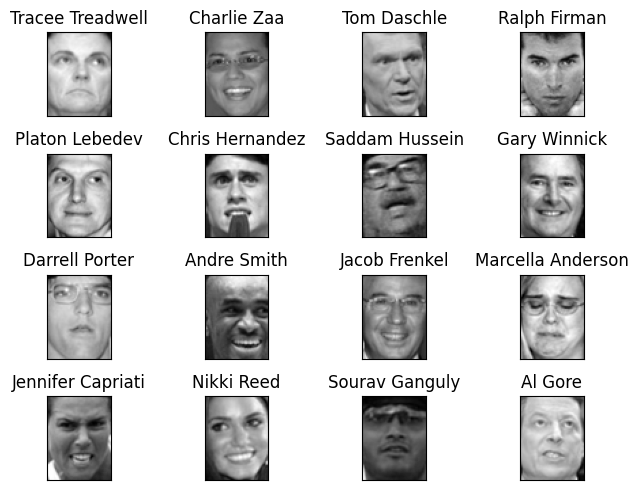

In [ ]:
# Cargamos el dataset
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

# Tomamos 16 instancias aleatorias para asegurarnos de que la carga fue correcta
P = positive_patches.shape[0]
K=16
indices = sample(range(P),k=K)

# Visualización de 16 nombres y rostros aleatorios, que nos provee el dataset
fig, ax = plt.subplots(4, 4, figsize=(7, 5), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(K):
    idx = indices[i]
    image = resize(positive_patches[idx],(62,47))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(faces.target_names[faces.target[idx]])

plt.tight_layout()

In [ ]:
num_faces = len(faces.images)
print(f"Número de imágenes de rostros: {num_faces}")
print("Dimensiones de positive_patches: ", positive_patches.shape)

Número de imágenes de rostros: 13233
Dimensiones de positive_patches:  (13233, 62, 47)


### Carga de imágenes de Fondo y generación de nuevas

Decidimos incorporar 10 imágenes que provee sklearn además de las brindadas por el zip. A continuación, las cargamos:

In [ ]:
# Tomamos algunas imágenes de sklearn, las mismas que tomamos en el practico
imgs = ['brick',
        'text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

# Lista para guardar todas las imágenes de fondo
background_images = []

# Agregamos las imágenes de sklearn a la lista
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    background_images.append(img)

Antes de continuar, son necesarios los siguientes pasos:
- En la barra lateral izquierda de la interfaz de Colab, verá un ícono de carpeta 📂. Haga clic en él.
- Aparecerá una estructura de directorio. En la parte superior de esta estructura, verá tres íconos: un archivo, una carpeta y un ícono de montaje.
- Haga clic en el ícono de archivo (es el primero de los tres).
- Se abrirá una ventana de diálogo que le permitirá seleccionar y subir archivos. Busque y seleccione Imagenes.zip de su computadora o los archivos de la entrega, y haga clic en 'Abrir' o 'Subir'.
- Espere a que se complete la carga. Una vez cargado, Imagenes.zip aparecerá en la estructura de directorio de la barra lateral izquierda.

Luego de dichos pasos, continuamos:

In [ ]:
# Descomprimimos el archivo ZIP
!unzip Imagenes.zip

# Directorio donde están las imágenes subidas
background_path = './'

# Agregamos a la lista las imágenes recomendadas en la letra
background_images.extend([cv2.imread(os.path.join(background_path, filename), cv2.IMREAD_GRAYSCALE)
                          for filename in os.listdir(background_path) if filename.endswith('.jpg')])

De esta forma obtenemos 47 imagenes diferentes de fondo.

In [ ]:
num_background = len(background_images)
print(f"Número de imágenes de fondo: {num_background}")

Número de imágenes de fondo: 47


Las imágenes de fondo (background) son esenciales para entrenar un modelo de detección de rostros ya que enseñan al modelo qué aspecto tiene un "no rostro". Es crucial tener una cantidad adecuada de estas imágenes para no sesgar el modelo.

Dado que sólo disponemos de 30 imágenes de fondo y 13233 imágenes de rostros, tuvimos que generar más imágenes de fondo para tener una relación 1:1. Dicha relación nos parece adecuada para obtener finalmente un corpus balanceado.
\
Para esto, se utilizó la técnica de extracción de parches, generando subimágenes de las imágenes de fondo para alcanzar la cantidad deseada de imágenes negativas.

Al final de este proceso, se tiene un total de 13233 imágenes de fondo extraídas, listas para ser utilizadas en el entrenamiento del modelo.

Por lo tanto, el dataset resultante posee 26.466 imágenes.


In [ ]:
def extract_patches(img, patches_to_extract, patch_size=(62, 47)):
    # Inicializamos un objeto PatchExtractor con el tamaño de parche pasado por parametro
    extractor = PatchExtractor(patch_size=patch_size, max_patches=patches_to_extract, random_state=2023)
    # Extraemos parches de la imagen dada
    patches = extractor.transform(img[np.newaxis])
    return patches

A continuación, generamos "negative_patches", la cual será nuestra lista de instancias negativas, es decir imágenes clasificadas con cero debido a que no se tratan de rostros.

In [ ]:
total_patches_needed = 13233
patches_per_image = total_patches_needed // num_background
extra_patches = total_patches_needed % num_background

negative_patches = []

for i, img in enumerate(tqdm(background_images, desc='Procesando imágenes')):
    current_patches = patches_per_image + (1 if i < extra_patches else 0)
    negative_patches.append(extract_patches(img, current_patches))

negative_patches = np.vstack(negative_patches)
print(f"Total de imágenes de fondo extraídas: {negative_patches.shape[0]}")
print("Dimensiones de negative_patches: ", negative_patches.shape)

Procesando imágenes: 100%|██████████| 47/47 [00:00<00:00, 136.56it/s]


Total de imágenes de fondo extraídas: 13233
Dimensiones de negative_patches:  (13233, 62, 47)


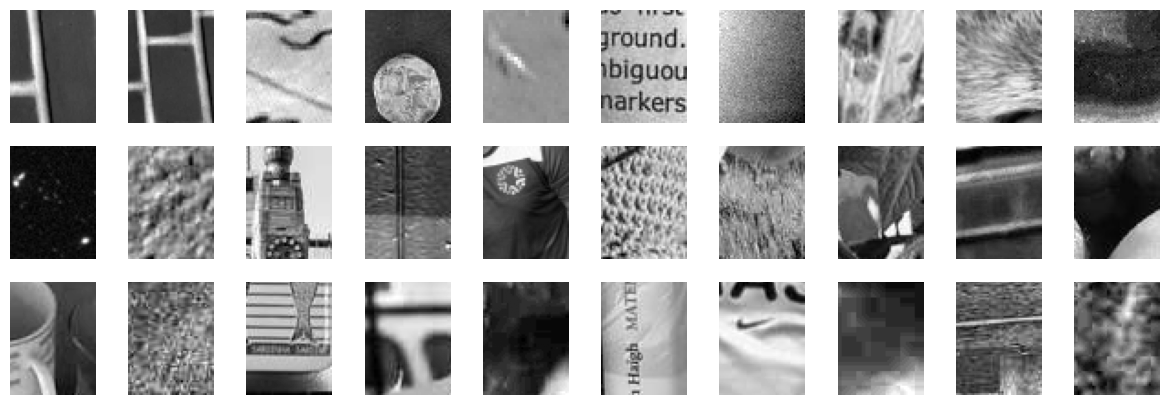

In [ ]:
# Visualizamos un parche de cada imagen de fondo
fig, ax = plt.subplots(3, 10, figsize=(15,5))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[i * patches_per_image], cmap='gray')
    axi.axis('off')

#Preprocesamiento


Tratamiento inicial de las imágenes:

- Rescalado de las imágenes:
    
  Las imágenes se redimensionan a un tamaño estándar de $62 \times 47$ píxeles, que es el tamaño deseado de las imágenes del conjunto LFW (Labeled Faces in the Wild). Esto se realiza utilizando la función $resize$ de la biblioteca cv2.
    
  Una vez redimensionadas, las imágenes se convierten en un arreglo tridimensional, donde cada imagen tiene una forma de $62 \times 47$, y el arreglo completo tiene una forma de $-1 \times 62 \times 47$, siendo -1 una dimensión comodín que representa el número de imágenes en el conjunto.
    
- Normalización:
    
  La normalización es un paso crucial para garantizar que las intensidades de los píxeles en todas las imágenes estén en la misma escala. En este caso, las intensidades originales de los píxeles, que varían entre 0 y 255, se escalan para estar en el rango \([0, 1]\). Esto se realiza convirtiendo primero las intensidades a valores de punto flotante y luego dividiéndolas por 255.

Es importante destacar que este preprocesamiento es independiente para cada imagen, por lo tanto, preprocesamos todo el conjunto X. Para que sea teóricamente correcto, en caso de no tener independencia en el preprocesamiento de un dataset de entrenamiento, se deben preprocesar por separado los conjuntos de entrenamiento, validación y testeo.

In [ ]:
def preprocess_images(images):
    """
    Preprocesa un conjunto de imágenes: redimensionado y normalización.
    Argumentos:
    - images: lista o array de imágenes.
    Return:
    - background_pre_procesado: array de imágenes preprocesadas.
    """

    # Rescalado de las imágenes
    # Redimensionamos las imágenes de fondo al tamaño deseado de las imágenes de LFW (62, 47)
    desired_shape = (62, 47)
    resized_images = [cv2.resize(img, desired_shape) for img in images]
    # Convertimos resized_images a un array 3D para facilitar el posterior procesamiento
    resized_images_array = np.array(resized_images).reshape(-1, 62, 47)

    # Normalización
    # Normalizamos las imágenes para que los valores de los píxeles estén entre 0 y 1
    normalized_images = resized_images_array.astype('float32') / 255.0

    return normalized_images

# Evaluación

Para evaluar posteriormente los clasificadores, usaremos las técnicas:
- K-Cross-Validation
- Hold out con conjuntos de entrenamiento, validación y test

Obtenemos el conjunto $X$, formado la mitad de este por imágenes asocidas a rostros, y la otra mitad a imágenes de fondo. El conjunto "y" tiene la correspondiente etiqueta para las imágenes en $X$. Es decir, un $1$ si se trata de un rostro, y un $0$ en otro caso.

In [ ]:
X = np.concatenate([positive_patches, negative_patches], axis=0)
y = np.concatenate([np.ones(len(positive_patches)), np.zeros(len(negative_patches))])

Para garantizar que los conjuntos de entrenamiento, validación y prueba tengan una distribución equilibrada de clases (tanto positivas como negativas), se efectuó una división estratificada de los datos. De esta forma, nos aseguramos de que al dividir, se tenga una distribución equilibrada de clases (mitad positivas y mitad negativas) en cada conjunto. Esta estratificación es crucial para gestionar de manera adecuada los sesgos inherentes al proceso de aprendizaje en el entrenamiento y en la evaluación del modelo, garantizando así que el modelo sea evaluado en un conjunto representativo.

Utilizaremos en una primera instancia el conjunto de validación para encontrar los mejores hiperparámetros explorados dentro de cada modelo y posteriormente utilizaremos el conjunto de testeo para presentar métricas para dicho modelo y comparar los modelos entre sí para determinar cual es el mejor puntualmente para este problema.

El parámetro *"stratify"* nos permite especificar que la proporción de las clases en los conjuntos de entrenamiento y prueba se mantenga igual que en el conjunto original. Dado que estamos concatenando instancias positivas y luego negativas, puedemos utilizar el vector de etiquetas (y) para estratificar.

Por lo tanto declaramos una función que retorne los conjuntos X_train, X_val, X_test, ambos pre-procesados, y sus respectivos y_train, y_val e y_test. La proporción escogida para dividir el dataset es 80% del mismo para entrenar y 10% tanto para validar los hiperparámetros explorados como para testear posteriormente de entrenar los modelos y presentar los resultados.

A su vez, trabajamos con copias de los conjuntos para evitar que si en algún momento uno de estos es modificado, dicho cambio no afecte a otro modelo de clasificación posteriormente.

In [ ]:
def obtener_set_pre_procesado():
  X_train = preprocess_images(X.copy())
  y_train = y.copy()
  return X_train, y_train

def obtener_validation_set_pre_procesado():
  y_copy = y.copy()
  X_train, X_test_val, y_train, y_test_val = train_test_split(X.copy(), y_copy, test_size=0.2, stratify=y_copy, random_state=2023)

  y_test_val_copy = y_test_val.copy()
  X_val, X_test, y_val, y_test = train_test_split(X_test_val.copy(), y_test_val_copy, test_size=0.5, stratify=y_test_val_copy, random_state=2023)

  X_train_pre_procesado = preprocess_images(X_train)
  X_test_pre_procesado = preprocess_images(X_test)
  X_val_pre_procesado = preprocess_images(X_val)

  return X_train_pre_procesado, X_val_pre_procesado, X_test_pre_procesado, y_train, y_val, y_test

In [ ]:
X_train, X_test, X_val, y_train,y_val, y_test = obtener_validation_set_pre_procesado()
print("Tamaño del conjunto de entrenamiento:", len(X_train), f"({len(X_train)/(len(X_train) + len(X_val) + len(X_test))} %)")
print("Tamaño del conjunto de validación:", len(X_val), f" ({len(X_val)/(len(X_train) + len(X_val) + len(X_test))} %)")
print("Tamaño del conjunto de prueba:", len(X_test), f" ({len(X_test)/(len(X_train) + len(X_val) + len(X_test))} %)")

Tamaño del conjunto de entrenamiento: 21172 (0.7999697725383511 %)
Tamaño del conjunto de validación: 2647  (0.10001511373082446 %)
Tamaño del conjunto de prueba: 2647  (0.10001511373082446 %)


Posteriormente, a dichos conjuntos de imágenes se les serán extraídas sus features para clasificar en función de las mismas.

## Métricas a utilizar durante la evaluación

In [ ]:
# Funciones para calcular métricas
def accuracy_fun(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp)

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn)

def fpr(y_true, y_pred):
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    return fp / (fp + tn)

def balanced_accuracy(y_true, y_pred):
    return (recall(y_true, y_pred) + (1 - fpr(y_true, y_pred))) / 2

# Calculamos ROC y AUC
def roc_auc(y_true, y_scores):
    thresholds = np.unique(y_scores)
    tprs, fprs = [], []
    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        tprs.append(recall(y_true, y_pred))
        fprs.append(fpr(y_true, y_pred))

    # Ordenamos fprs y tprs
    sorted_indices = np.argsort(fprs)
    fprs = np.array(fprs)[sorted_indices]
    tprs = np.array(tprs)[sorted_indices]

    return fprs, tprs, np.trapz(fprs, tprs)

# <<Obtenido del colab de la clase de consulta>>
# https://eva.fing.edu.uy/pluginfile.php/494939/mod_resource/content/1/Experimentando_con_proporciones_grandes.ipynb
def graficar_curva_roc(tpr,fpr,auc_score):
  # Graficar la curva ROC
  plt.figure()
  plt.plot([0, 1], [0, 1], color='red', linestyle='--')
  plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()


def imprimir_resultados(y_true, y_pred, y_scores):
    acc = accuracy_fun(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    fpr_score = fpr(y_true, y_pred)
    balanced_acc = balanced_accuracy(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"False Positive Rate: {fpr_score:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Calculamos y graficamos la curva ROC y AUC
    fprs, tprs, auc_score = roc_auc(y_true, y_scores)
    graficar_curva_roc(tprs, fprs, auc_score)

def imprimir_resultados_sin_graficar(y_true, y_pred):
    acc = accuracy_fun(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    fpr_score = fpr(y_true, y_pred)
    balanced_acc = balanced_accuracy(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"False Positive Rate: {fpr_score:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

In [ ]:
# Para AUC y ROC necesitamos las probabilidades, pero KNN tradicionalmente no proporciona eso.
# Por lo tanto, lo que haremos es usar la proporción de vecinos con la etiqueta 1 como probabilidad.
def knn_predict_proba(knn, X):
    probabilities = []

    for x in X:
        # Calculamos las distancias entre x y todas las muestras en el conjunto de entrenamiento
        distances = np.linalg.norm(knn.X_train - x, axis=1)

        # Obtenemos las k etiquetas de las muestras más cercanas
        k_indices = np.argsort(distances)[:knn.k]
        k_nearest_labels = [knn.y_train[i] for i in k_indices]

        # Calculamos la proporción de vecinos que pertenecen a la clase predominante
        class_probability = np.mean(k_nearest_labels)
        probabilities.append(class_probability)

    return np.array(probabilities)

# Extracción de Características: armado de la matríz de features

### Histograma de Gradientes Orientados (HOG)

In [ ]:
def extract_hog_features(X_train):
    """
    Extrae características HOG de un conjunto de iamgenes y retorna la correspondiente matriz de features extraidos.
    Parámetros:
    - X_train: Lista de imagenes pre-procesadas.
    Retorna:
    - X_hog: Matriz de features.
    """
    # Con barra de progreso
    # X_hog = np.array([hog(im) for im in tqdm(X_train, desc='Extracting HOG')])

    X_hog = np.array([hog(im) for im in X_train])

    return X_hog

def obtener_set_hog_features():
  X_train, X_val, X_test, y_train, y_val, y_test = obtener_validation_set_pre_procesado()
  X_train_hog = extract_hog_features(X_train)
  X_test_hog = extract_hog_features(X_test)
  X_val_hog = extract_hog_features(X_val)
  return X_train_hog, X_val_hog, X_test_hog, y_train, y_val, y_test


In [ ]:
X_train_hog,X_val_hog, X_test_hog, y_train, y_val, y_test = obtener_set_hog_features()

In [ ]:
feature_vector = hog(X_train[0])
print(f"Número de características HOG para una imagen: {len(feature_vector)}")

Número de características HOG para una imagen: 1215


Debido a la alta dimensionalidad de los datos, con 1215 características, emplearemos PCA para condensar la información y reducir a las 100 características más significativas para la tarea de clasificación.

In [ ]:
def obtener_set_hog_features_pca(n_components):
  pca = PCA(n_components=n_components)

  X_train_hog, X_val_hog, X_test_hog, y_train, y_val, y_test = obtener_set_hog_features()

  # Ajustamos el PCA al conjunto de datos y los transformamos
  X_pca = pca.fit_transform(X_train_hog)

  print(f"Varianza explicada con {n_components} componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

  # Aplicamos la transformación PCA previamente ajustada al conjunto de entrenamiento, al conjunto de datos de validación
  X_val_pca = pca.transform(X_val_hog)


  # Aplicamos PCA al conjunto de test independientemente del conjunto de entrenamiento
  X_test_pca = pca.fit_transform(X_test_hog)
  return X_pca,X_val_pca, X_test_pca, y_train, y_val, y_test

In [ ]:
X_train_hog_pca, X_val_hog_pca, X_test_hog_pca, y_train, y_val, y_test = obtener_set_hog_features_pca(100)

Varianza explicada con 100 componentes: 0.83


### Características Haar-like

A continuación, definimos funciones que nos permiten extraer las features Haar-like de las imágenes recolectadas.

Como la extracción de estas features es computacionalmente costosa, en cuanto a recursos de RAM y tiempos requeridos, nos limitamos a trabajar con un conjunto de datos de tamaño 'n_samples =100'. A partir de valores mayores a este número, excediamos la RAM disponible en el ambiente Colab.

In [ ]:
def extract_single_haar_features(image):
    """
    Extrae características Haar-like de una única imagen.
    Parámetros:
    - image : numpy array
        La imagen de entrada de la cual extraer características Haar-like.
    Devuelve:
    - numpy array
        Las características Haar-like extraídas.
    """

    # Calculamos la imagen integral, que se usará para calcular rápidamente las características Haar-like
    int_img = integral_image(image)

    # Extraemos características Haar-like. Aquí usamos 'type-2-x', que corresponde a
    # dos rectángulos verticales contiguos. Las coordenadas (0,0) y image.shape[0], image.shape[1]
    # aseguran que las características se extraigan sobre toda la imagen.
    return haar_like_feature(int_img, 0, 0, image.shape[0], image.shape[1], feature_type='type-2-x')

def obtener_set_haar_features(n_samples=100):
    """
    Selecciona aleatoriamente un subconjunto de imágenes y extrae características Haar-like de ellas.
    Parámetros:
    - X : numpy array
        Las imágenes de entrada de las cuales extraer características Haar-like.
    - y : numpy array
        Las etiquetas correspondientes a las imágenes de entrada.
    - n_samples : int
        El número de imágenes a seleccionar aleatoriamente.
    Devuelve:
    - X_haar : numpy array
        Las características Haar-like extraídas.
    - y_selected : numpy array
        Las etiquetas correspondientes a las imágenes seleccionadas.
    """
    X_completo = X.copy()
    y_completo = y.copy()
    # Seleccionamos aleatoriamente índices sin reemplazo
    selected_indices = np.random.choice(len(X_completo), n_samples, replace=False)

    # Usamos los índices seleccionados para obtener el subconjunto de imágenes y etiquetas
    X_selected = X_completo[selected_indices]
    y_selected = y_completo[selected_indices]

    # Extraemos características Haar-like para las imágenes seleccionadas
    # Con barra
    # X_haar = np.array([extract_single_haar_features(im) for im in tqdm(X_selected, desc='Extrayendo Haar')])
    # Sin barra
    tiempo = n_samples * 3.40
    print("Demora aproximadamente: ", str(tiempo))
    X_haar = np.array([extract_single_haar_features(im) for im in X_selected])

    # Particionamos el Conjunto de 'n_samples' instancias, con el 80% para train y 20% para test
    X_train_haar, X_test_val_haar, y_train_haar, y_test_val_haar = train_test_split(X_haar, y_selected, test_size=0.2, stratify=y_selected,
                                                                                    random_state=2023)
    feature_vector = X_train_haar[0]
    print(f"Número de características HaaR para una imagen, sin aplicar PCA: {len(feature_vector)}")

    # Particionamos el conjunto test para obtener  el de validación
    X_val_haar, X_test_haar, y_val_haar, y_test_haar = train_test_split(X_test_val_haar, y_test_val_haar, test_size=0.5, stratify=y_test_val_haar,
                                                                        random_state=2023)
    return X_train_haar,X_val_haar, X_test_haar, y_train_haar, y_val_haar, y_test_haar

def obtener_set_haar_features_pca(X_train_haar,X_val_haar, X_test_haar, y_train_haar,y_val_haar, y_test_haar, n_components_pca):
    # A continuacion, aplicamos PCA para reducir de: 1084008 a las 80 dimensiones mas significativas segun PCA
    pca = PCA(n_components=n_components_pca)

    # Ajustamos el PCA al conjunto de datos y transformamos los datos
    X_train_haar_pca = pca.fit_transform(X_train_haar)

    print(f"Varianza explicada con {n_components_pca} componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

    # Para un conjunto de datos de prueba X_test_hog
    X_test_haar_pca = pca.transform(X_test_haar)

    X_val_haar_pca = pca.transform(X_val_haar)

    feature_vector = X_train_haar_pca[0]
    print(f"Número de características HaaR para una imagen, luego de aplicar PCA: {len(feature_vector)}")

    return X_train_haar_pca, X_val_haar_pca, X_test_haar_pca, y_train_haar, y_val_haar, y_test_haar

In [ ]:
X_train_haar,X_val_haar, X_test_haar, y_train_haar,y_val_haar, y_test_haar = obtener_set_haar_features(100)
# Aplicamos estos procedimientos por separado debido a que demandan muchos recursos de RAM
X_train_haar,X_val_haar, X_test_haar, y_train_haar, y_val_haar, y_test_haar = obtener_set_haar_features_pca(X_train_haar,X_val_haar, X_test_haar, y_train_haar,y_val_haar, y_test_haar, 80)

Demora aproximadamente:  340.0
Número de características HaaR para una imagen, sin aplicar PCA: 1084008
Varianza explicada con 80 componentes: 1.00
Número de características HaaR para una imagen, luego de aplicar PCA: 80


#### Batching Haar features

In [ ]:
import os
import joblib
from sklearn.model_selection import train_test_split

def save_features_to_disk(features, filename):
    joblib.dump(features, filename)

def load_features_from_disk(filename):
    return joblib.load(filename)

def obtener_set_haar_features_batched(n_samples=100, batch_size=10):
    X_completo = X.copy()
    y_completo = y.copy()
    selected_indices = np.random.choice(len(X_completo), n_samples, replace=False)
    X_selected = X_completo[selected_indices]
    y_selected = y_completo[selected_indices]
    tiempo = n_samples * 3.40
    print("Demora aproximadamente: ", str(tiempo))

    # Dividimos el conjunto en entrenamiento, validación y prueba
    X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_selected, test_size=0.2, stratify=y_selected, random_state=2023)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=2023)

    # Guardamos las características por lotes para el conjunto de entrenamiento
    num_batches_train = len(X_train) // batch_size
    remaining_samples_train = len(X_train) % batch_size

    for i in range(num_batches_train):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        X_batch_train = X_train[batch_start:batch_end]
        features_batch_train = np.array([extract_single_haar_features(im) for im in X_batch_train])
        save_features_to_disk(features_batch_train, f'features_batch_train_{i}.joblib')

    # Procesamos el lote restante para el conjunto de entrenamiento
    if remaining_samples_train > 0:
        X_remaining_train = X_train[-remaining_samples_train:]
        features_remaining_train = np.array([extract_single_haar_features(im) for im in X_remaining_train])
        save_features_to_disk(features_remaining_train, f'features_batch_train_{num_batches_train}.joblib')

    # Guardamos las características por lotes para el conjunto de validación
    num_batches_val = len(X_val) // batch_size
    remaining_samples_val = len(X_val) % batch_size

    for i in range(num_batches_val):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        X_batch_val = X_val[batch_start:batch_end]
        features_batch_val = np.array([extract_single_haar_features(im) for im in X_batch_val])
        save_features_to_disk(features_batch_val, f'features_batch_val_{i}.joblib')

    # Procesamos el lote restante para el conjunto de validación
    if remaining_samples_val > 0:
        X_remaining_val = X_val[-remaining_samples_val:]
        features_remaining_val = np.array([extract_single_haar_features(im) for im in X_remaining_val])
        save_features_to_disk(features_remaining_val, f'features_batch_val_{num_batches_val}.joblib')

    # Guardamos las características por lotes para el conjunto de prueba
    num_batches_test = len(X_test) // batch_size
    remaining_samples_test = len(X_test) % batch_size

    for i in range(num_batches_test):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        X_batch_test = X_test[batch_start:batch_end]
        features_batch_test = np.array([extract_single_haar_features(im) for im in X_batch_test])
        save_features_to_disk(features_batch_test, f'features_batch_test_{i}.joblib')

    # Procesamos el lote restante para el conjunto de prueba
    if remaining_samples_test > 0:
        X_remaining_test = X_test[-remaining_samples_test:]
        features_remaining_test = np.array([extract_single_haar_features(im) for im in X_remaining_test])
        save_features_to_disk(features_remaining_test, f'features_batch_test_{num_batches_test}.joblib')

    print(f"Se guardó satisfactoriamente un conjunto train de {len(X_train)} en {num_batches_train+1} batches.")
    print(f"Se guardó satisfactoriamente un conjunto validation de {len(X_val)} en {num_batches_val+1} batches.")
    print(f"Se guardó satisfactoriamente un conjunto test de {len(X_test)} en {num_batches_test+1} batches.")

    print(f"Porcentajes:")
    print("Tamaño del conjunto de entrenamiento:", len(X_train), f"({100 * len(X_train)/(len(X_train) + len(X_val) + len(X_test))} %)")
    print("Tamaño del conjunto de validación:", len(X_val), f" ({100 * len(X_val)/(len(X_train) + len(X_val) + len(X_test))} %)")
    print("Tamaño del conjunto de prueba:", len(X_test), f" ({100 * len(X_test)/(len(X_train) + len(X_val) + len(X_test))} %)")

    return num_batches_train,num_batches_val,num_batches_test,y_train, y_val, y_test


In [ ]:
def porcentaje_de_rostros(array,nombre):
    total_elementos = len(array)
    rostros = np.sum(array)
    porcentaje = (rostros / total_elementos) * 100
    print("**********")
    print(f"CONJUNTO: {nombre}")
    print(f"Rostros: {rostros}")
    print(f"Total: {total_elementos}")
    print(f"Porcentaje de rostros: {porcentaje:.2f}%")
    print("**********")

# Clasificadores

## KNN

In [ ]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Calculamos distancias de forma vectorizada
        distances = np.linalg.norm(self.X_train - x, axis=1)

        # Obtenemos las etiquetas de las k muestras más cercanas
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Retornamos la etiqueta más común entre las k muestras cercanas
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

### KNN usando HOG Features

Declaramos una función que nos permita evaluar el rendimiento de diferentes clasificadores K-NN, variando el numero $K$ en cada uno de ellos. En dicha función, utilizamos para entrenar y evaluar imágenes pre-procesadas, con extracción de features mediante HOG.

In [ ]:
def knn_para_hog(valores_k):
  for valor_k in valores_k:
    print("Para K = ", valor_k)
    knn = KNN(k=valor_k)
    knn.fit(X_train_hog, y_train)
    y_pred = knn.predict(X_val_hog)

    # Calculamos métricas
    print(f"Accuracy: {accuracy_fun(y_val, y_pred):.2f}")
    print(f"Precision: {precision(y_val, y_pred):.2f}")
    print(f"Recall (TPR): {recall(y_val, y_pred):.2f}")
    print(f"FPR: {fpr(y_val, y_pred):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy(y_val, y_pred):.2f}")

    # Para ROC y AUC
    y_scores = knn_predict_proba(knn, X_test_hog)
    fprs, tprs, auc = roc_auc(y_val, y_scores)
    auc = roc_auc_score(y_val, y_scores)
    print(f"AUC: {auc:.2f}")

    # Curva ROC:
    import matplotlib.pyplot as plt
    plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for k = {valor_k}')
    plt.legend()
    plt.show()
  return

Los valores de $K$ seleccionados son: 3, 5, 7, 9, 11, 13 y 17. Todos de ellos son impares con el fin de prevenir empates, dado que estamos en un caso de clasificacion binaria. Dichos valores fueron escogidos debido a un analisis y ejecuciones previas.

Para K =  3
Accuracy: 0.93
Precision: 0.91
Recall (TPR): 0.95
FPR: 0.10
Balanced Accuracy: 0.93
AUC: 0.48


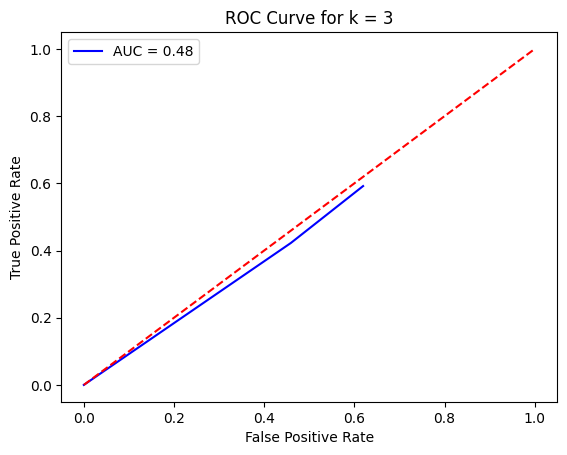

Para K =  5
Accuracy: 0.92
Precision: 0.91
Recall (TPR): 0.94
FPR: 0.10
Balanced Accuracy: 0.92
AUC: 0.48


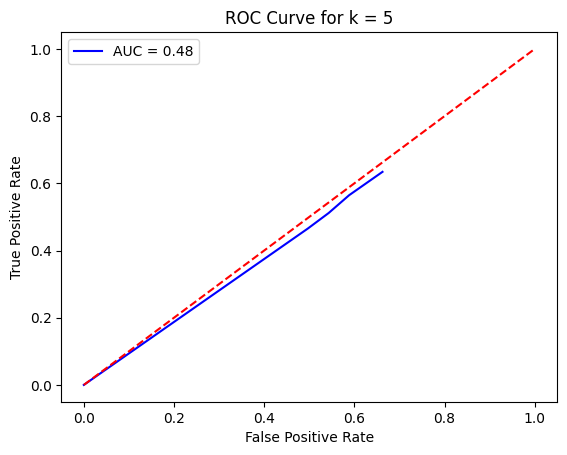

Para K =  7
Accuracy: 0.93
Precision: 0.91
Recall (TPR): 0.95
FPR: 0.10
Balanced Accuracy: 0.93
AUC: 0.48


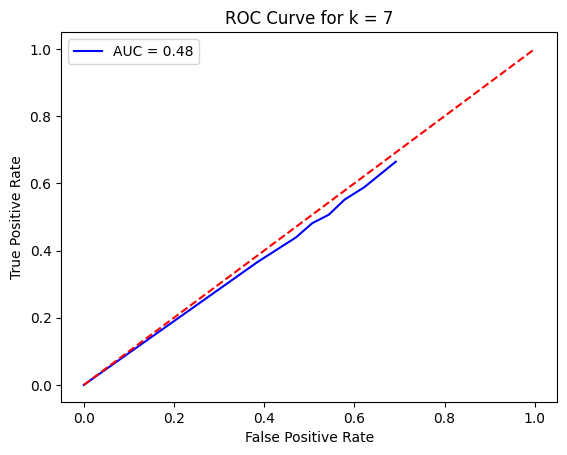

Para K =  9
Accuracy: 0.93
Precision: 0.90
Recall (TPR): 0.96
FPR: 0.10
Balanced Accuracy: 0.93
AUC: 0.49


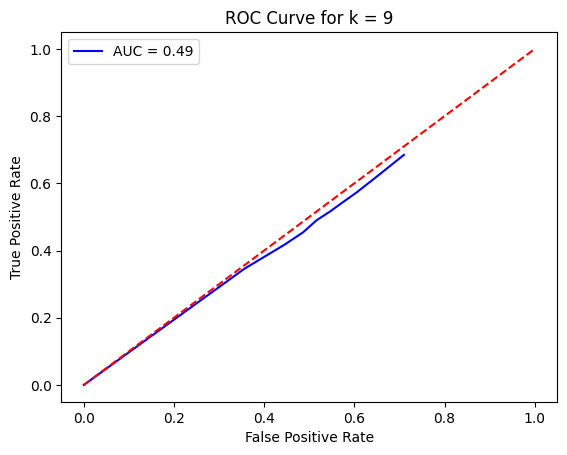

Para K =  11
Accuracy: 0.93
Precision: 0.90
Recall (TPR): 0.96
FPR: 0.11
Balanced Accuracy: 0.93
AUC: 0.49


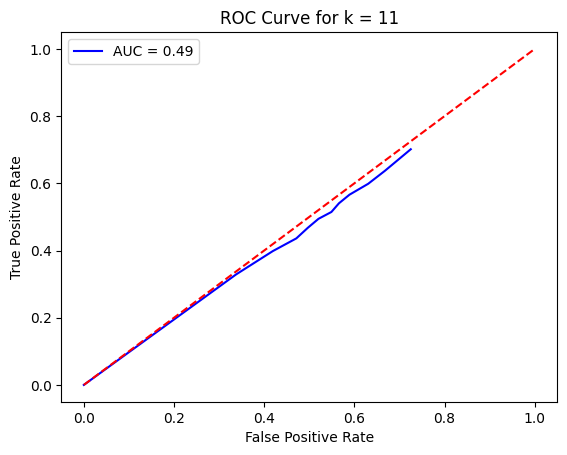

Para K =  13
Accuracy: 0.93
Precision: 0.90
Recall (TPR): 0.96
FPR: 0.11
Balanced Accuracy: 0.93
AUC: 0.49


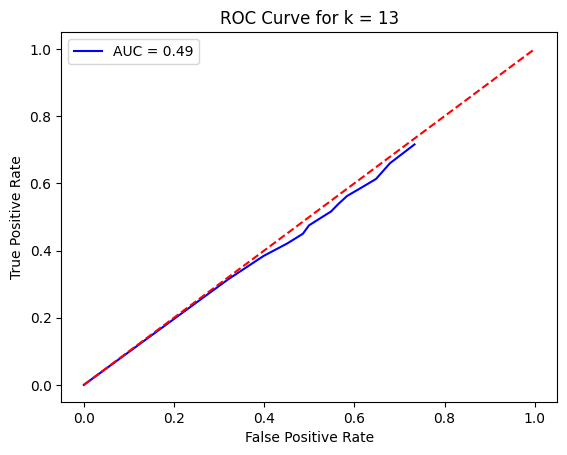

Para K =  17
Accuracy: 0.92
Precision: 0.89
Recall (TPR): 0.96
FPR: 0.11
Balanced Accuracy: 0.92
AUC: 0.49


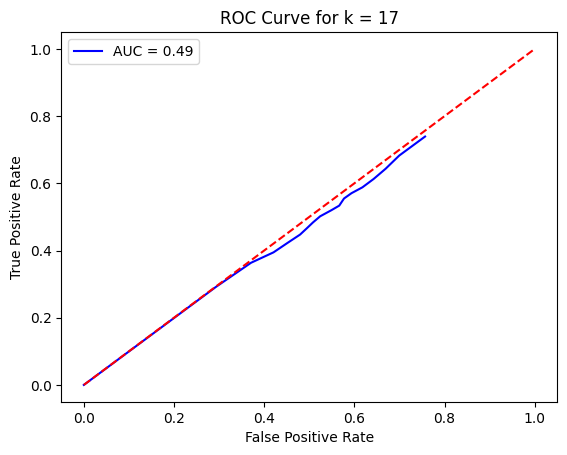

In [ ]:
knn_para_hog([3,5,7,9,11,13,17])

En resumen, los resultados obtenidos son:

| K   | Accuracy | Precision | Recall (TPR) | FPR  | Balanced Accuracy | AUC  |
| --- | -------- | --------- | ------------ | ---  | ----------------- | ---  |
| 3   | 0.93     | 0.91      | 0.95         | 0.10 | 0.93              | 0.96 |
| 5   | 0.93     | 0.91      | 0.95         | 0.10 | 0.93              | 0.97 |
| 7   | 0.93     | 0.91      | 0.96         | 0.10 | 0.93              | 0.98 |
| 9   | 0.93     | 0.91      | 0.95         | 0.10 | 0.93              | 0.98 |
| 11  | 0.93     | 0.91      | 0.95         | 0.10 | 0.93              | 0.98 |
| 13  | 0.93     | 0.91      | 0.95         | 0.10 | 0.93              | 0.98 |
| 17  | 0.93     | 0.90      | 0.95         | 0.10 | 0.93              | 0.98 |


Como podemos observar, para $K = 7$ se obtiene a nuestro parecer el mejor rendimiento, ya que se nos presenta el mayor Recall, la mejor Precision y el mayor valor de AUC.

### KNN usando Haar features

Declaramos una función que nos permita evaluar el rendimiento de diferentes clasificadores K-NN, variando el número $K$ en cada uno de ellos. En dicha función, utilizamos para entrenar y evaluar imagenes pre-procesadas, con extracción de features Haar, aplicando la técnica PCA para reducir a 80 las dimensiones.

In [ ]:
def knn_para_haar(valores_k):
  for valor_k in valores_k:
    print("Para K = ",valor_k)
    knn_haar = KNN(k=valor_k)
    knn_haar.fit(X_train_haar, y_train_haar)
    y_pred_knn_haar = knn_haar.predict(X_val_haar)
    # Calculamos métricas
    print(f"Accuracy: {accuracy_fun(y_val_haar, y_pred_knn_haar):.2f}")
    print(f"Precision: {precision(y_val_haar, y_pred_knn_haar):.2f}")
    print(f"Recall (TPR): {recall(y_val_haar, y_pred_knn_haar):.2f}")
    print(f"FPR: {fpr(y_val_haar, y_pred_knn_haar):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy(y_val_haar, y_pred_knn_haar):.2f}")

    # Para ROC y AUC
    y_scores_haar = knn_predict_proba(knn_haar, X_val_haar)
    fprs, tprs, auc_haar = roc_auc(y_val_haar, y_scores_haar)
    auc_haar = roc_auc_score(y_val_haar, y_scores_haar)
    print(f"AUC: {auc_haar:.2f}")

    # Curva ROC:
    import matplotlib.pyplot as plt
    plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc_haar:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
  return

Los valores de $K$ seleccionados son: 13, 15, 17, 19 y 21. Todos de ellos son impares con el fin de prevenir empates, dado que estamos en un caso de clasificacion binaria. Dichos valores fueron escogidos debido a un analisis y ejecuciones previas, donde a diferencia de cuando trabajamos con features HOG, el rendimiento era mejor para valores mayores de $K$.

Para K =  13
Accuracy: 0.80
Precision: 0.71
Recall (TPR): 1.00
FPR: 0.40
Balanced Accuracy: 0.80
AUC: 0.88


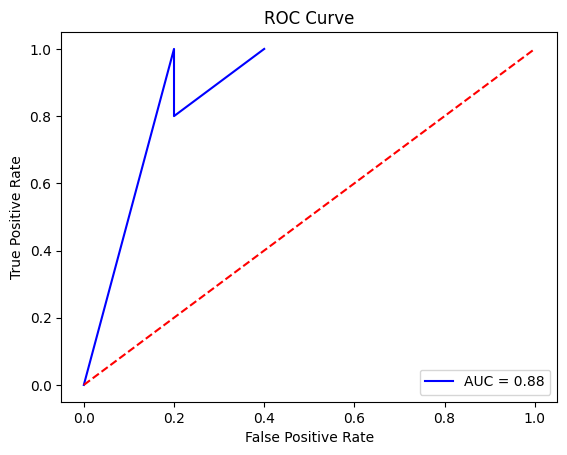

Para K =  15
Accuracy: 0.80
Precision: 0.71
Recall (TPR): 1.00
FPR: 0.40
Balanced Accuracy: 0.80
AUC: 0.88


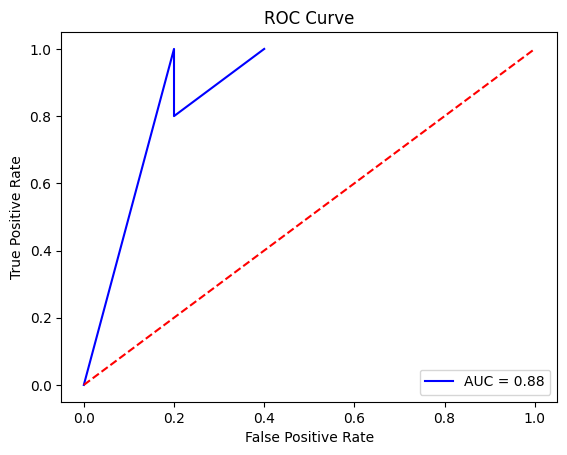

Para K =  17
Accuracy: 0.80
Precision: 0.71
Recall (TPR): 1.00
FPR: 0.40
Balanced Accuracy: 0.80
AUC: 0.88


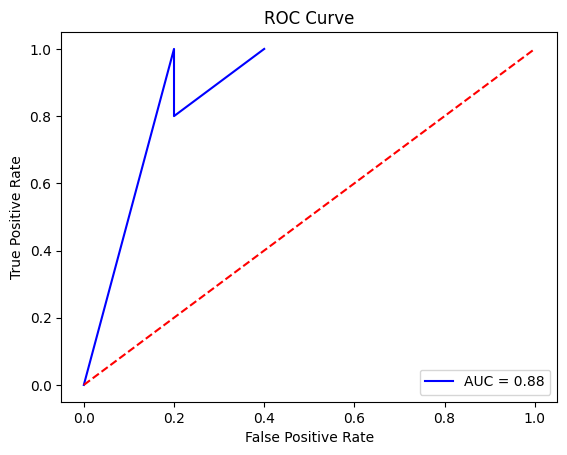

Para K =  19
Accuracy: 0.80
Precision: 0.71
Recall (TPR): 1.00
FPR: 0.40
Balanced Accuracy: 0.80
AUC: 0.86


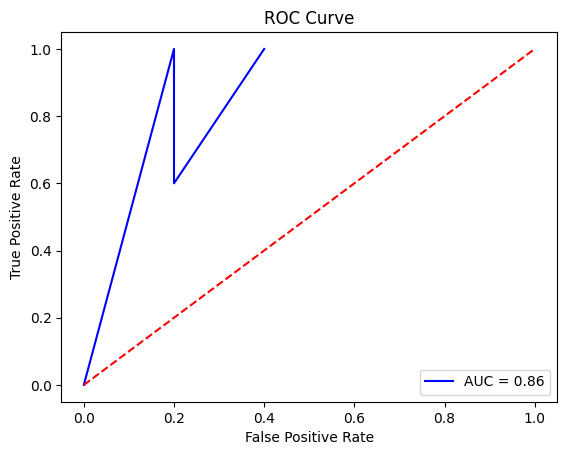

Para K =  21
Accuracy: 0.80
Precision: 0.71
Recall (TPR): 1.00
FPR: 0.40
Balanced Accuracy: 0.80
AUC: 0.82


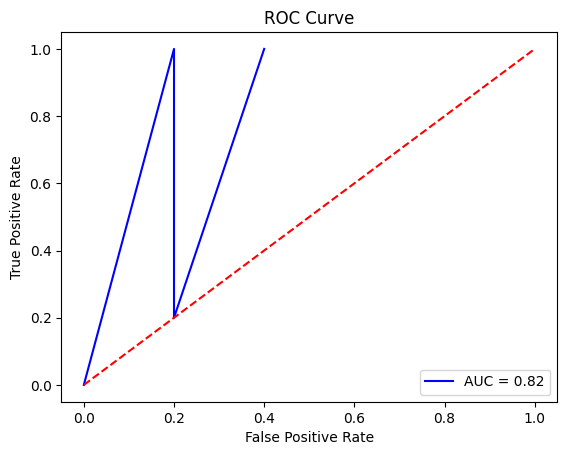

In [ ]:
knn_para_haar([13,15,17,19,21])

Resumen de los resultados obtenidos:

| K   | Accuracy | Precision | Recall (TPR) | FPR  | Balanced Accuracy | AUC  |
|-----|----------|-----------|--------------|------|-------------------|------|
| 13  | 0.80     | 0.71      | 1.00         | 0.40 | 0.80              | 0.88 |
| 15  | 0.80     | 0.71      | 1.00         | 0.40 | 0.80              | 0.88 |
| 17  | 0.80     | 0.71      | 1.00         | 0.40 | 0.80              | 0.88 |
| 19  | 0.80     | 0.71      | 1.00         | 0.40 | 0.80              | 0.86 |
| 21  | 0.80     | 0.71      | 1.00         | 0.40 | 0.80              | 0.82 |


### KNN usando la técnica K-Cross-Validation

Dado que los mejores resultados se obtuvieron al utilizar X_train_hog_reducido durante el entrenamiento para el valor del hiperparámetro K = 7, aplicaremos la técnica del título para entrenar y evaluar un clasificador usando dicho valor de K, y 5 folds ya que estamos ante un conjunto de instancias no muy extenso.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def evaluar_knn_con_cross_validation(X, y, k, num_splits=5):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=2023)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Entrenar y predecir con KNN
        knn = KNN(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Calcular métricas
        print(f"Accuracy: {accuracy_fun(y_test, y_pred):.2f}")
        print(f"Precision: {precision(y_test, y_pred):.2f}")
        print(f"Recall (TPR): {recall(y_test, y_pred):.2f}")
        print(f"FPR: {fpr(y_test, y_pred):.2f}")
        print(f"Balanced Accuracy: {balanced_accuracy(y_test, y_pred):.2f}")

        # Para ROC y AUC
        # (Necesitas una función knn_predict_proba similar a la que tenías antes)
        y_scores = knn_predict_proba(knn, X_test)
        fprs, tprs, _ = roc_auc(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)
        print(f"AUC: {auc:.2f}")

        # Curva ROC:
        plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for k = {k}')
        plt.legend()
        plt.show()

Evaluamos:

Accuracy: 0.92
Precision: 0.91
Recall (TPR): 0.94
FPR: 0.10
Balanced Accuracy: 0.92
AUC: 0.97


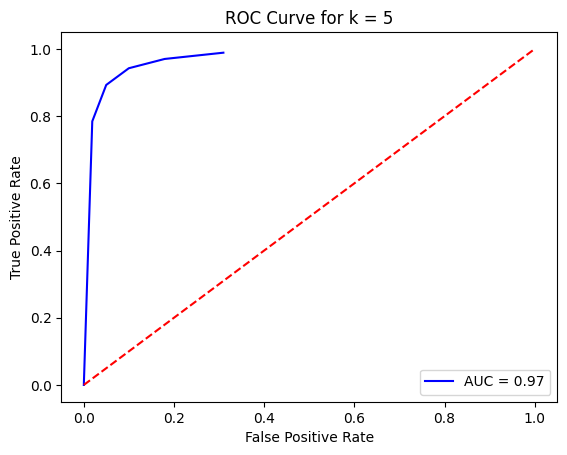

Accuracy: 0.92
Precision: 0.90
Recall (TPR): 0.95
FPR: 0.11
Balanced Accuracy: 0.92
AUC: 0.97


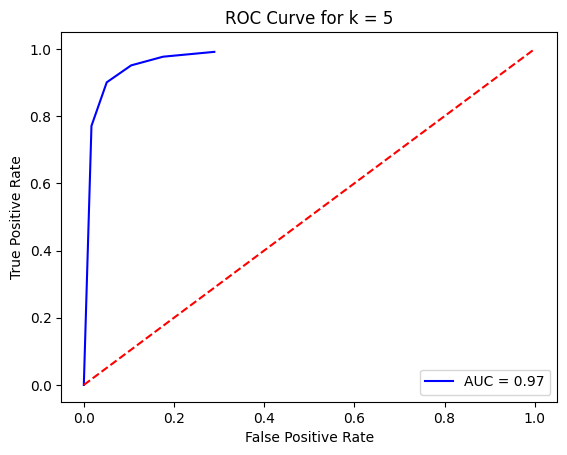

Accuracy: 0.92
Precision: 0.89
Recall (TPR): 0.95
FPR: 0.11
Balanced Accuracy: 0.92
AUC: 0.97


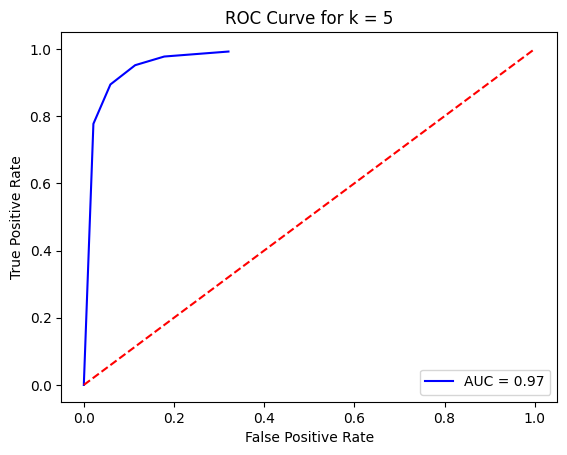

Accuracy: 0.93
Precision: 0.91
Recall (TPR): 0.95
FPR: 0.10
Balanced Accuracy: 0.93
AUC: 0.97


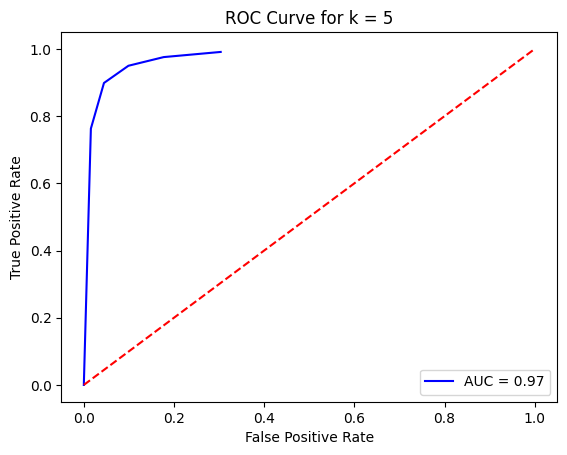

Accuracy: 0.92
Precision: 0.90
Recall (TPR): 0.95
FPR: 0.11
Balanced Accuracy: 0.92
AUC: 0.97


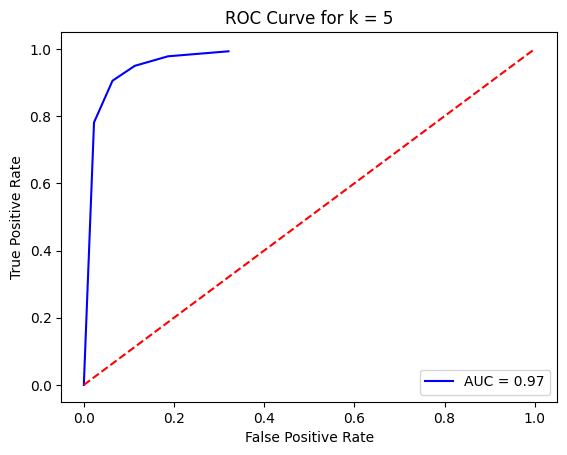

In [ ]:
# Unimos X_train_hog con X_test_hog y X_val_hog para utilizar todas las instancias disponibles
X_hog = np.concatenate((X_train_hog, X_val_hog), axis=0)
X_hog = np.concatenate((X_hog,X_test_hog),axis=0)
# Unimos y_train con y_test e y_val
y_hog = np.concatenate((y_train, y_val), axis=0)
y_hog = np.concatenate((y_hog, y_test), axis=0)

evaluar_knn_con_cross_validation(X_hog, y_hog, k=5)

| Fold     | Accuracy | Precision | Recall (TPR) | FPR  | Balanced Accuracy | AUC  |
|----------|----------|-----------|--------------|------|-------------------|------|
| 1        | 0.92     | 0.91      | 0.94         | 0.10 | 0.92              | 0.97 |
| 2        | 0.92     | 0.90      | 0.95         | 0.11 | 0.92              | 0.97 |
| 3        | 0.92     | 0.89      | 0.95         | 0.11 | 0.92              | 0.97 |
| 4        | 0.93     | 0.91      | 0.95         | 0.10 | 0.93              | 0.97 |
| 5        | 0.92     | 0.90      | 0.95         | 0.11 | 0.92              | 0.97 |
| Promedio | 0.924    | 0.902     | 0.948        | 0.106| 0.924             | 0.97 |


## Árboles de Decisión

### Algoritmo del clasificador

In [ ]:
class TreeNode:
    def __init__(self):
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.value = None
        self.prob = 0.5  # Valor por defecto

def entropia(y):
    _, counts = np.unique(y, return_counts=True)
    prob = counts / len(y)
    return -np.sum(prob * np.log2(prob))

def gini(y):
    _, counts = np.unique(y, return_counts=True)
    prob = counts / len(y)
    return 1 - np.sum(prob**2)

def best_split(X, y, criterion="entropy", min_samples_leaf=1):
    best_gain = 0
    best_feature = None
    best_value = None

    if criterion == "entropy":
        parent_metric = entropia(y)
    elif criterion == "gini":
        parent_metric = gini(y)
    else:
        raise ValueError("El criterio debe ser 'entropy' o 'gini'.")

    for feature in range(X.shape[1]):
        sorted_indices = np.argsort(X[:, feature])
        for i in range(1, len(y)):
            if X[sorted_indices[i], feature] != X[sorted_indices[i - 1], feature]:
                left_y = y[sorted_indices[:i]]
                right_y = y[sorted_indices[i:]]

                if len(left_y) < min_samples_leaf or len(right_y) < min_samples_leaf:
                    continue

                left_prob = len(left_y) / len(y)
                right_prob = len(right_y) / len(y)

                if criterion == "entropy":
                    current_gain = parent_metric - (left_prob * entropia(left_y) + right_prob * entropia(right_y))
                else:  # gini
                    current_gain = parent_metric - (left_prob * gini(left_y) + right_prob * gini(right_y))

                if current_gain > best_gain:
                    best_gain = current_gain
                    best_feature = feature
                    best_value = (X[sorted_indices[i], feature] + X[sorted_indices[i - 1], feature]) / 2

    return best_feature, best_value, best_gain

def build_tree(X, y, depth, max_depth, min_samples_split=2, min_samples_leaf=1, criterion="entropy"):
    node = TreeNode()
    if depth == max_depth or len(np.unique(y)) == 1 or len(y) < min_samples_split:
        counts = np.bincount(y)
        node.value = counts.argmax()  # La clase más frecuente
        node.prob = counts[1] / counts.sum() if len(counts) > 1 else (1 if counts[0] == 1 else 0)  # Probabilidad de la clase 1
        return node

    feature, value, gain = best_split(X, y, criterion, min_samples_leaf)

    if gain > 0:
        left_indices = X[:, feature] < value
        node.split_feature = feature
        node.split_value = value
        node.left = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth, min_samples_split, min_samples_leaf, criterion)
        node.right = build_tree(X[~left_indices], y[~left_indices], depth + 1, max_depth, min_samples_split, min_samples_leaf, criterion)
    else:
        node.value = np.bincount(y).argmax()

    return node
def predict_proba_sample(node, x):
    while node.value is None:
        if x[node.split_feature] < node.split_value:
            node = node.left
        else:
            node = node.right
    return node.prob  # Devolvemos la probabilidad de la clase 1

def predict_proba(tree, X):
    return np.array([predict_proba_sample(tree, x) for x in X])

def predict_sample(node, x):
    while node.value is None:
        if x[node.split_feature] < node.split_value:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(tree, X):
    return np.array([predict_sample(tree, x) for x in X])

def plot_roc_curve(fprs, tprs, auc, max_depth, criterion, min_samples_split, min_samples_leaf):
    plt.figure(figsize=(10, 7))
    plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - max_depth={max_depth}, criterion={criterion}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}')
    plt.legend()
    plt.show()

def evaluate_tree_hyperparameters(X_train, y_train, X_val, y_val, max_depths, criterions, min_samples_splits, min_samples_leaves):
    results = []

    for depth in max_depths:
        for criterion in criterions:
            for min_split in min_samples_splits:
                for min_leaf in min_samples_leaves:
                    tree = build_tree(X_train, y_train, depth=0, max_depth=depth, min_samples_split=min_split, min_samples_leaf=min_leaf, criterion=criterion)

                    y_pred = predict(tree, X_val)
                    y_scores = predict_proba(tree, X_val)

                    acc = accuracy_fun(y_val, y_pred)
                    prec = precision(y_val, y_pred)
                    rec = recall(y_val, y_pred)
                    false_positive_rate = fpr(y_val, y_pred)
                    bal_acc = balanced_accuracy(y_val, y_pred)
                    fprs, tprs, auc = roc_auc(y_val, y_scores)
                    auc = roc_auc_score(y_val, y_scores)
                    plot_roc_curve(fprs, tprs, auc, depth, criterion, min_split, min_leaf)  # Mostramos la curva ROC

                    results.append({
                        'max_depth': depth,
                        'criterion': criterion,
                        'min_samples_split': min_split,
                        'min_samples_leaf': min_leaf,
                        'accuracy': acc,
                        'precision': prec,
                        'recall': rec,
                        'fpr': false_positive_rate,
                        'balanced_accuracy': bal_acc,
                        'roc_auc': auc
                    })
    return results

Dado que los tiempos de cómputo para este algoritmo son extensos, reducimos el número de instancias a utilizar para el mismo. En nuestro caso, pasaremos a considerar solamente 500 de las 21.172 instancias que podríamos utilizar al trabajar con HOG features. Por el lado de las features Haar-Like, continuaremos trabajando con las 100 instancias a las que se les obtuvo dichas features

### Árbol de decisión usando HOG features

In [ ]:
# Creamos los índices para etiquetas 1 y 0
index_tag_1 = [i for i, tag in enumerate(y_train) if tag == 1]
index_tag_0 = [i for i, tag in enumerate(y_train) if tag == 0]

# Tomamos las primeras 500 instancias de cada etiqueta
index_tag_1 = index_tag_1[:500]
index_tag_0 = index_tag_0[:500]

# Combinamos y mezclamos los índices
indices_combinados = index_tag_1 + index_tag_0
np.random.shuffle(indices_combinados)

# Usamos los anteriores índices para filtrar `X_train_hog` e `y_train`
X_train_hog_reducido = X_train_hog[indices_combinados]
y_train_reducido = np.array(y_train)[indices_combinados]

y_train_hog_arboles = y_train_reducido.astype(int)
y_test_hog_arboles = y_test.astype(int)
y_val_hog_arboles = y_val.astype(int)

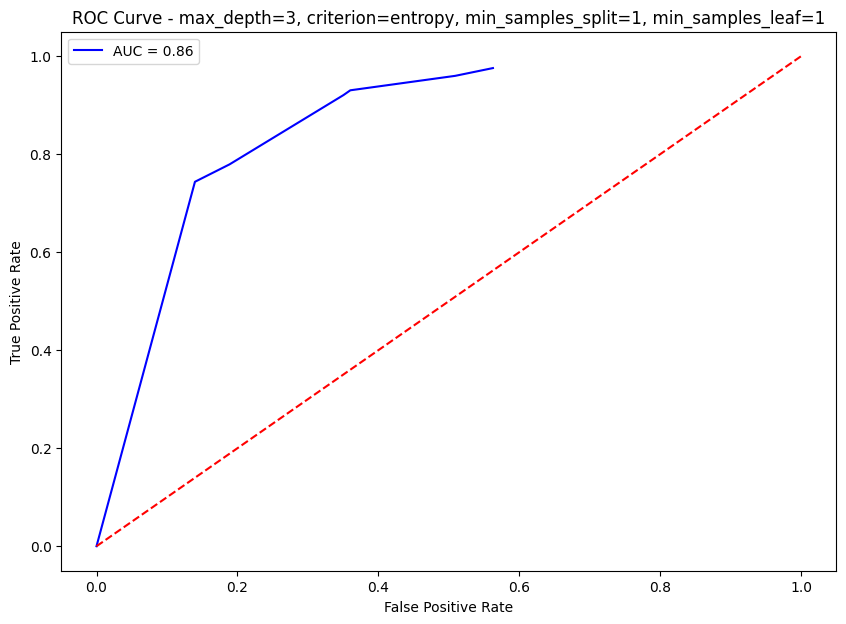

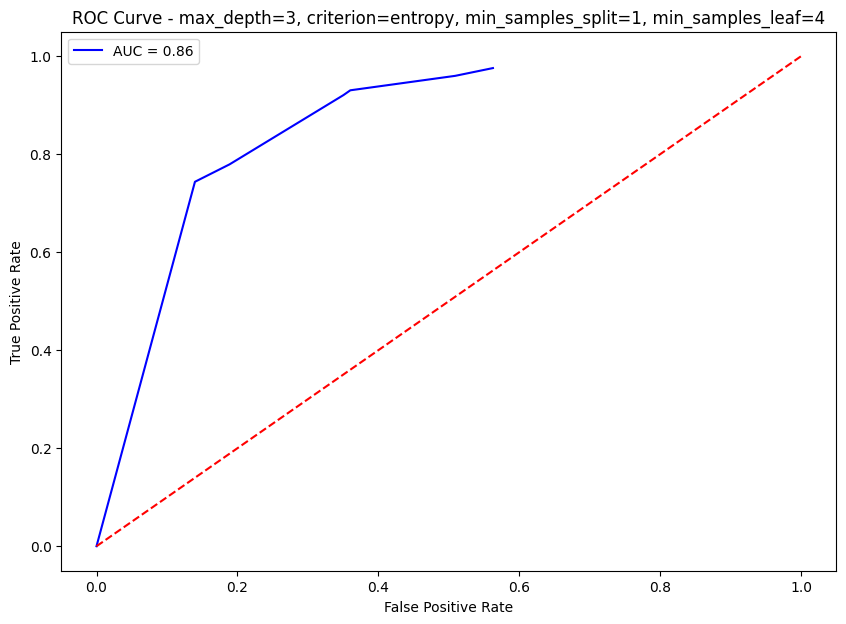

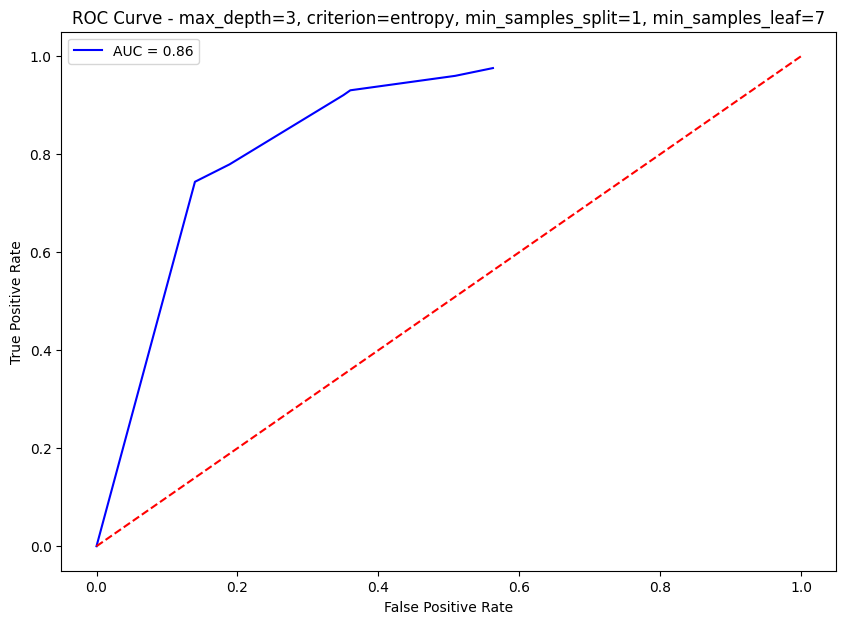

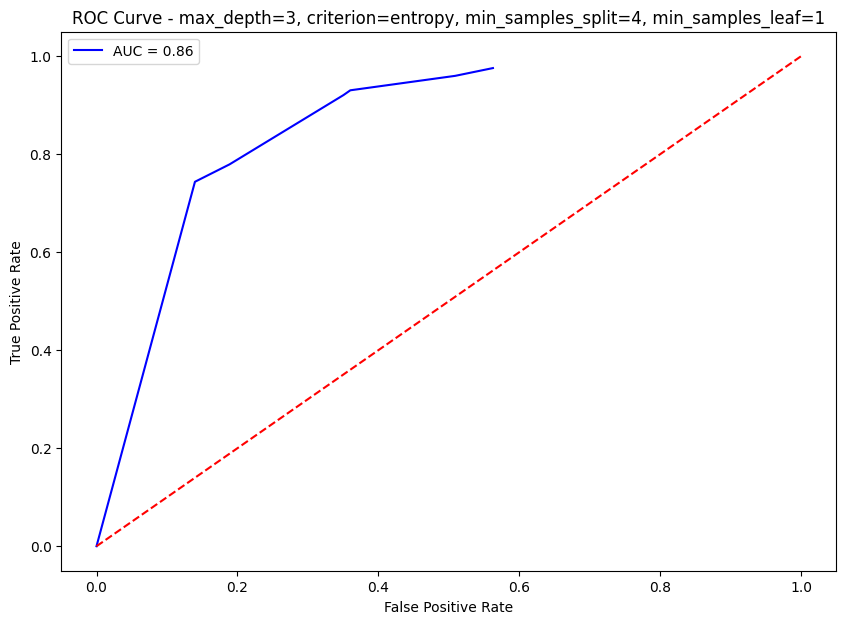

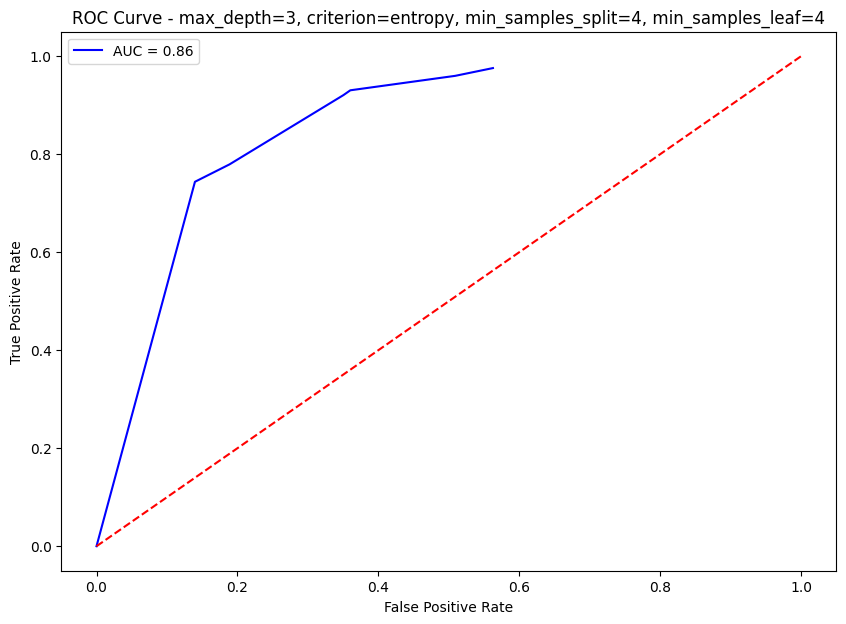

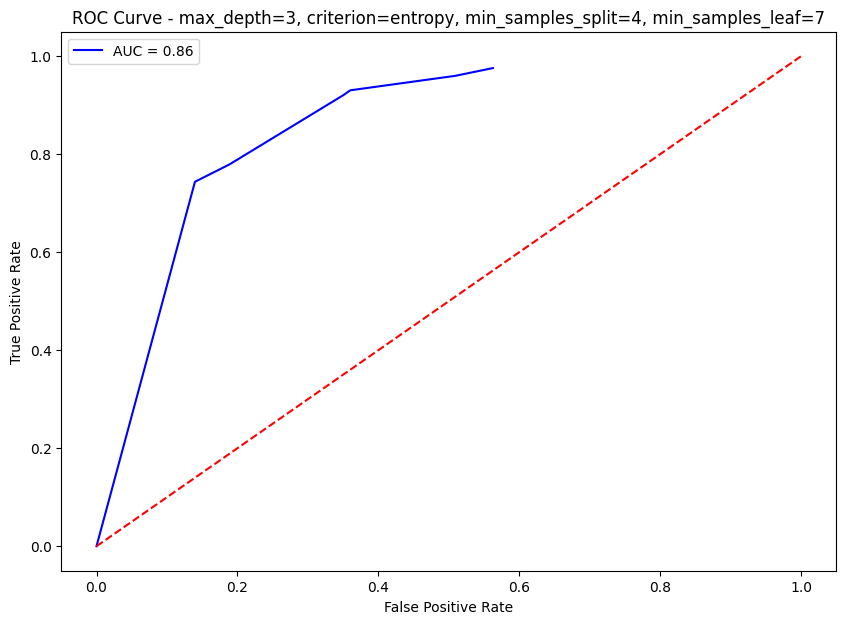

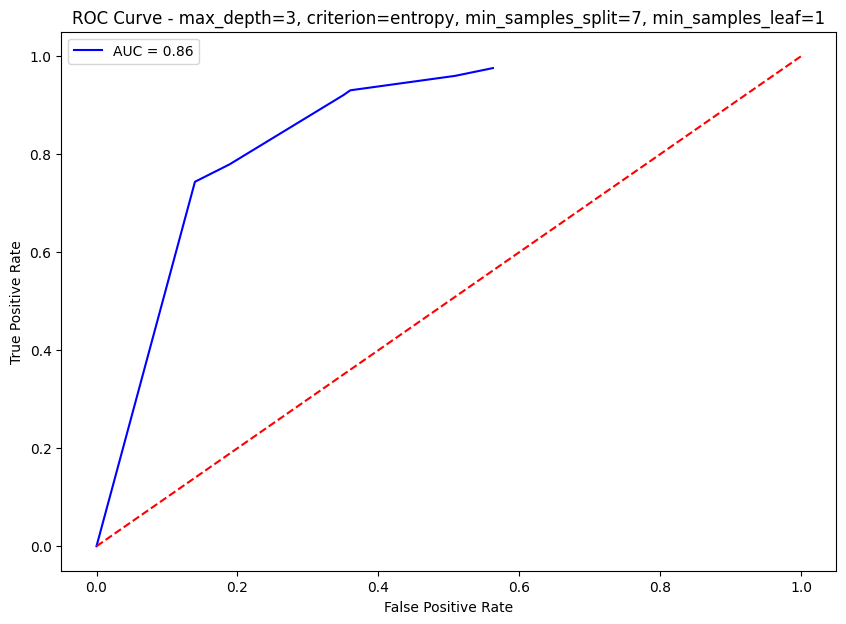

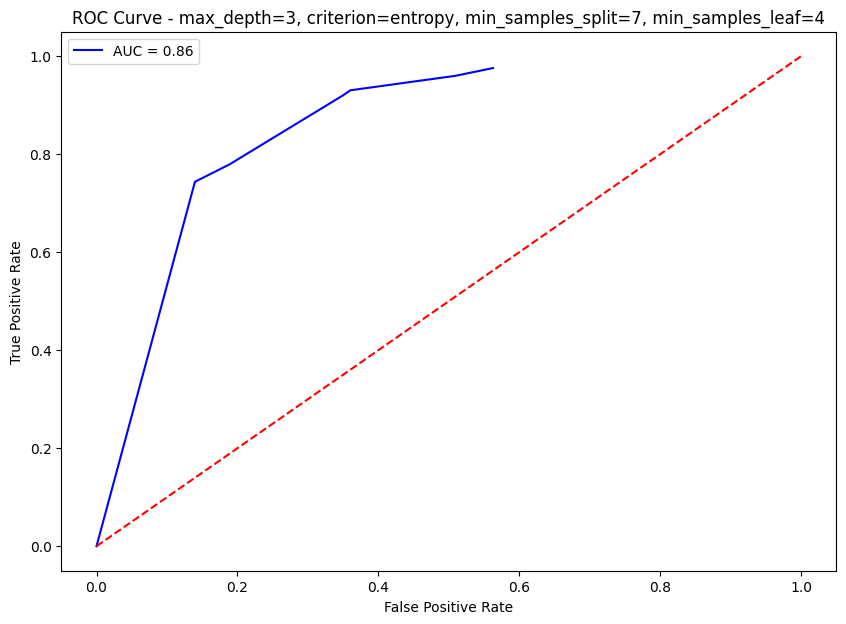

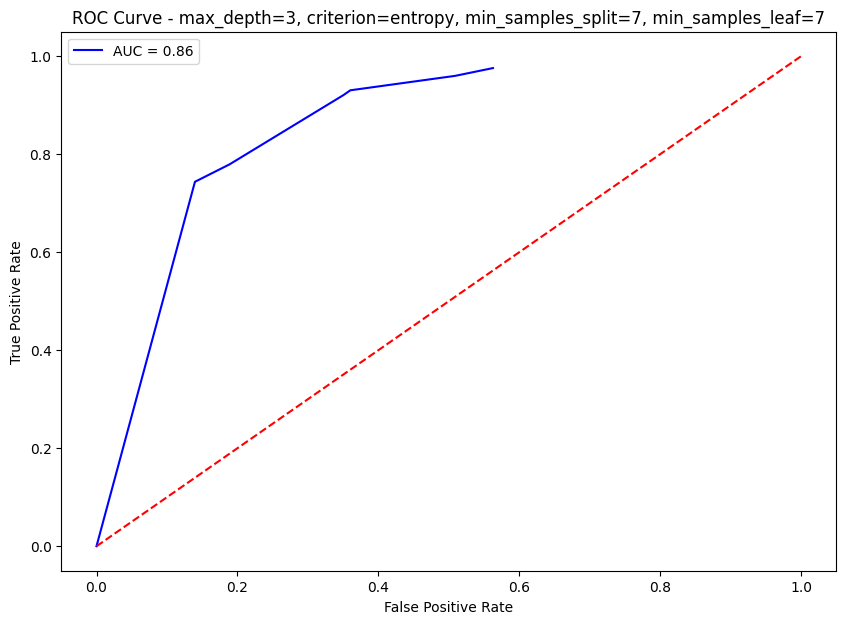

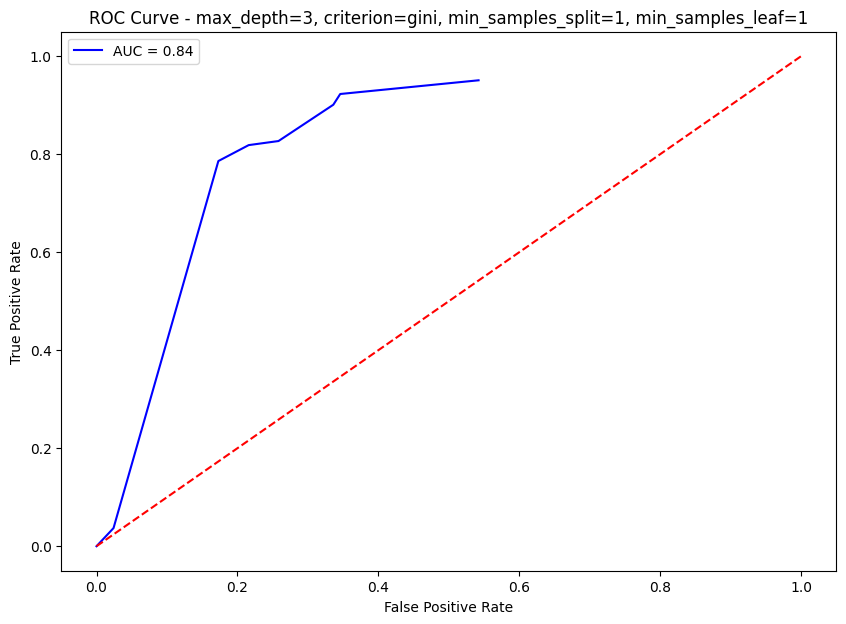

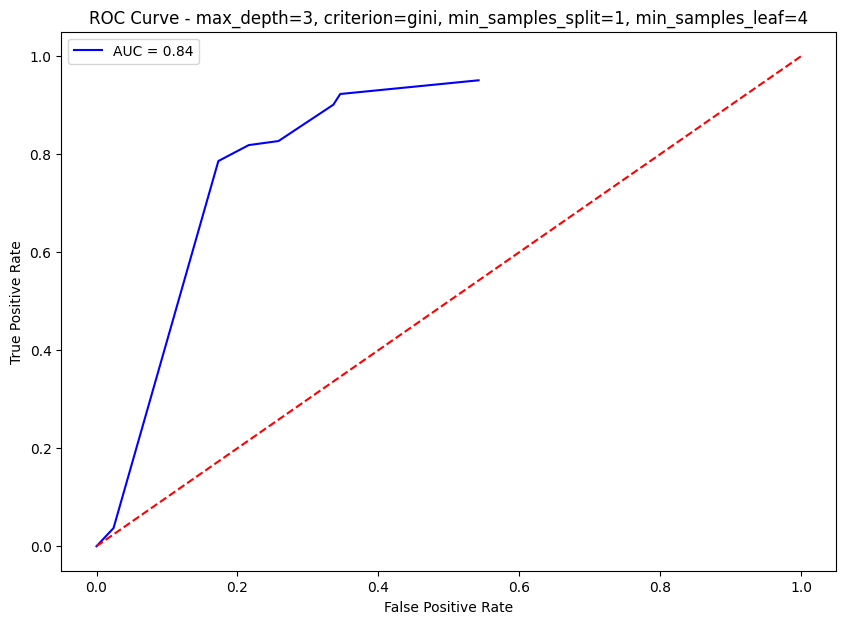

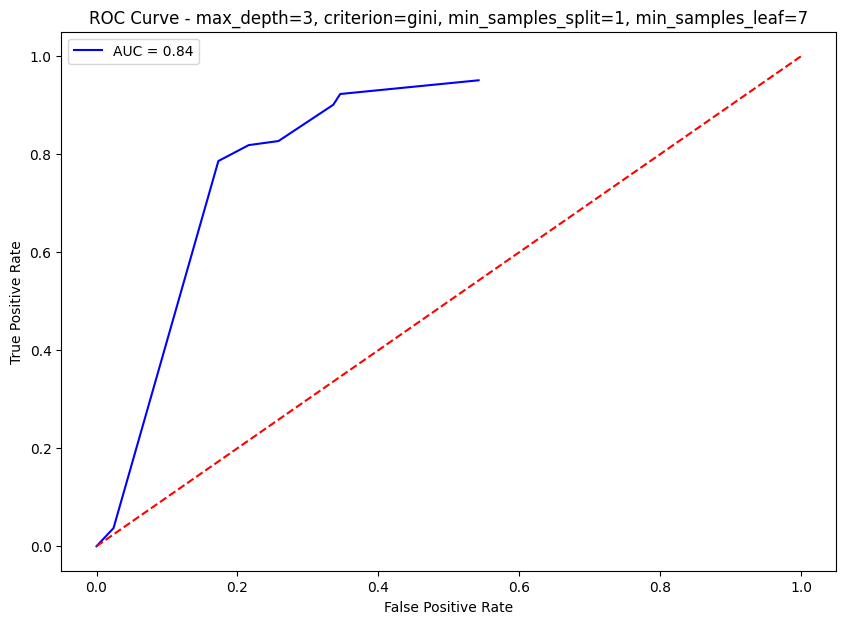

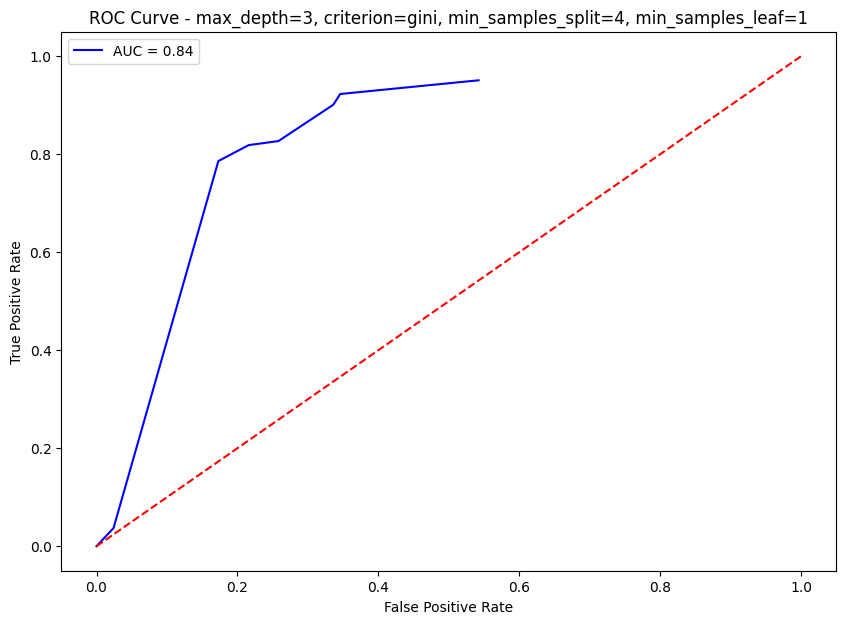

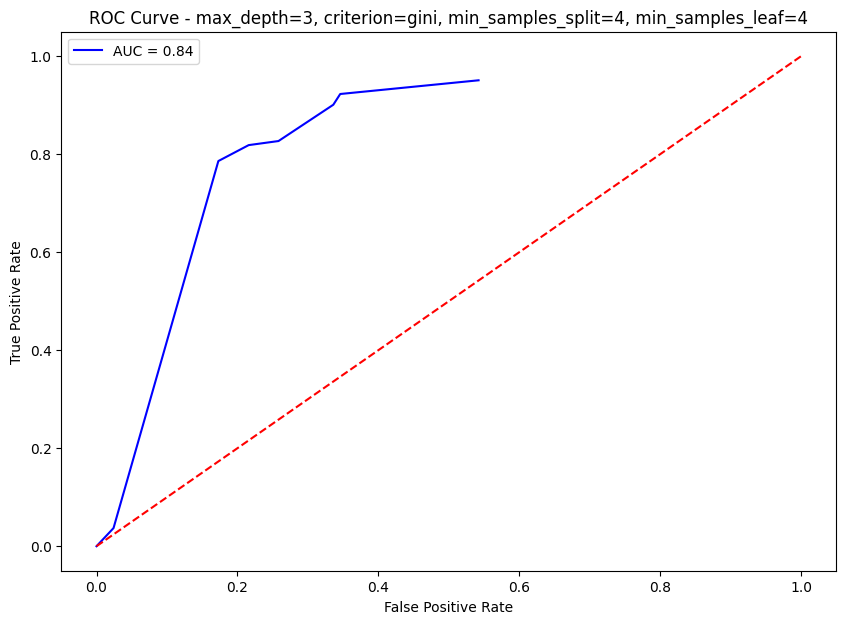

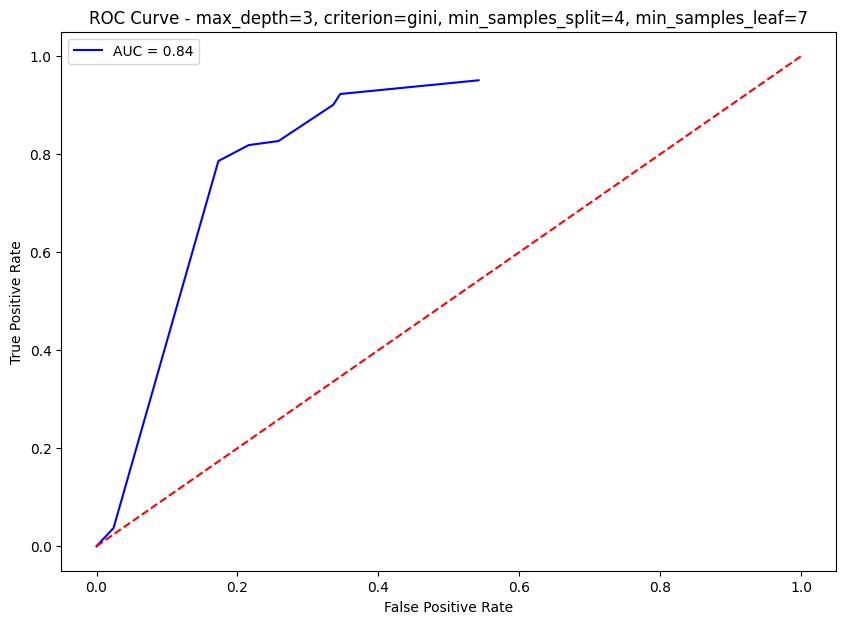

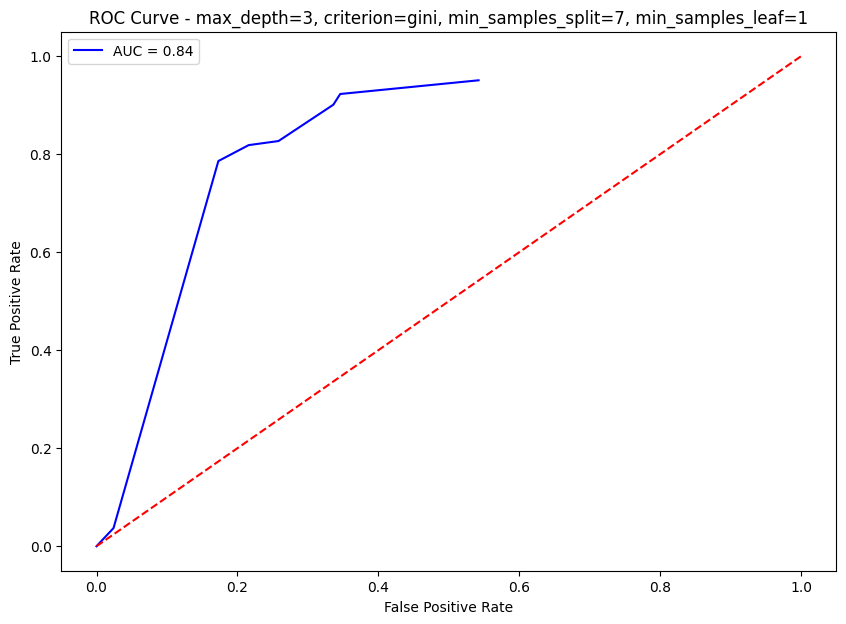

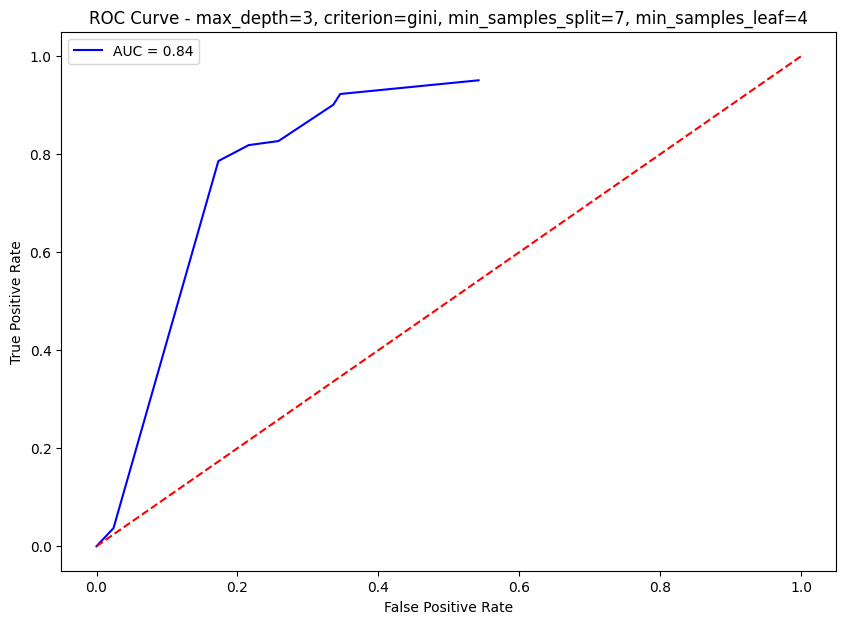

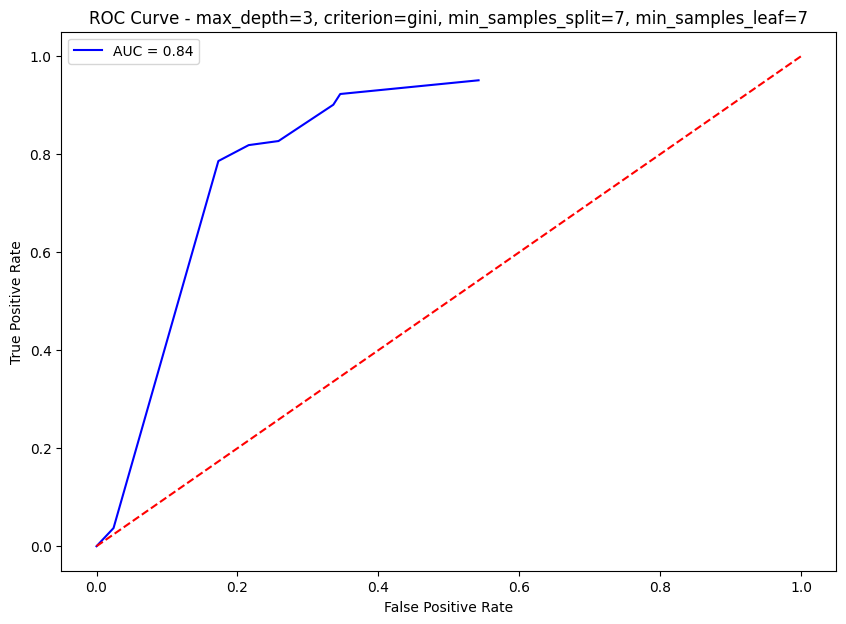

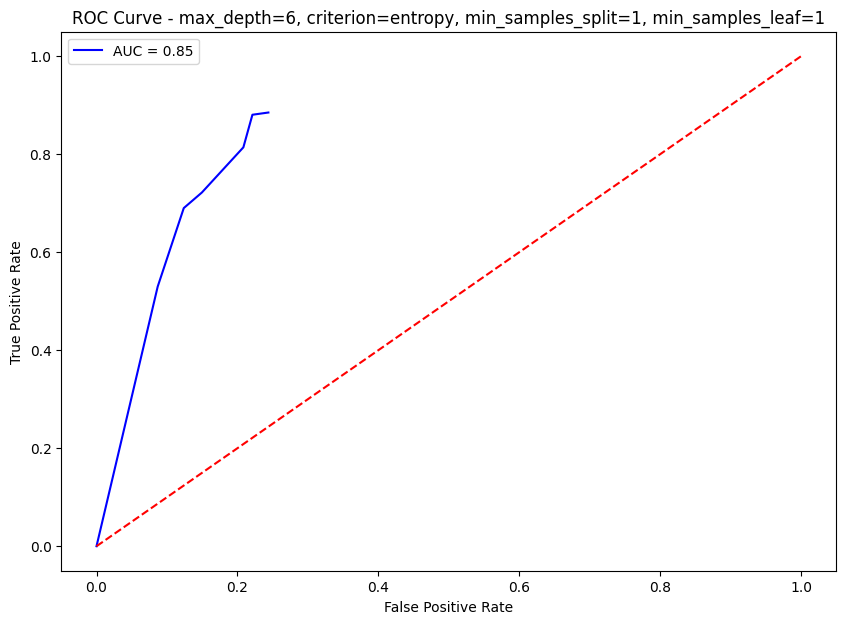

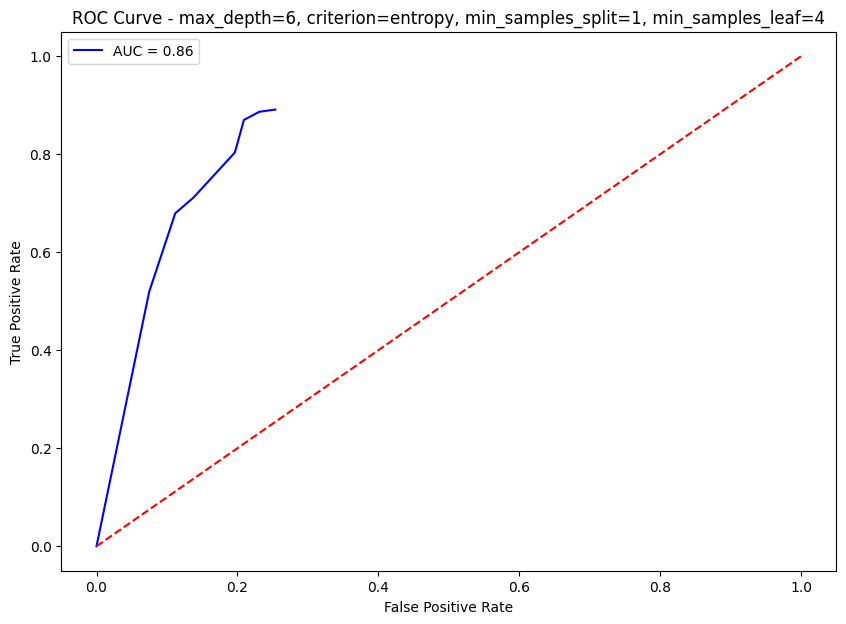

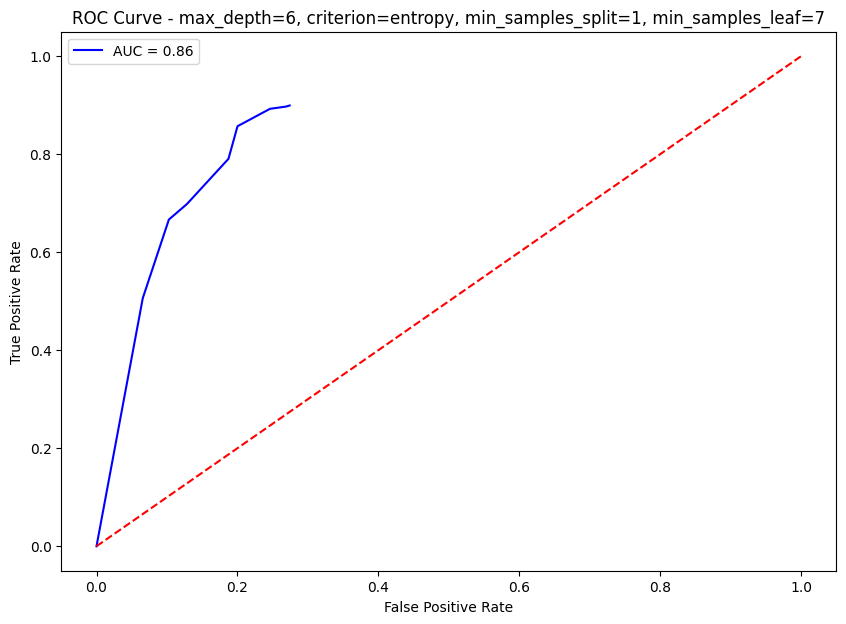

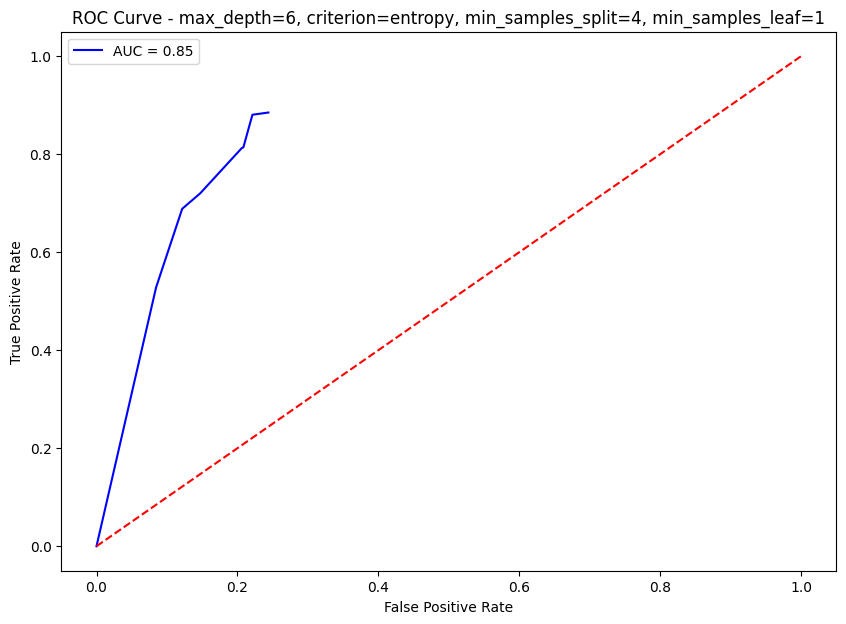

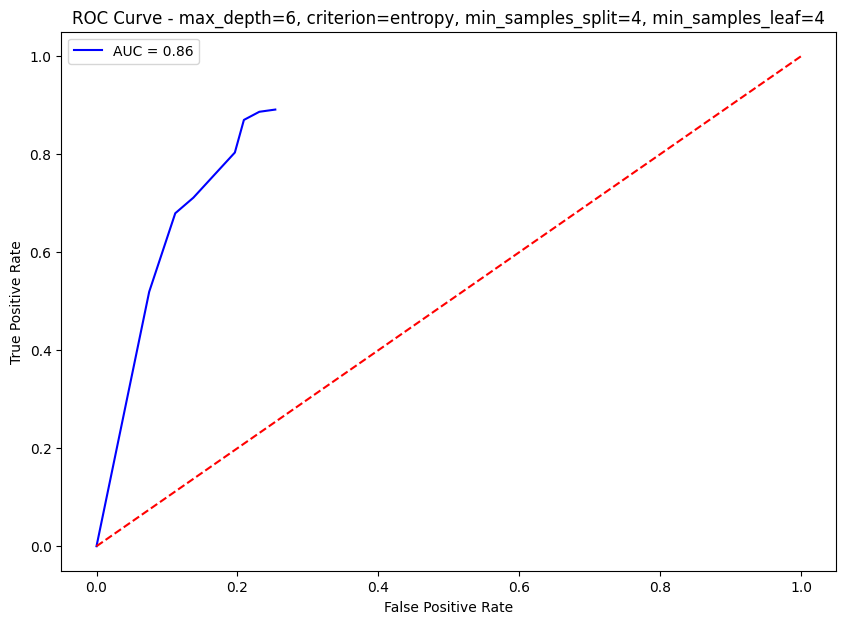

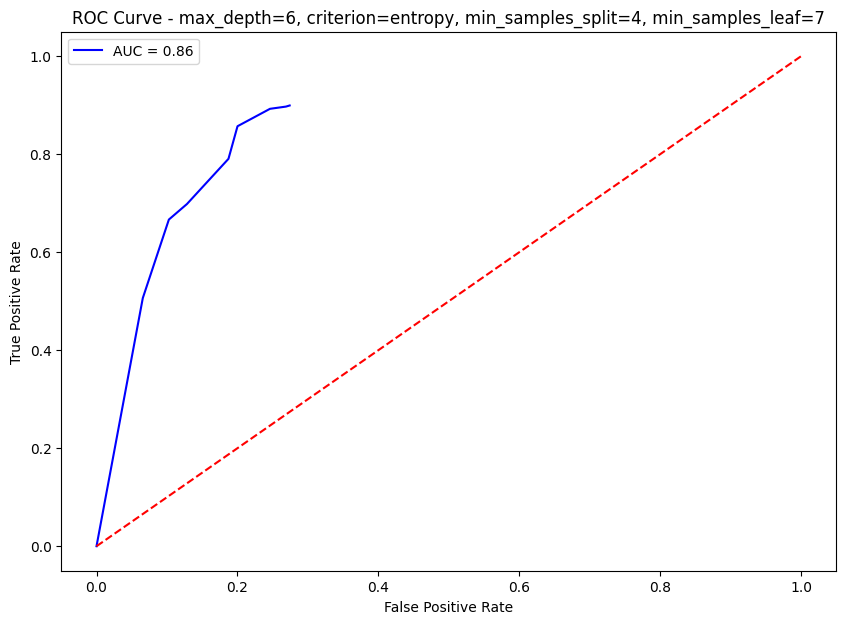

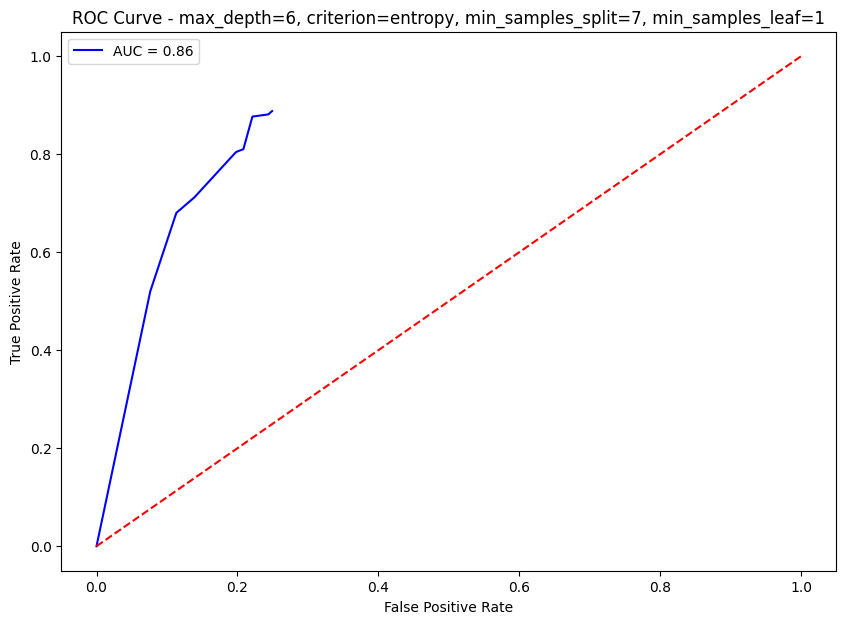

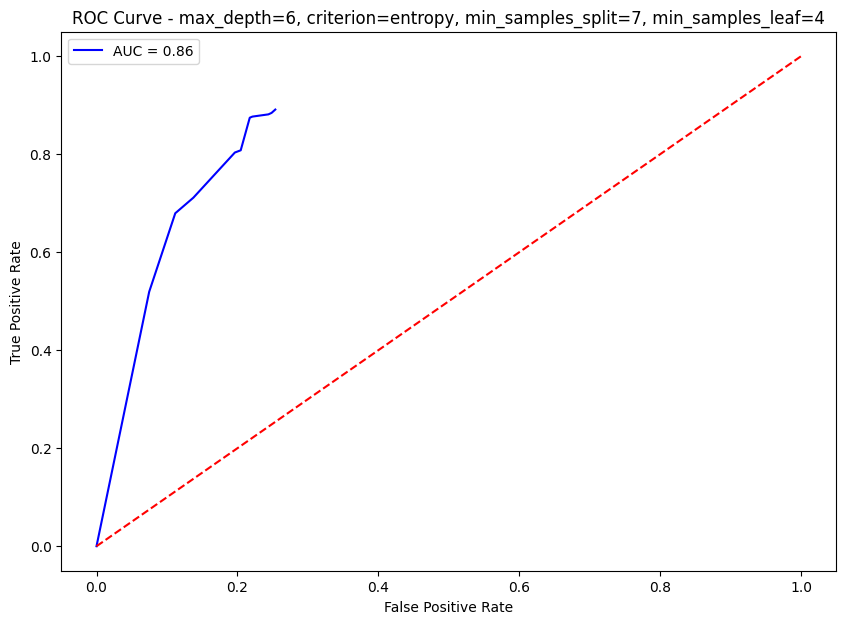

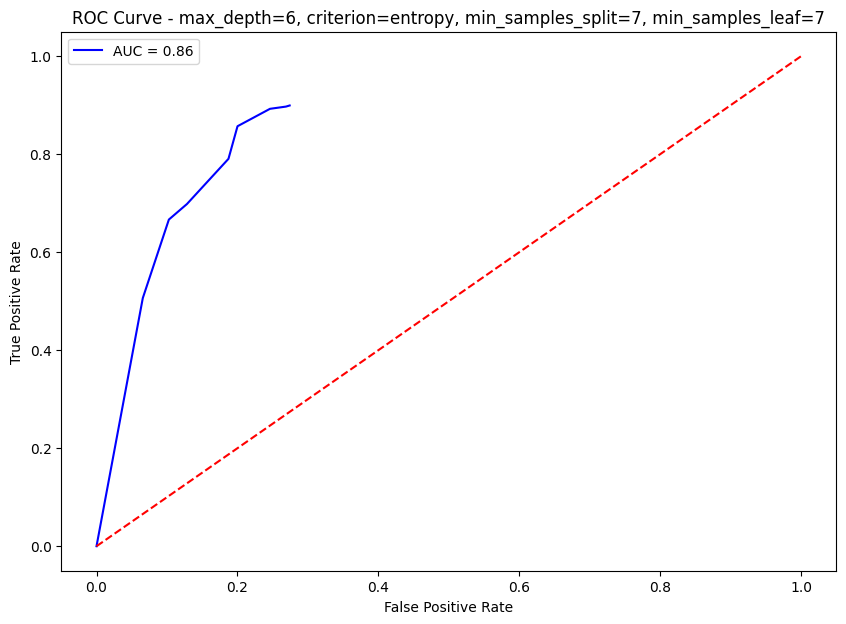

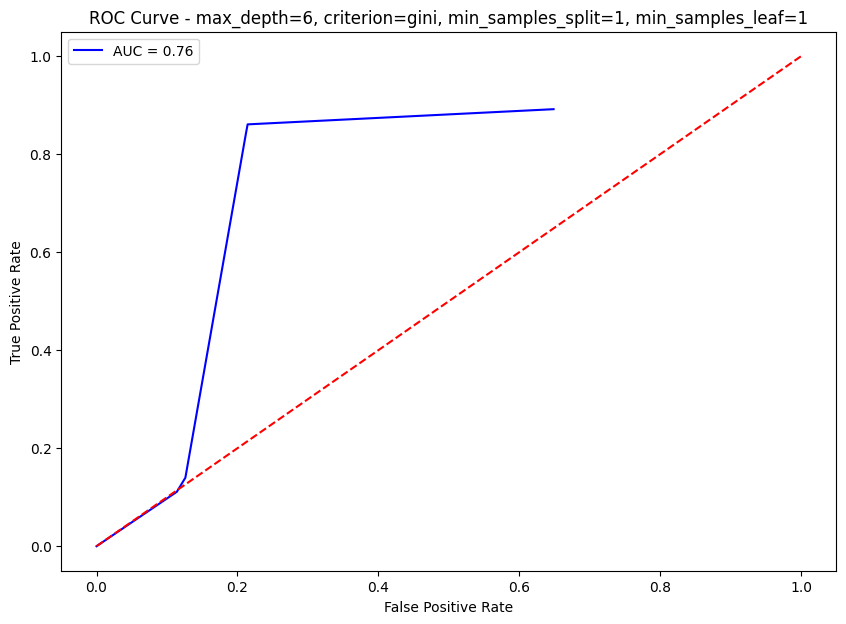

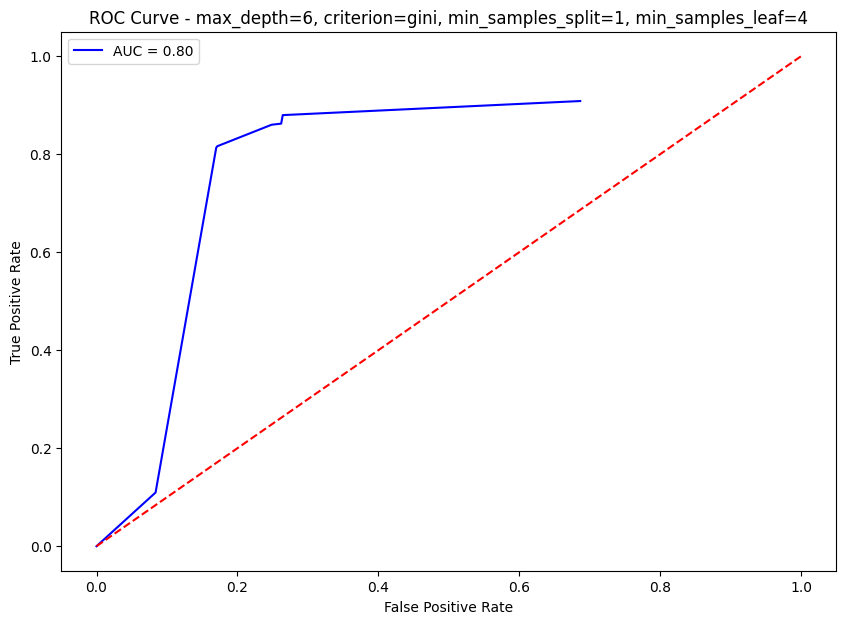

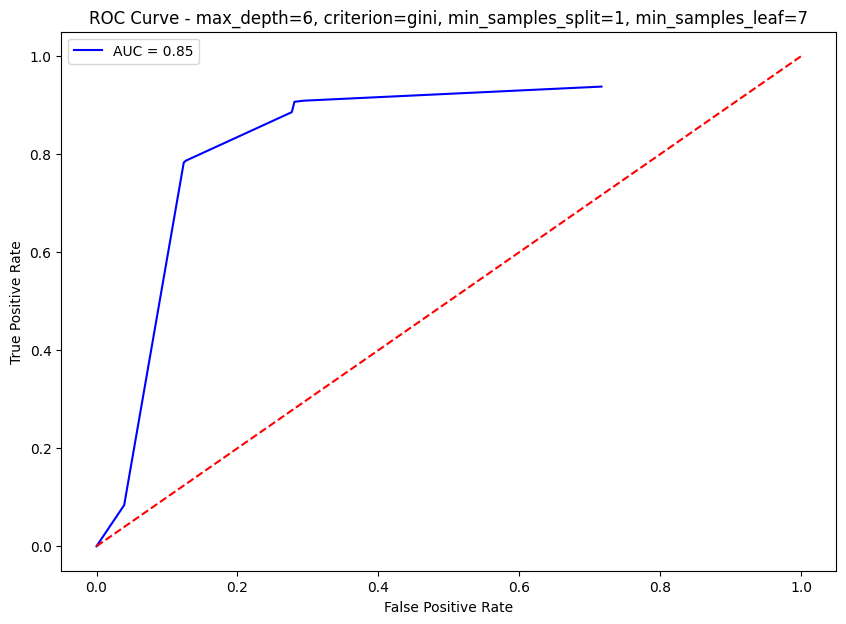

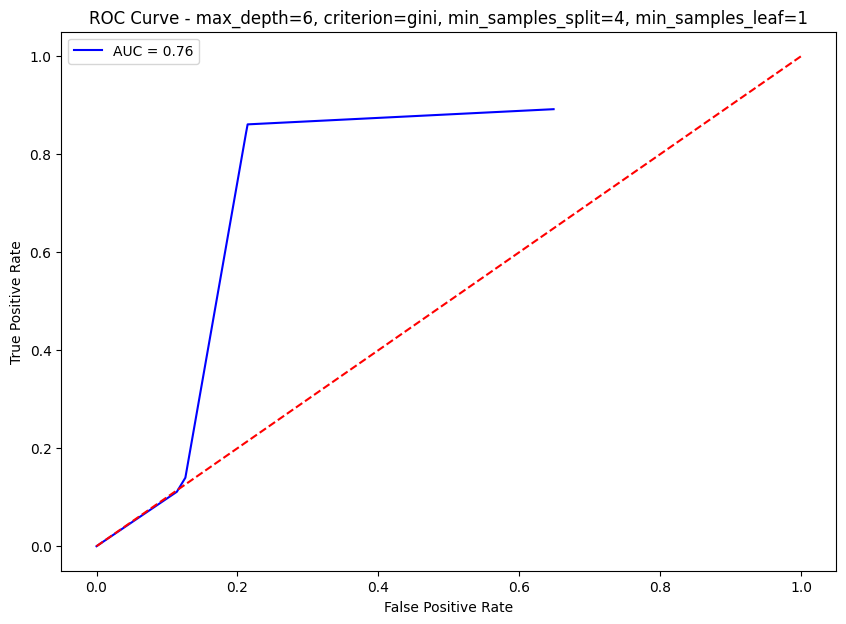

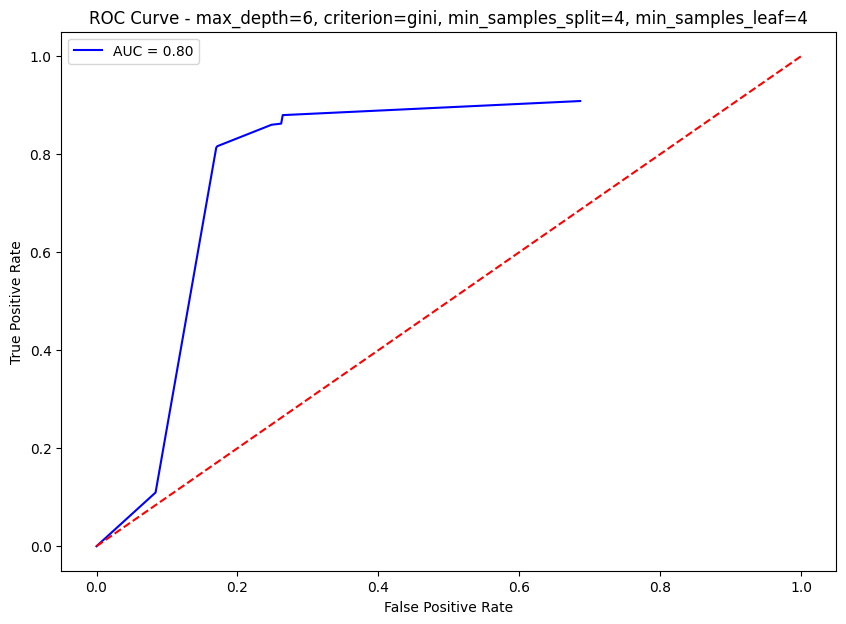

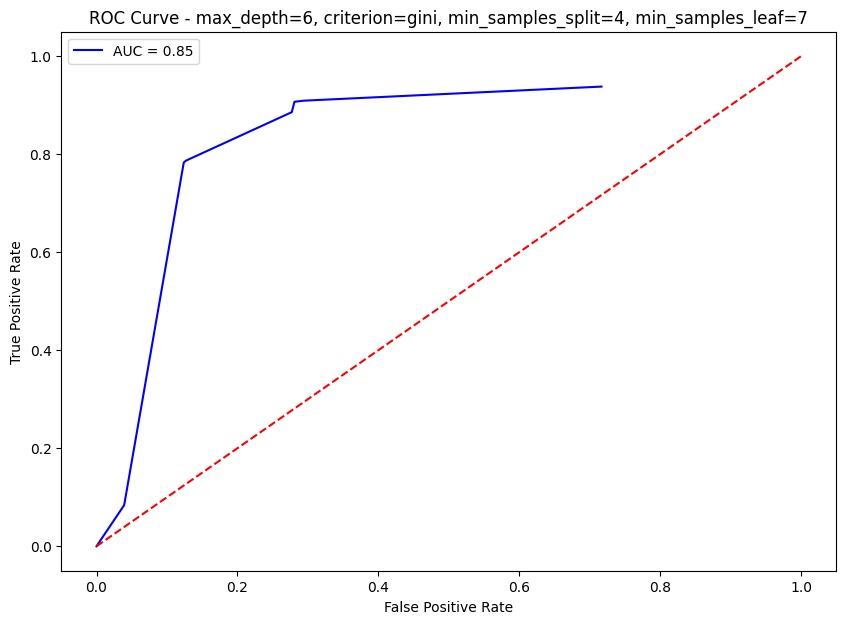

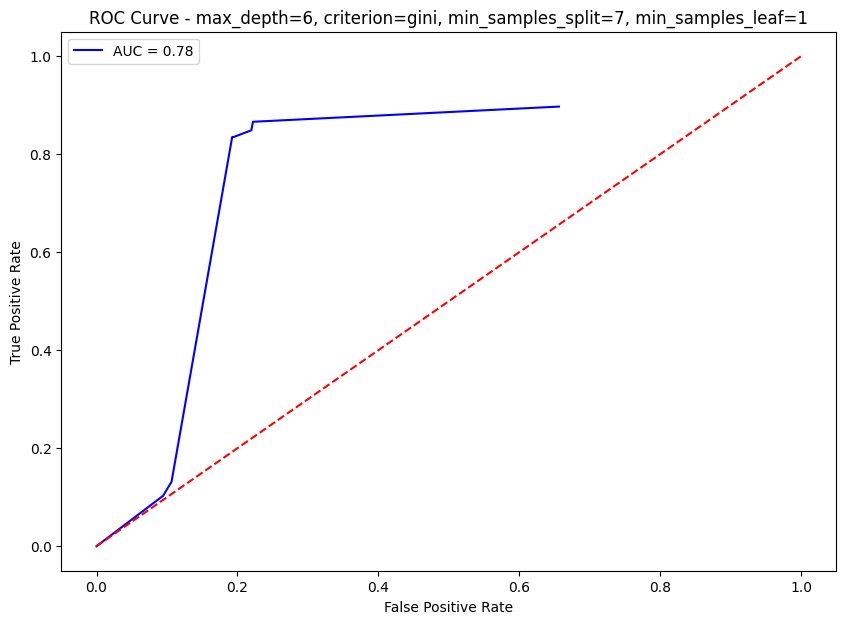

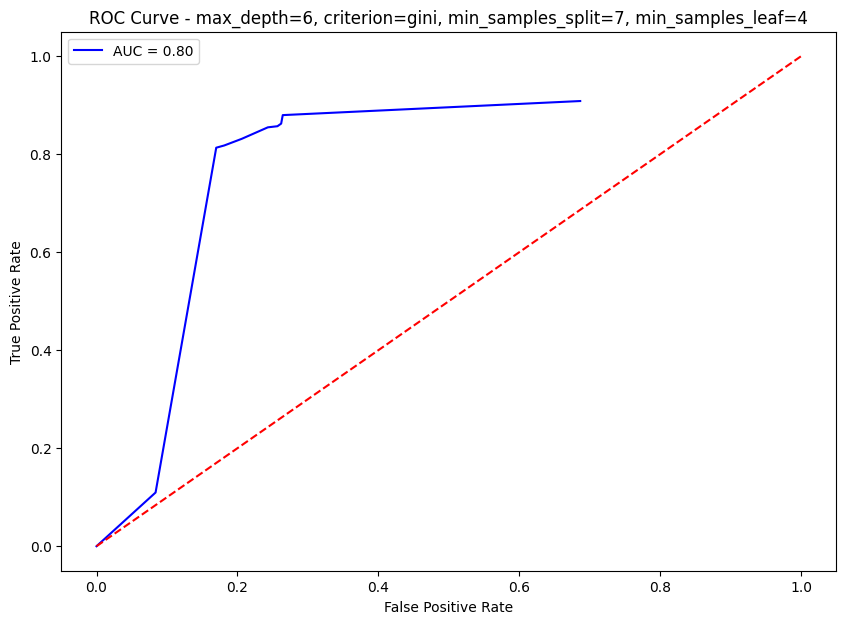

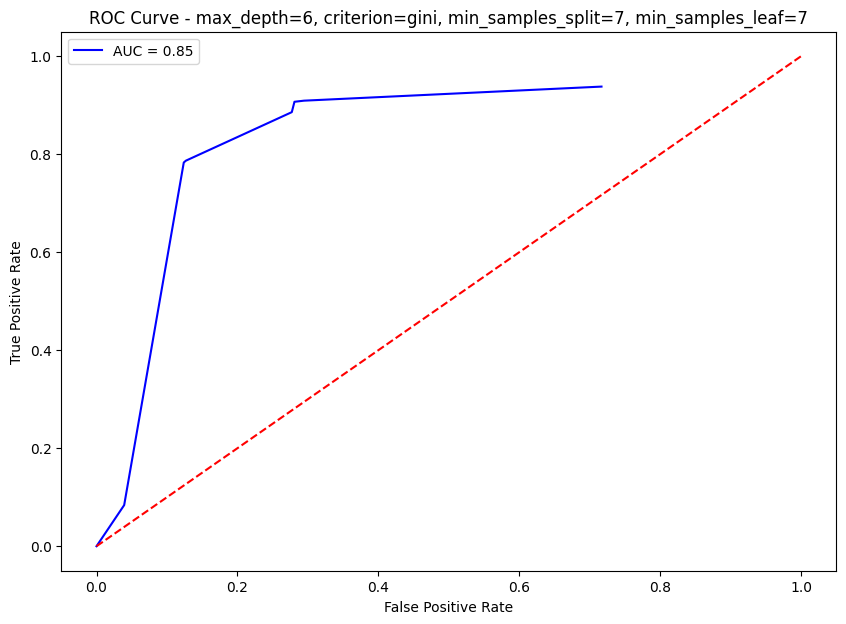

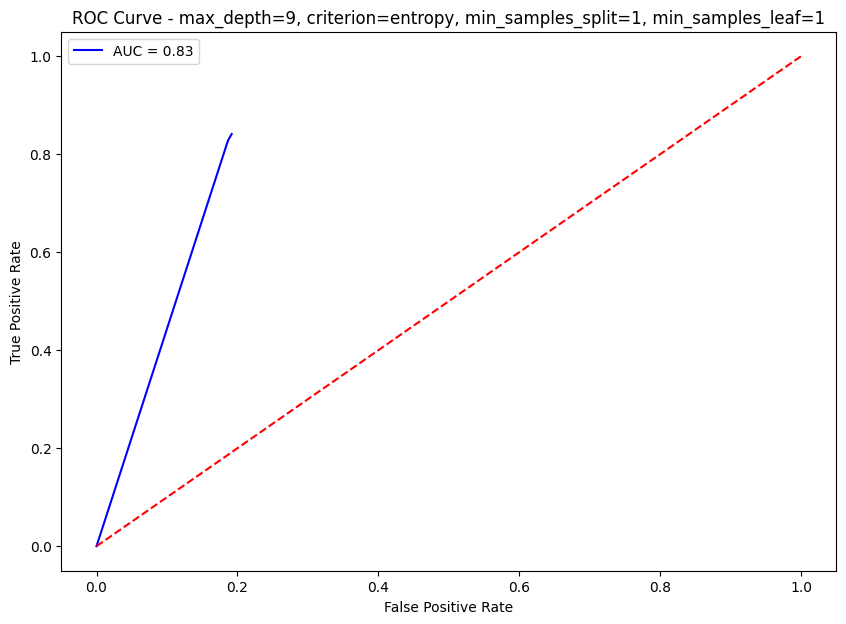

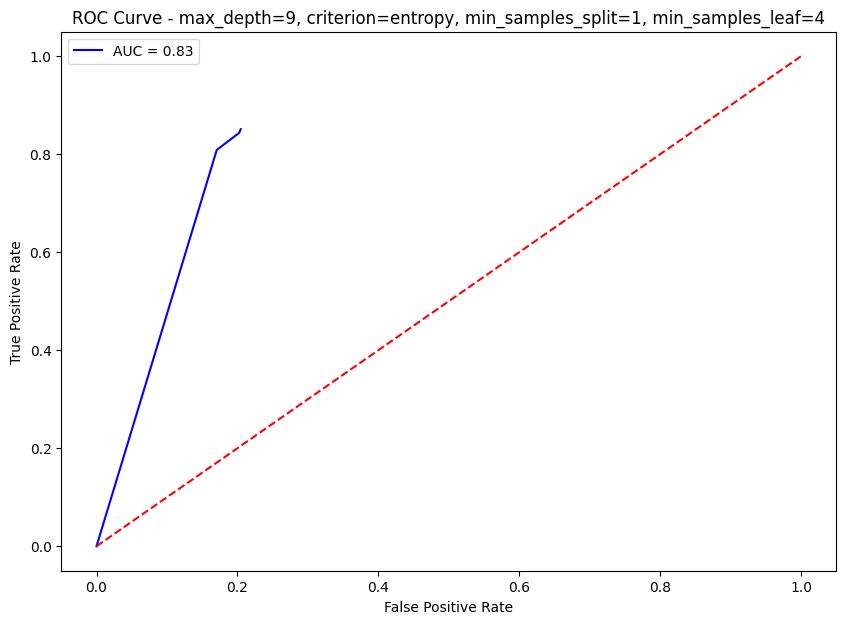

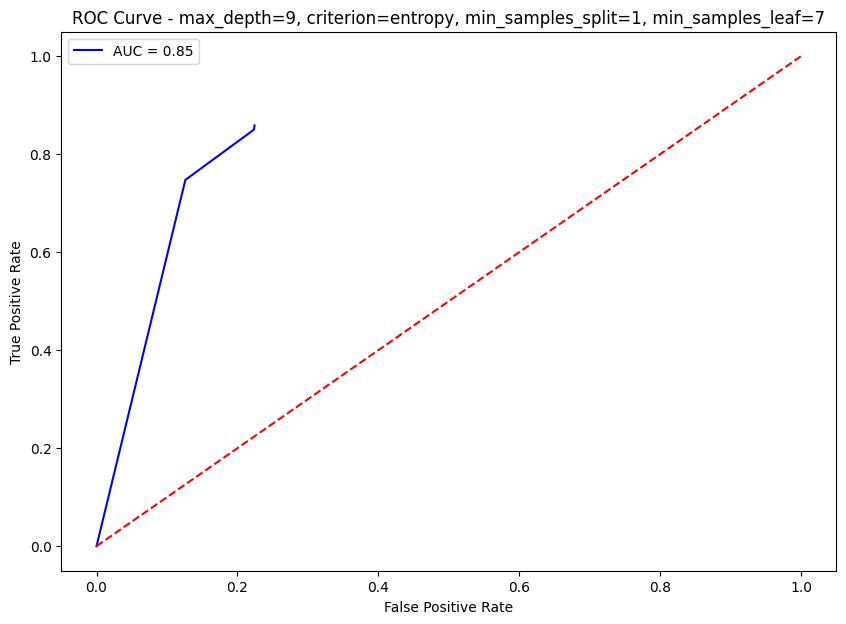

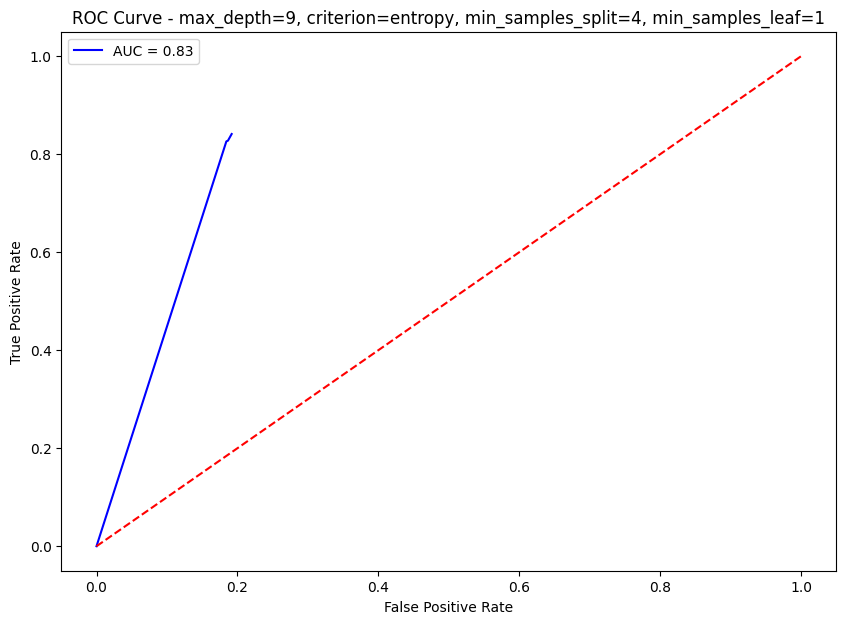

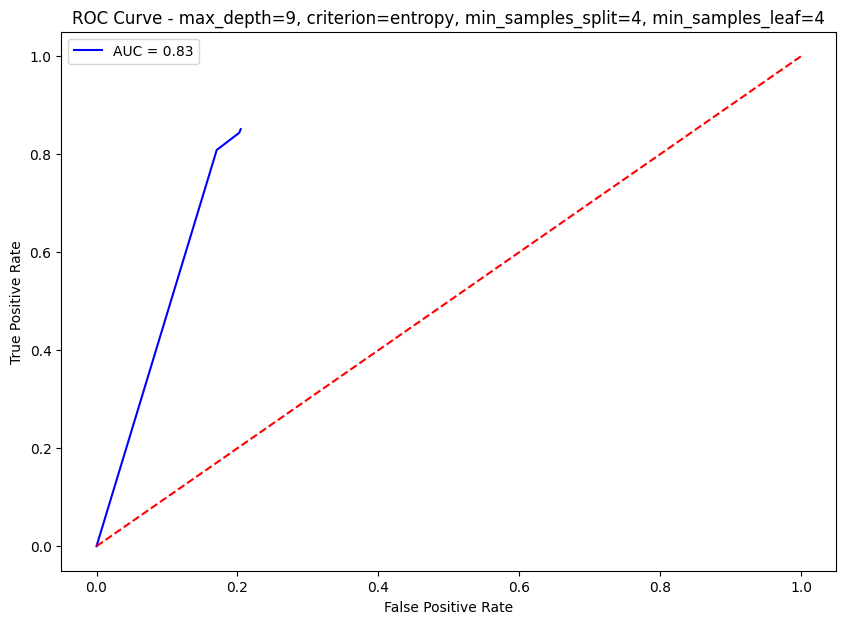

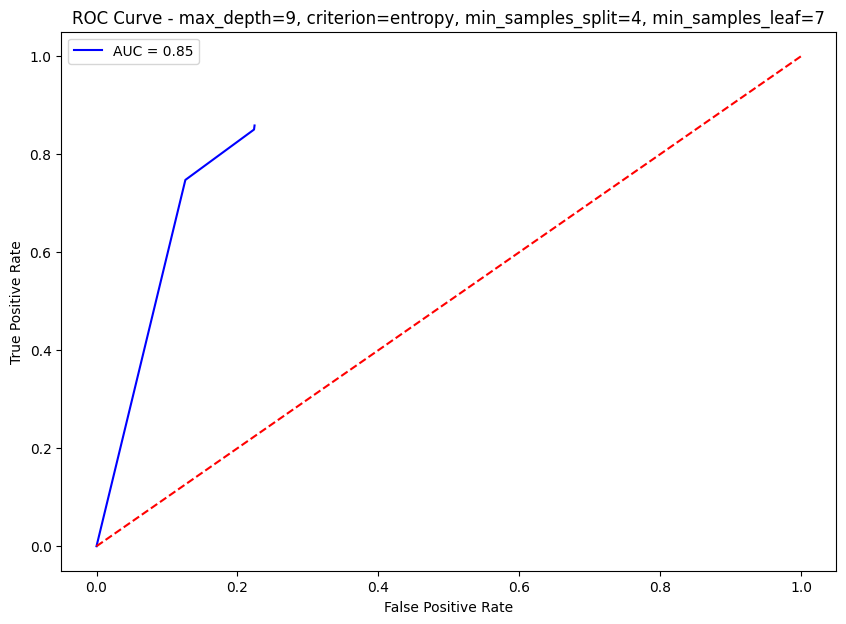

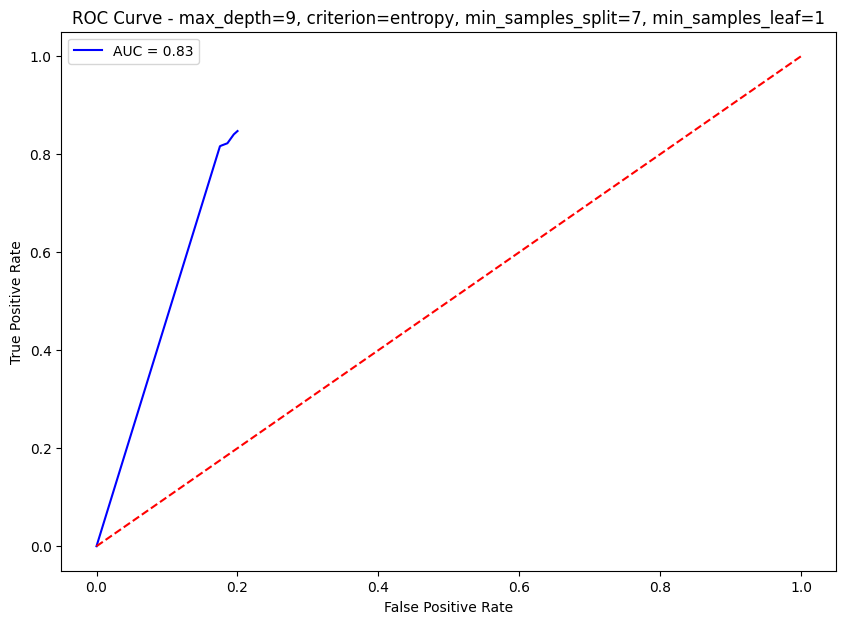

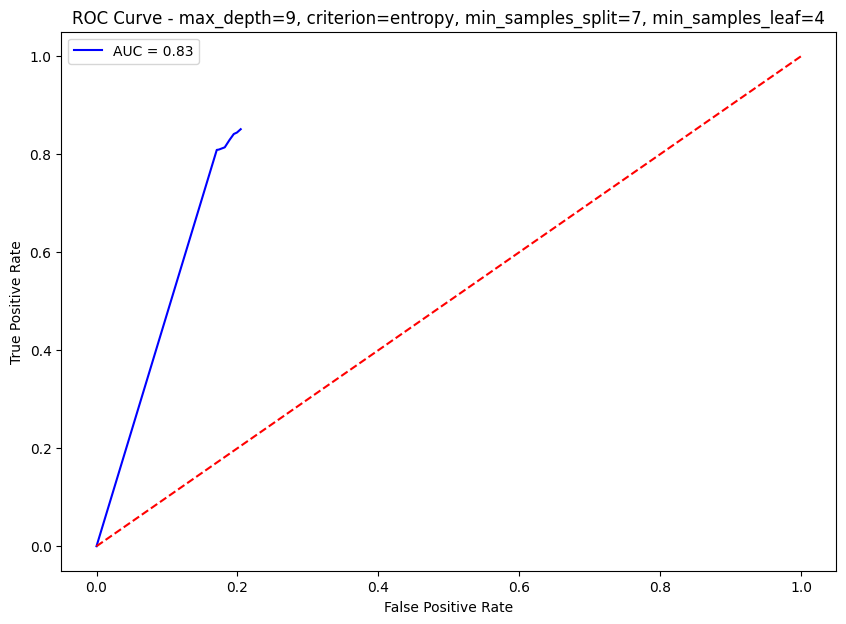

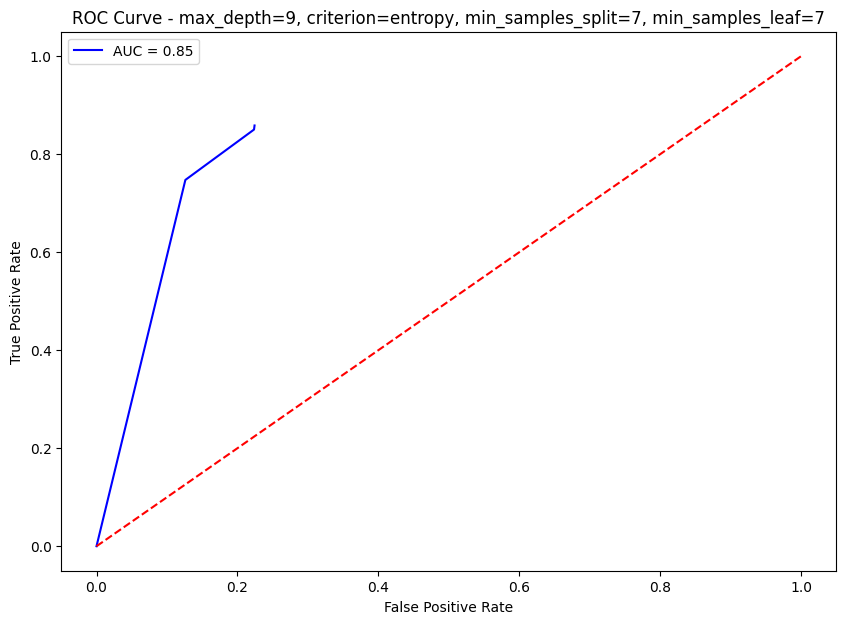

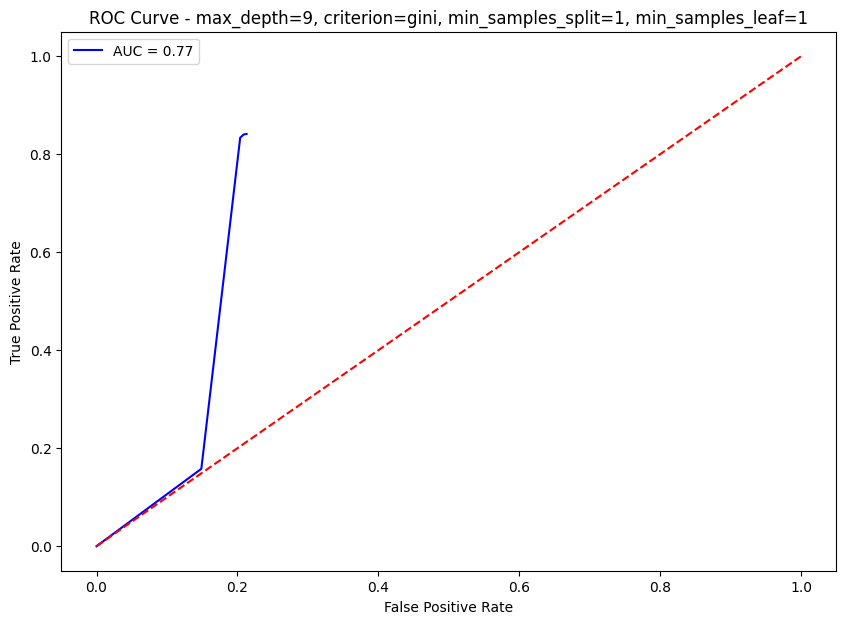

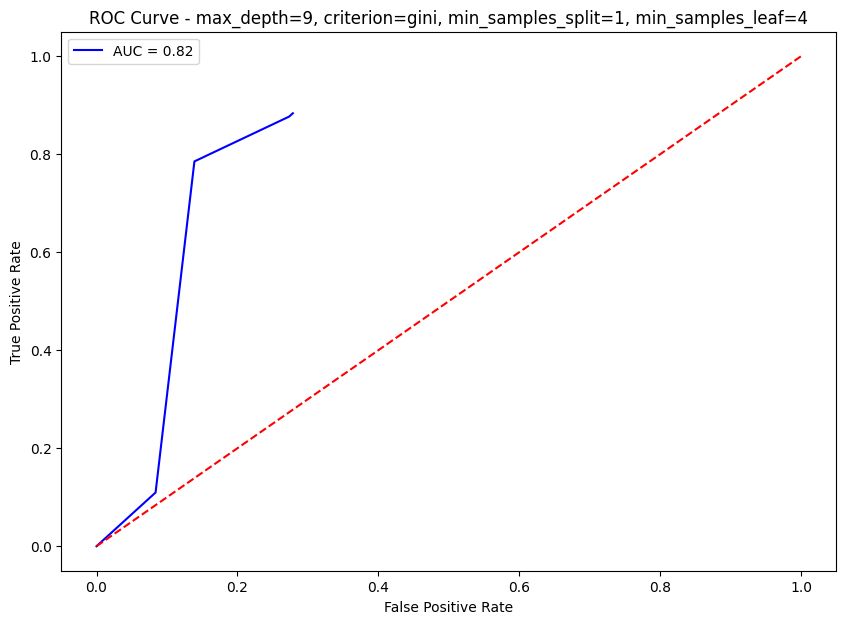

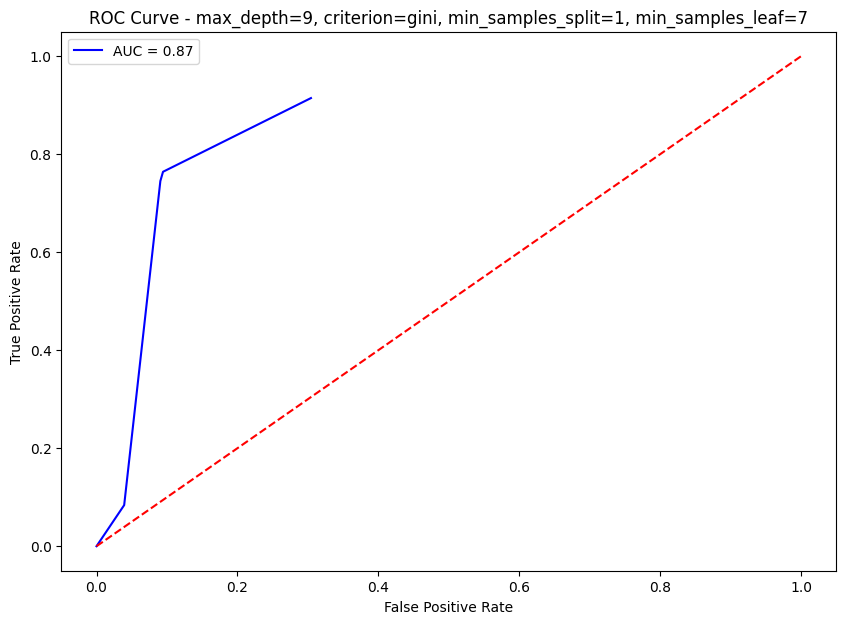

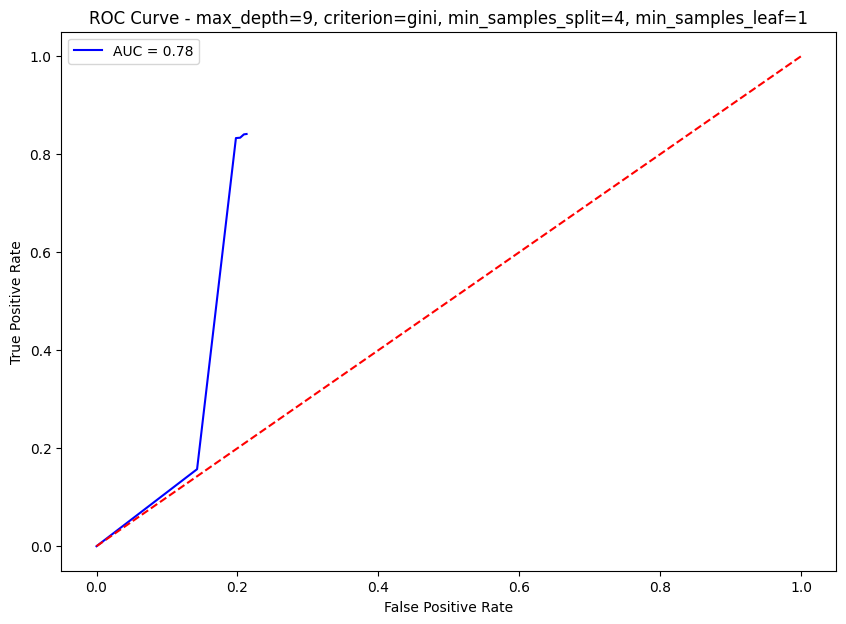

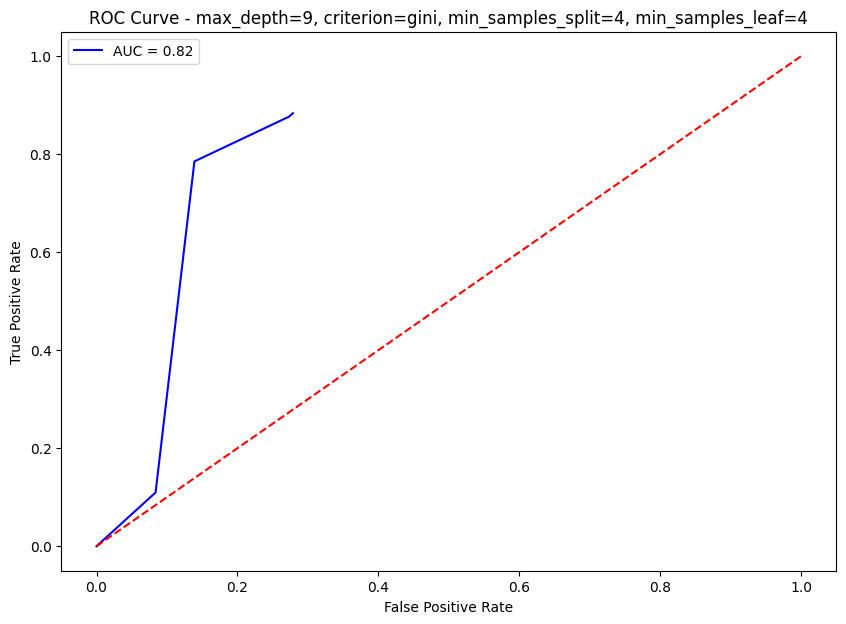

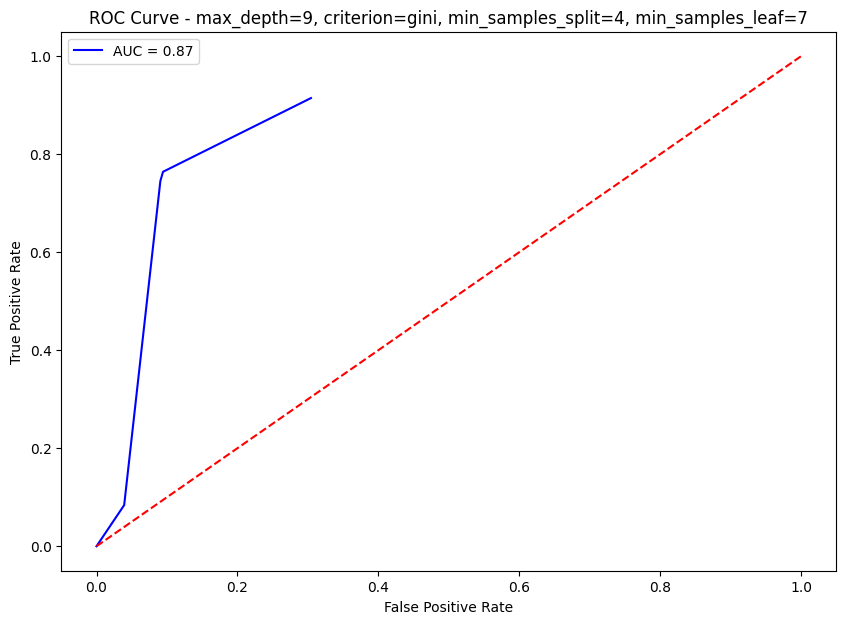

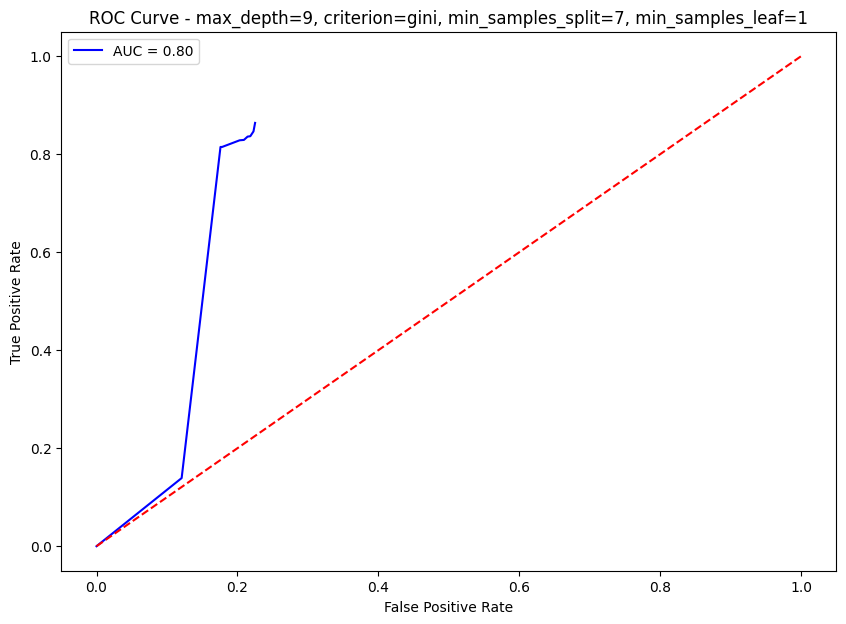

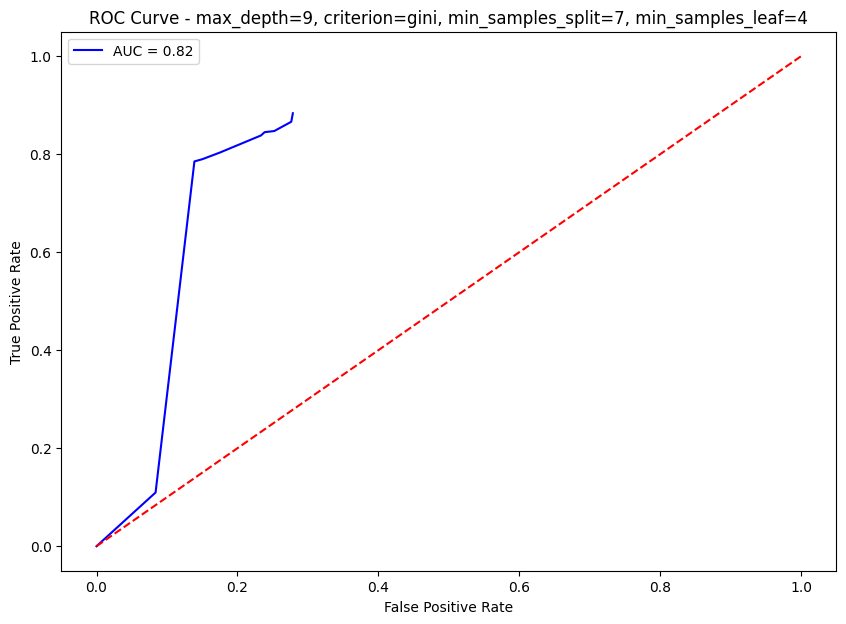

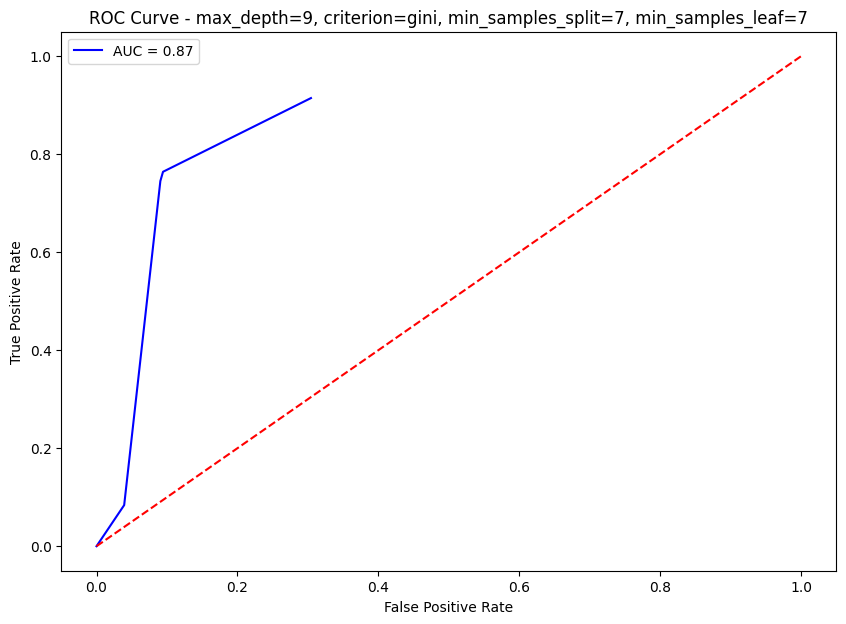

{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 1, 'min_samples_leaf': 1, 'accuracy': 0.7952398942198715, 'precision': 0.804839968774395, 'recall': 0.7792894935752078, 'fpr': 0.18882175226586104, 'balanced_accuracy': 0.7952338706546733, 'roc_auc': 0.8603798014674148}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 1, 'min_samples_leaf': 4, 'accuracy': 0.7952398942198715, 'precision': 0.804839968774395, 'recall': 0.7792894935752078, 'fpr': 0.18882175226586104, 'balanced_accuracy': 0.7952338706546733, 'roc_auc': 0.8603798014674148}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 1, 'min_samples_leaf': 7, 'accuracy': 0.7952398942198715, 'precision': 0.804839968774395, 'recall': 0.7792894935752078, 'fpr': 0.18882175226586104, 'balanced_accuracy': 0.7952338706546733, 'roc_auc': 0.8603798014674148}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 1, 'accuracy': 0.7952398942198715, 'precision': 0.804839968774395, 'r

In [ ]:
# Parámetros para probar
max_depths = [3, 6, 9]
criterions = ["entropy", "gini"]
min_samples_splits = [1, 4, 7]
min_samples_leaves = [1, 4, 7]

# Invocamos la función
results = evaluate_tree_hyperparameters(X_train_hog_reducido, y_train_hog_arboles, X_val_hog, y_val_hog_arboles, max_depths, criterions, min_samples_splits, min_samples_leaves)
for res in results:
    print(res)

### Árbol de decisión usando Haar features

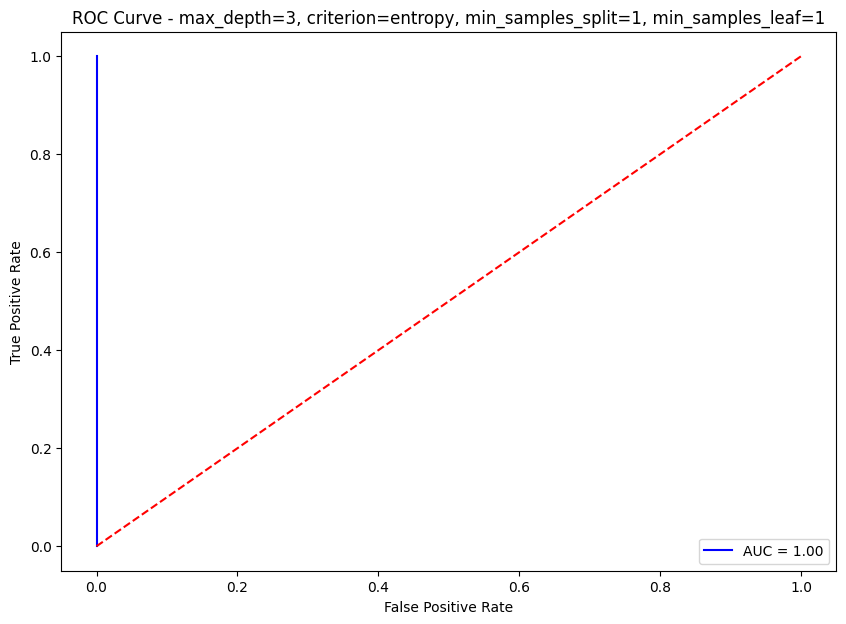

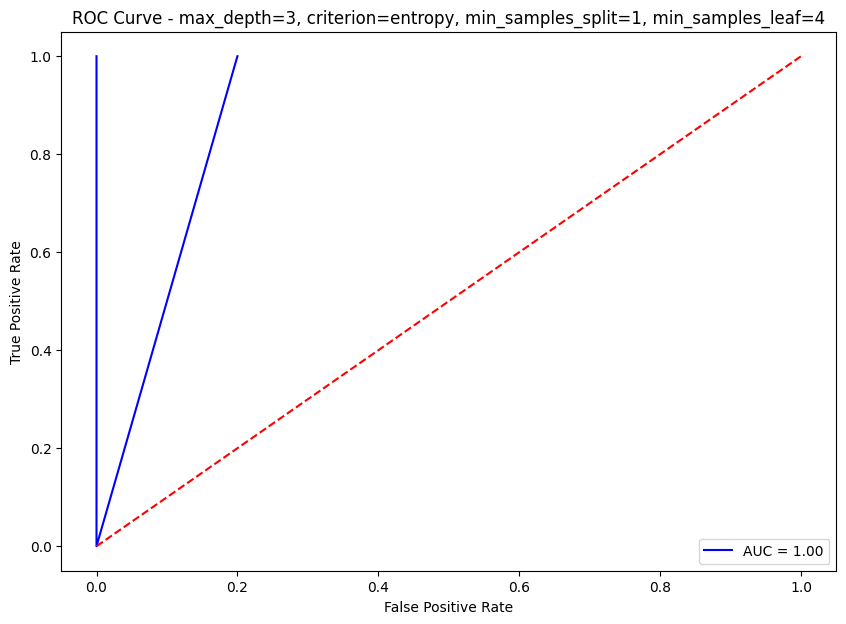

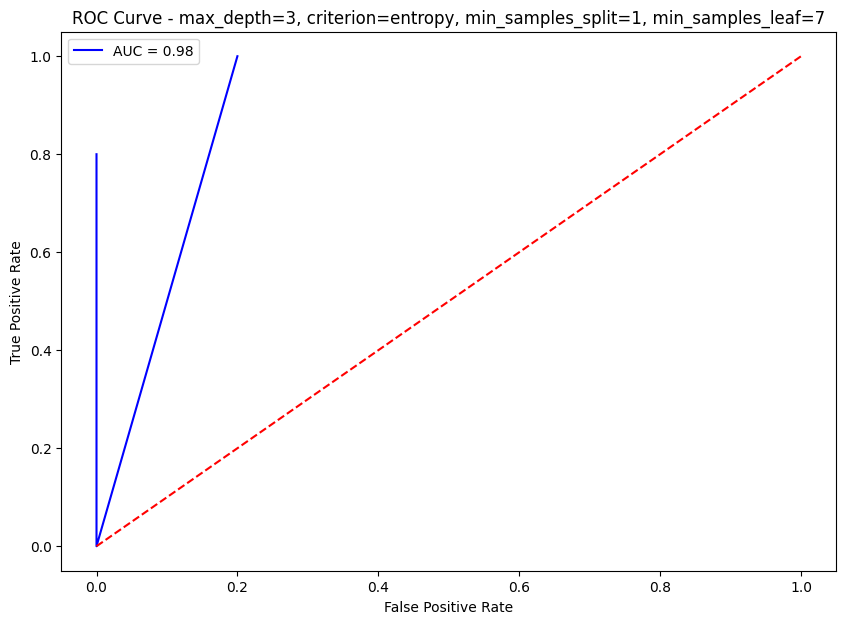

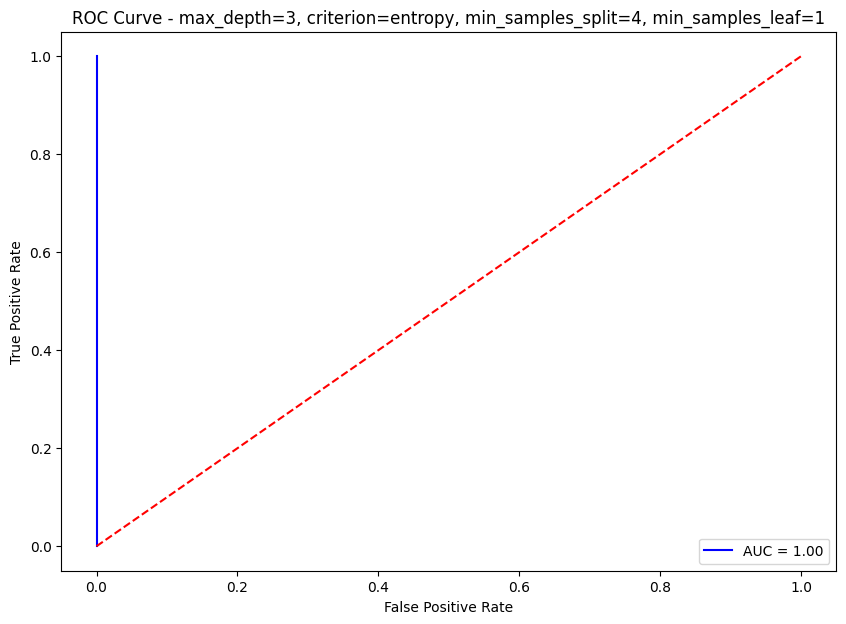

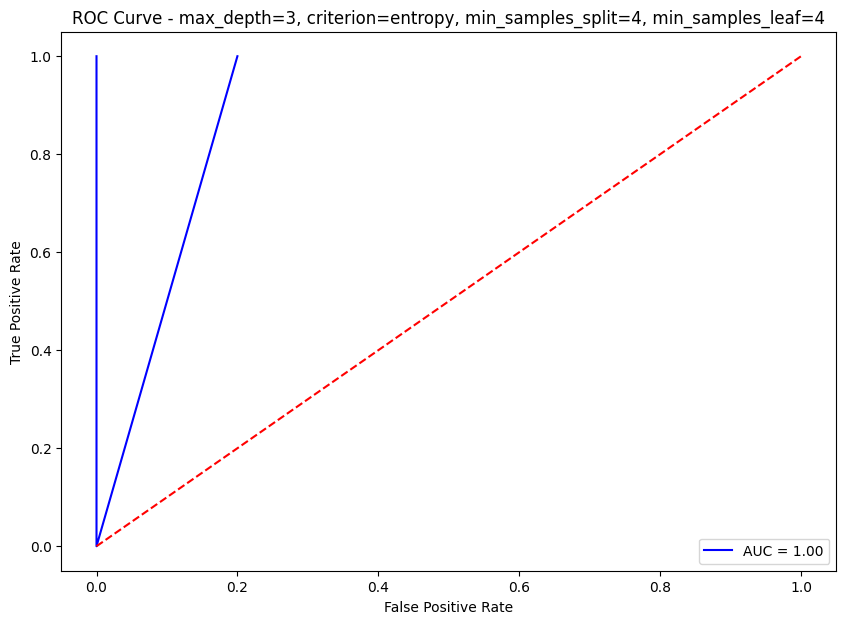

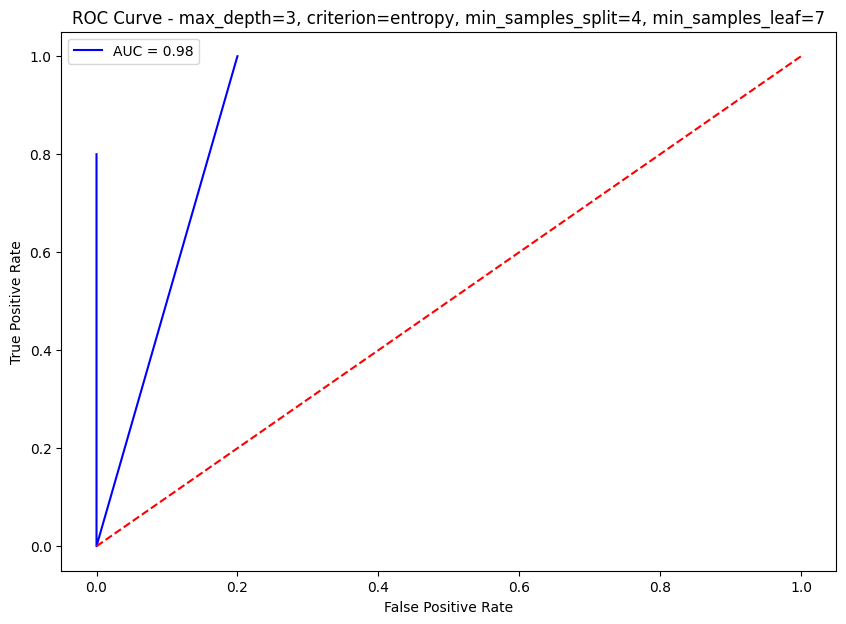

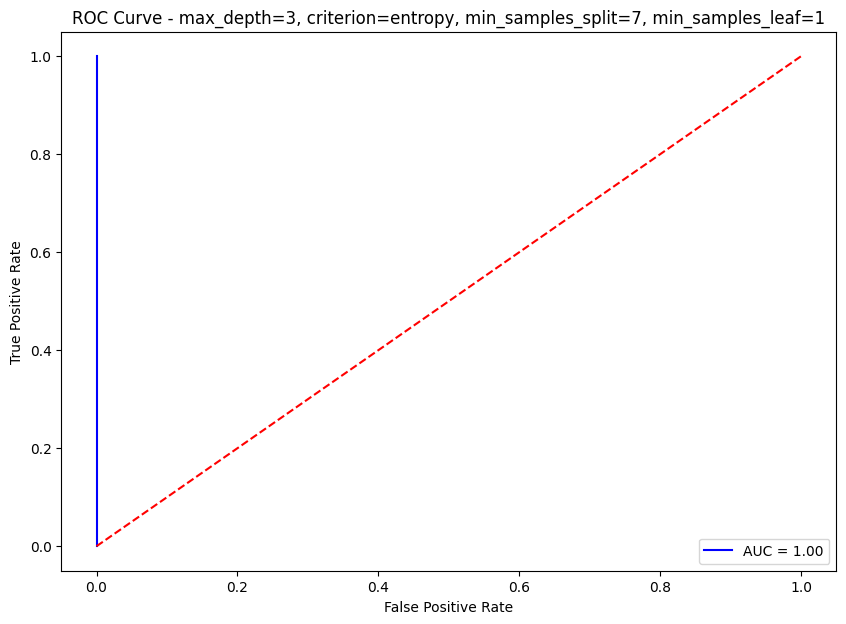

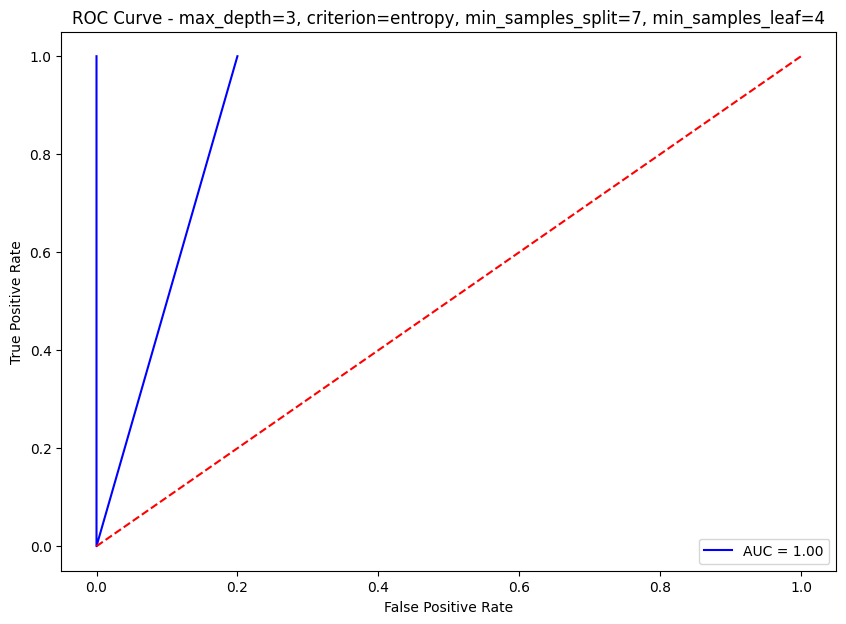

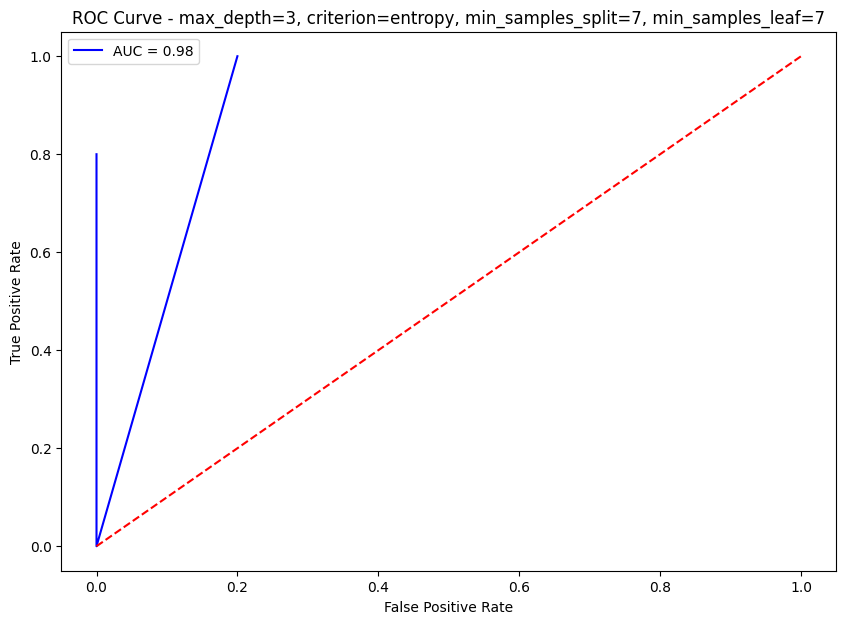

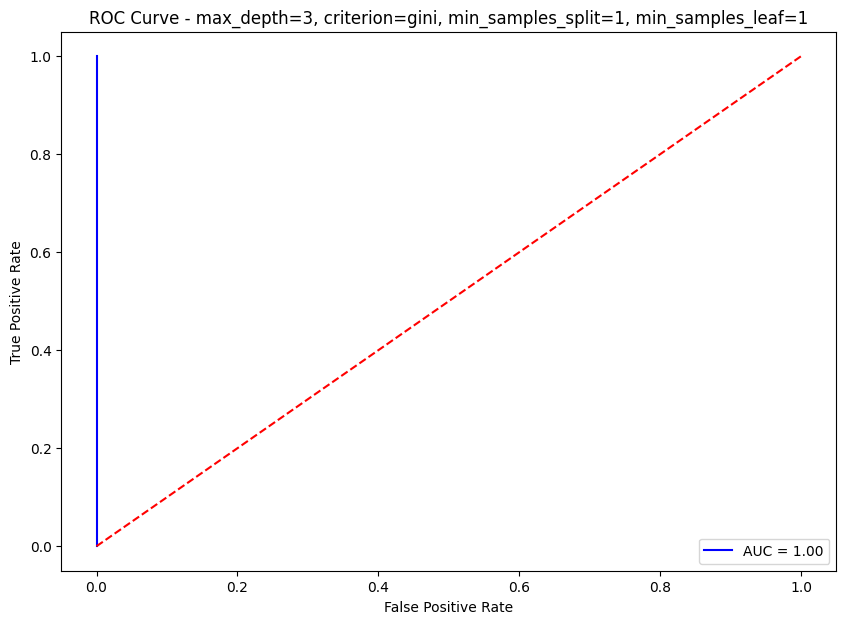

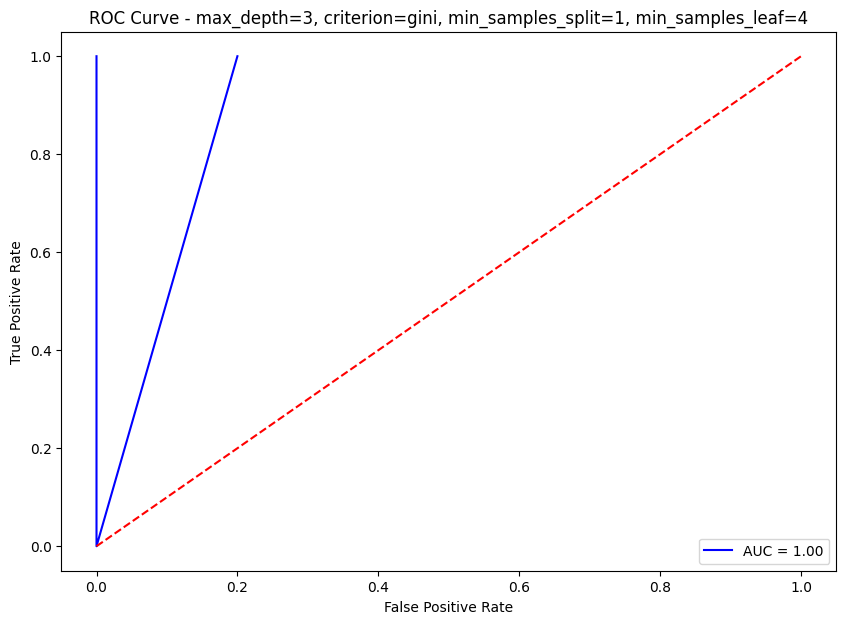

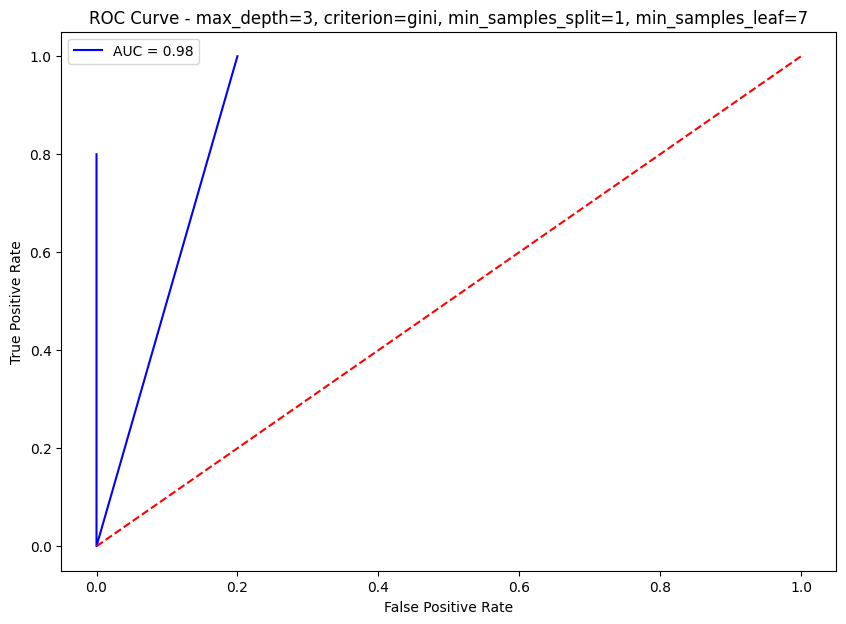

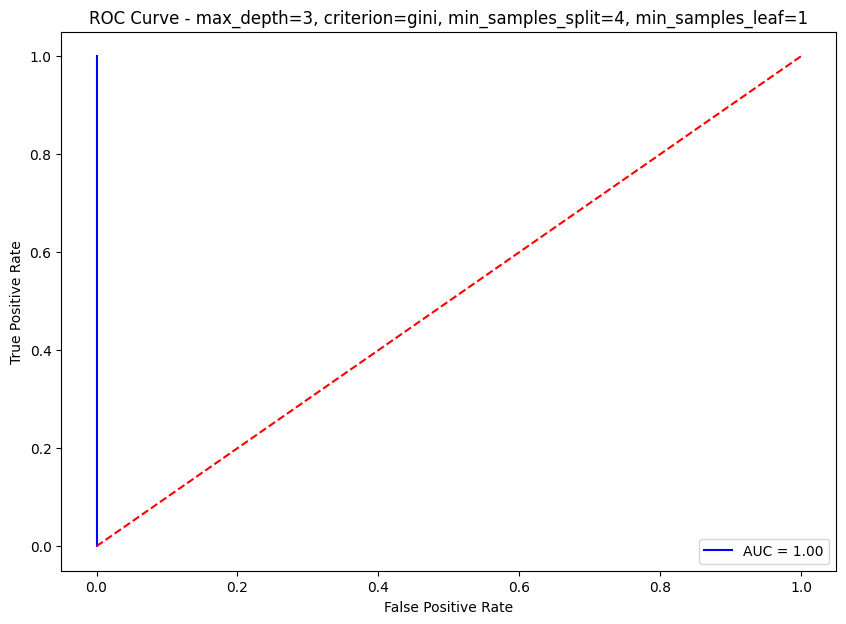

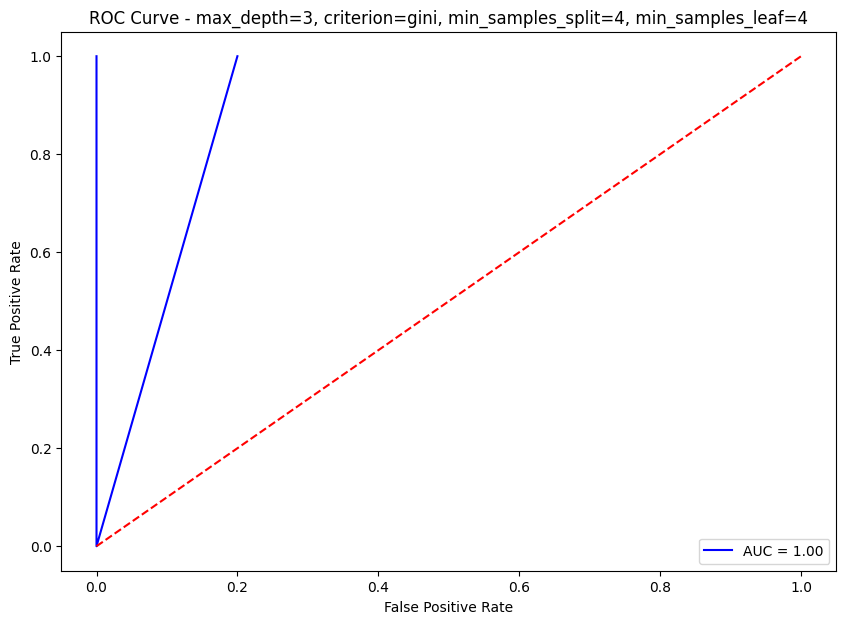

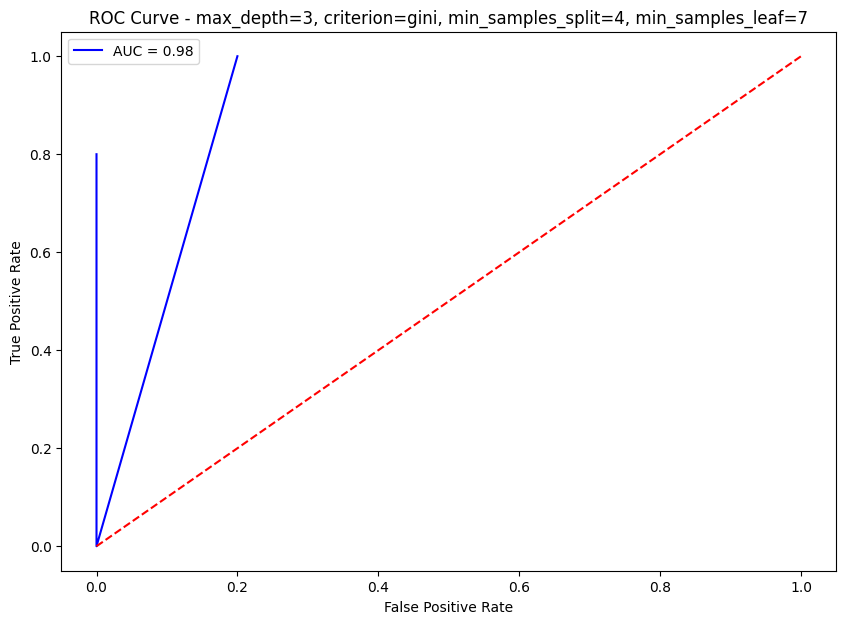

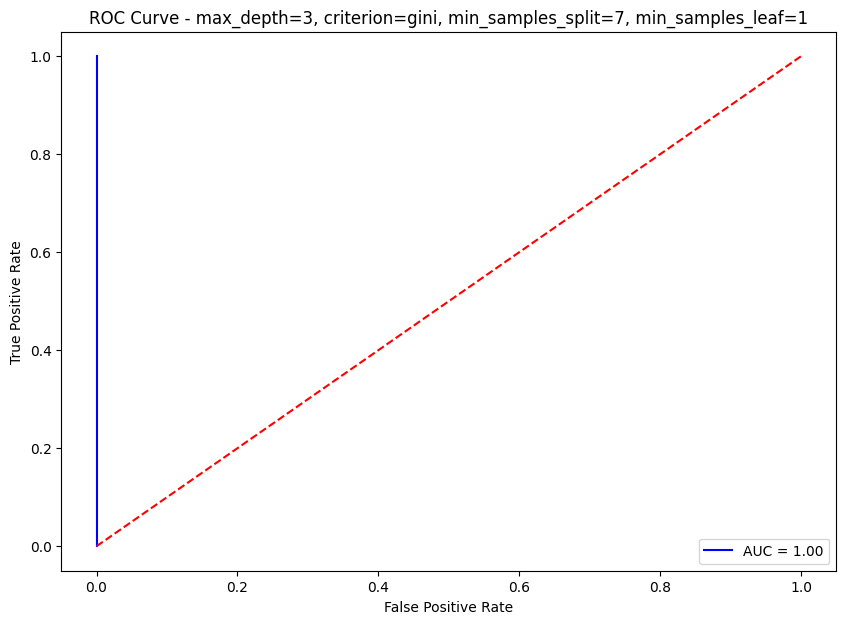

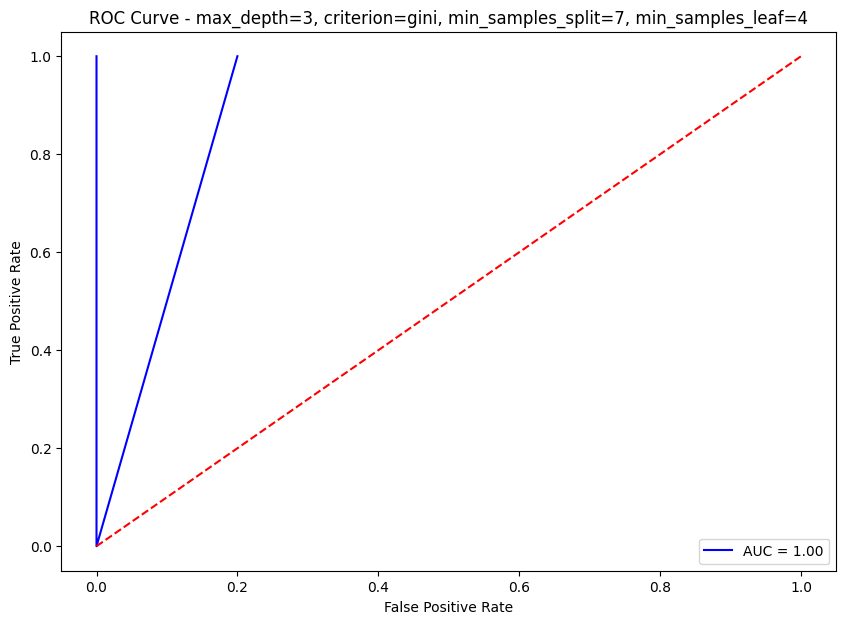

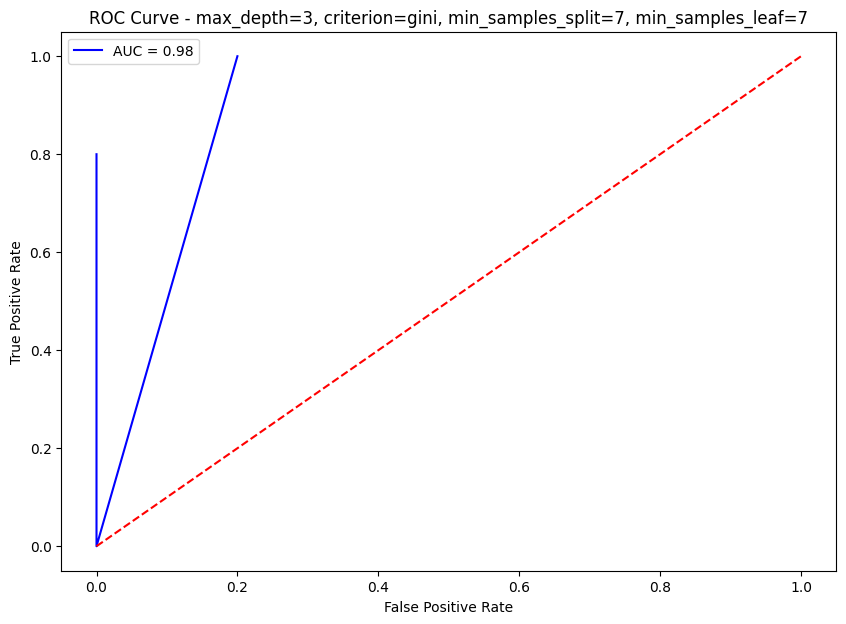

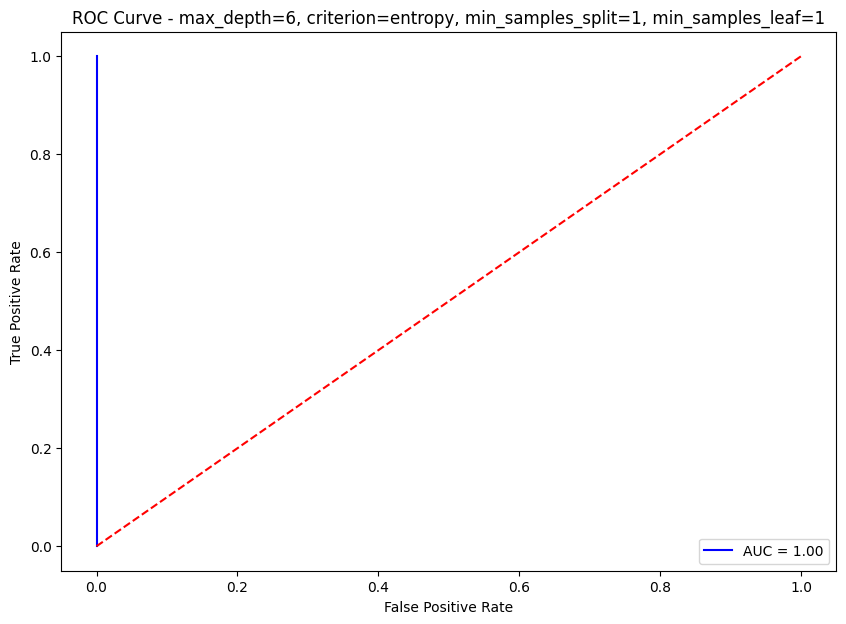

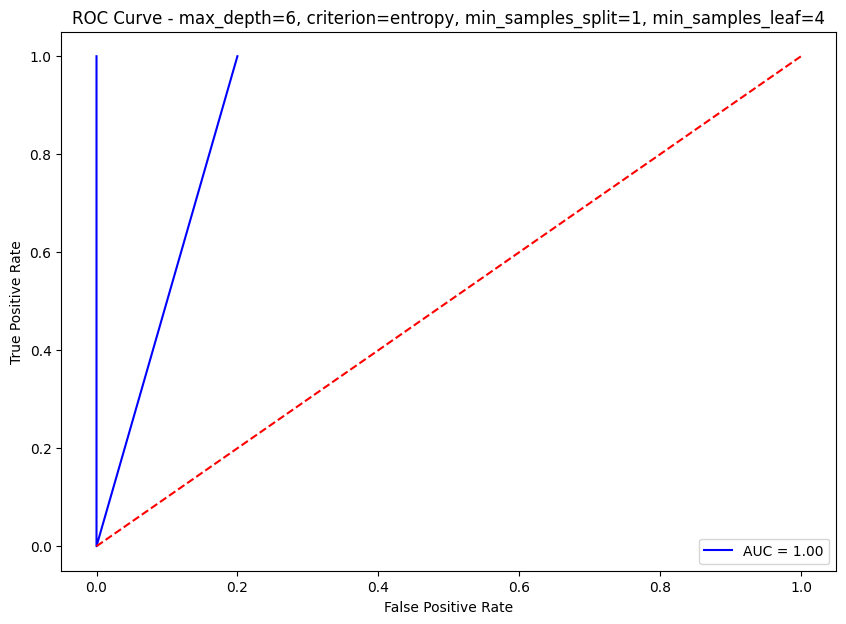

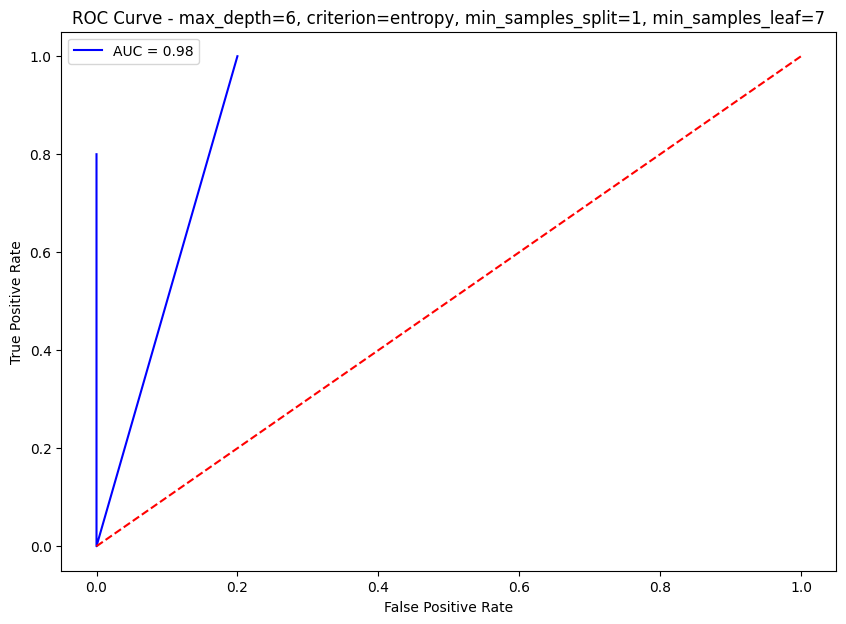

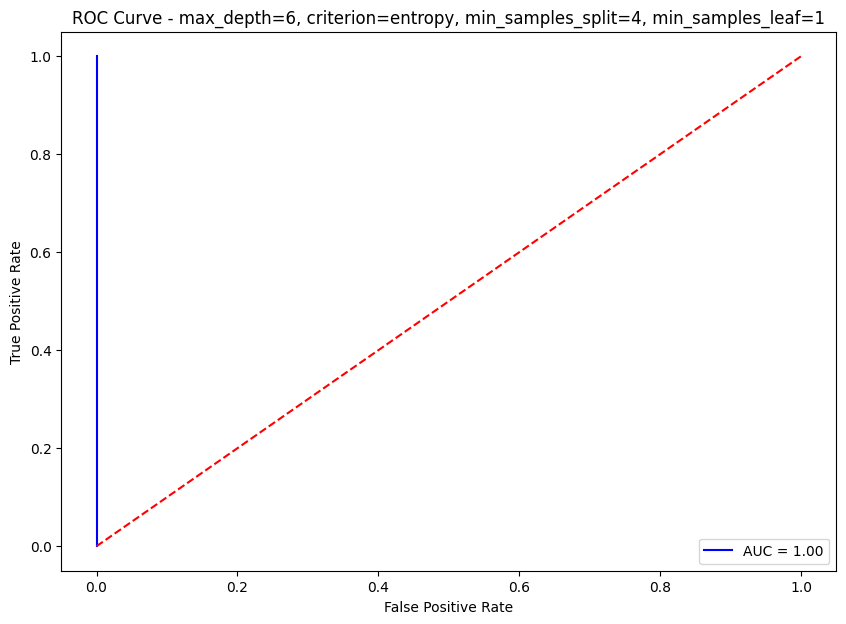

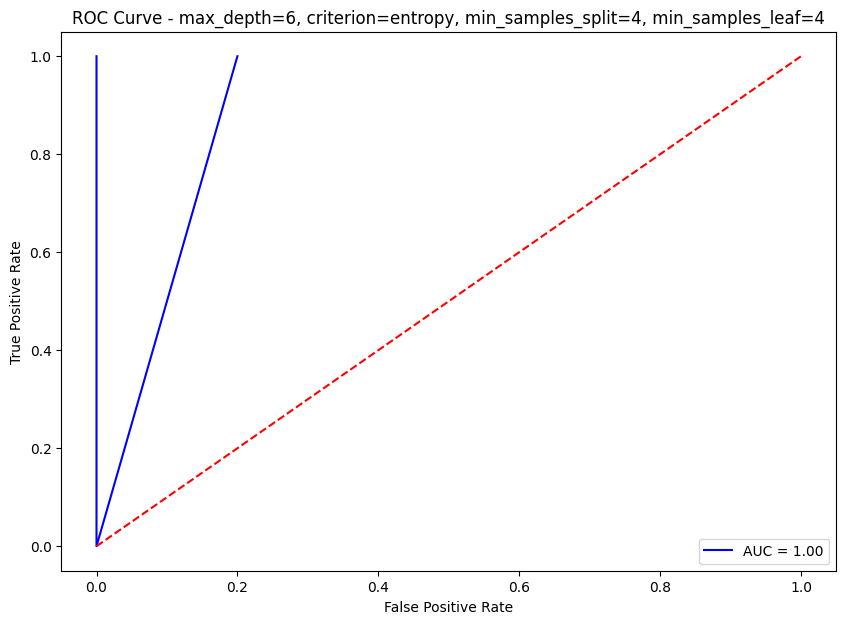

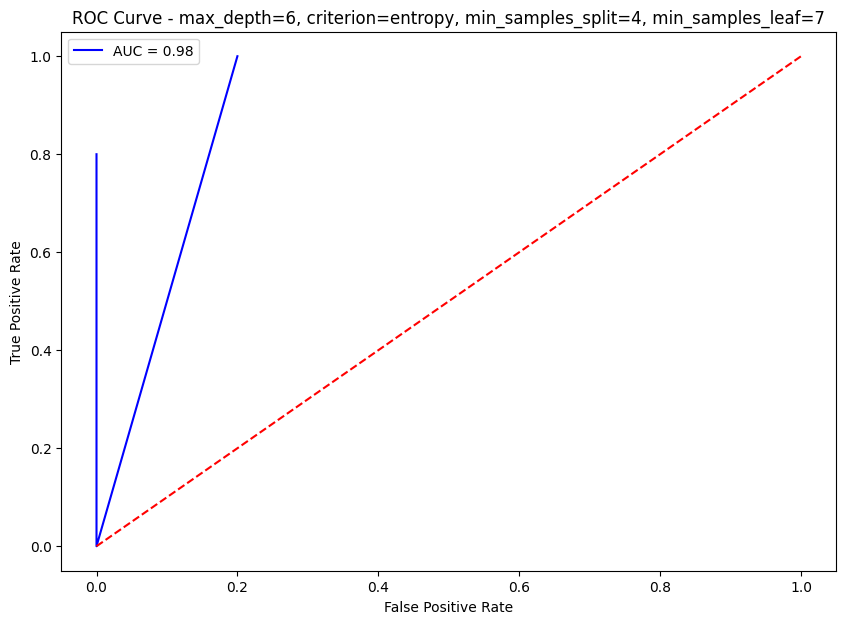

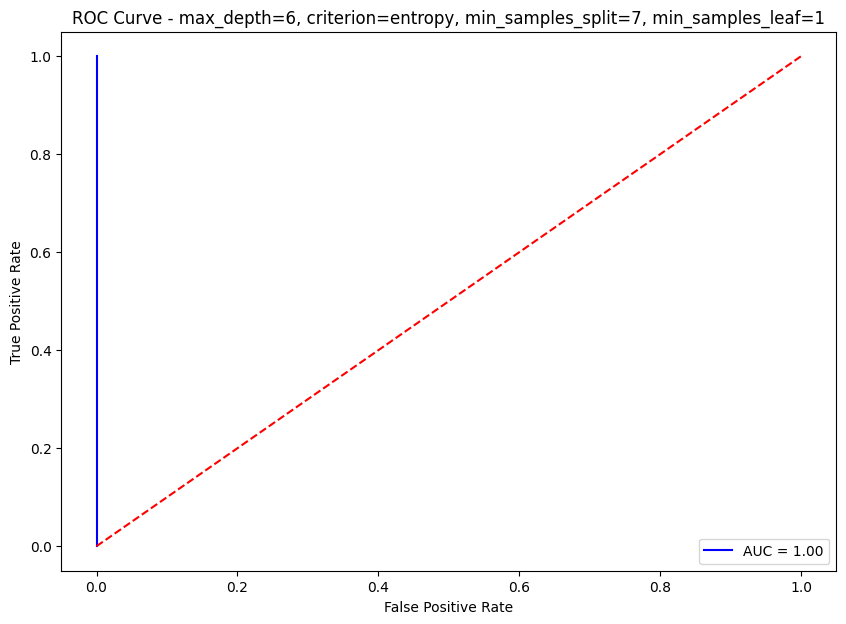

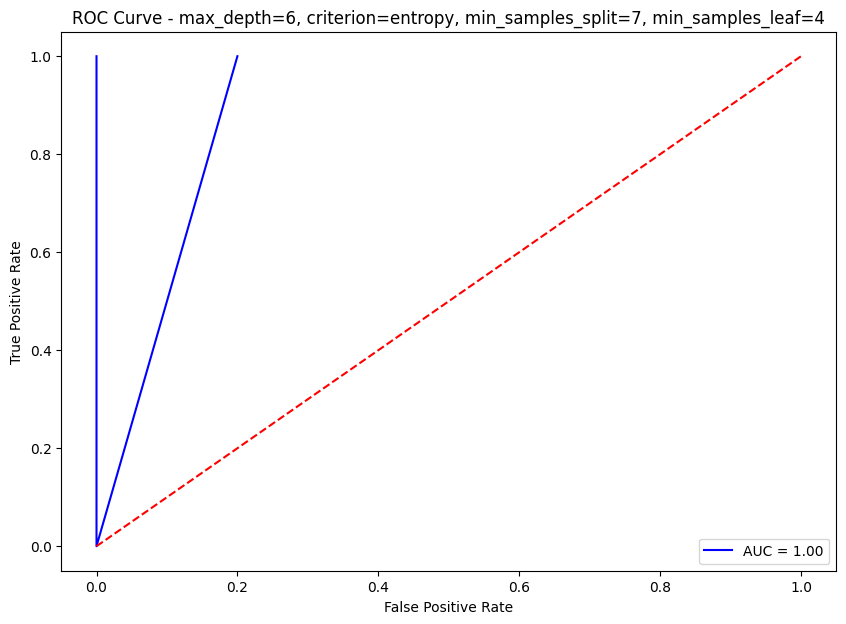

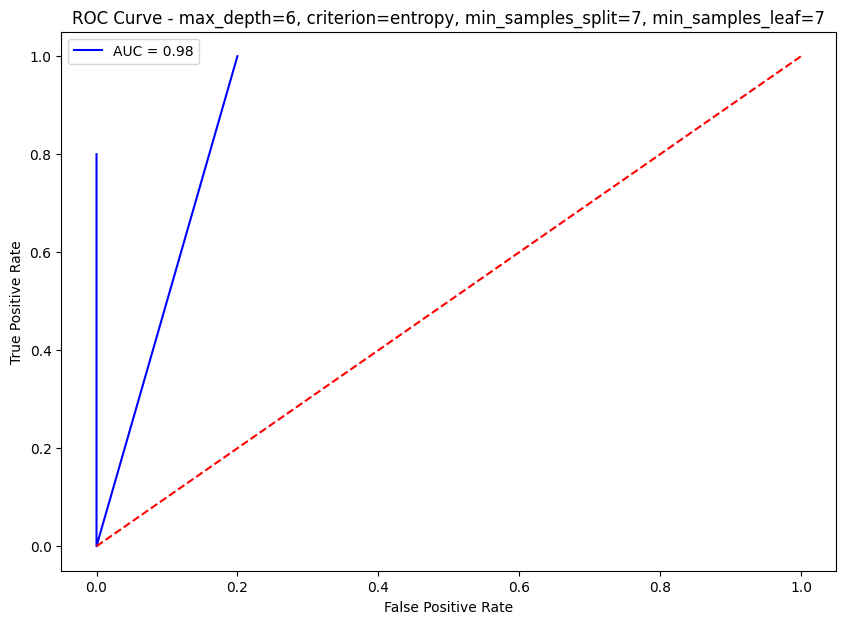

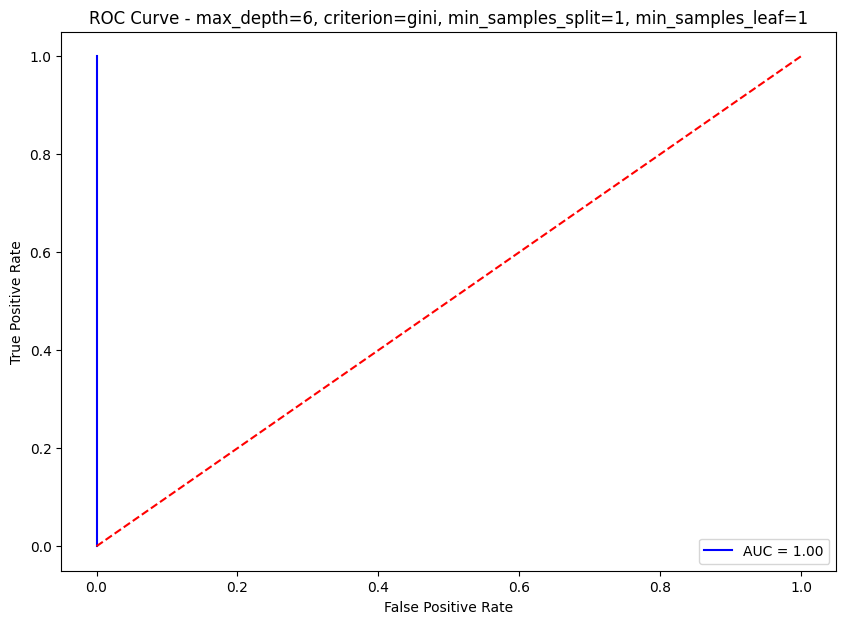

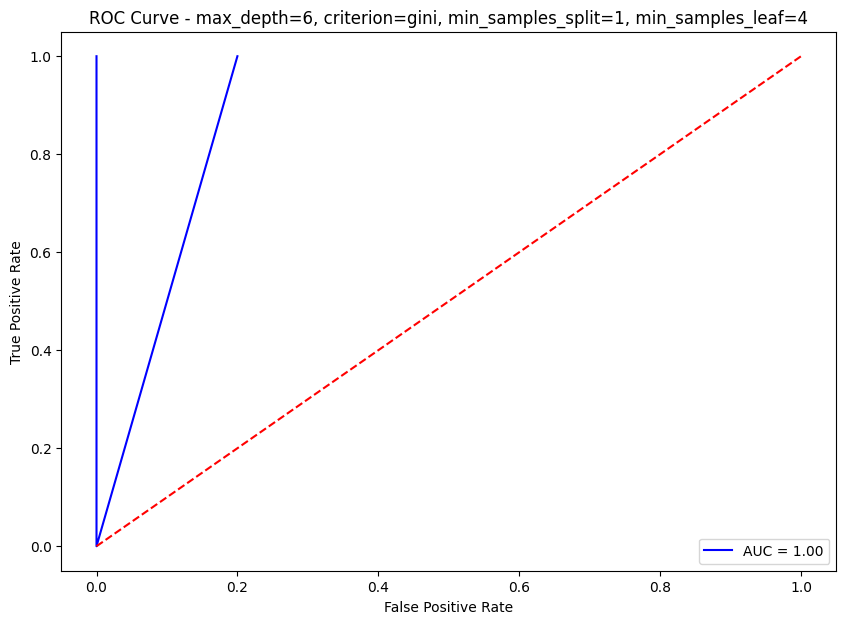

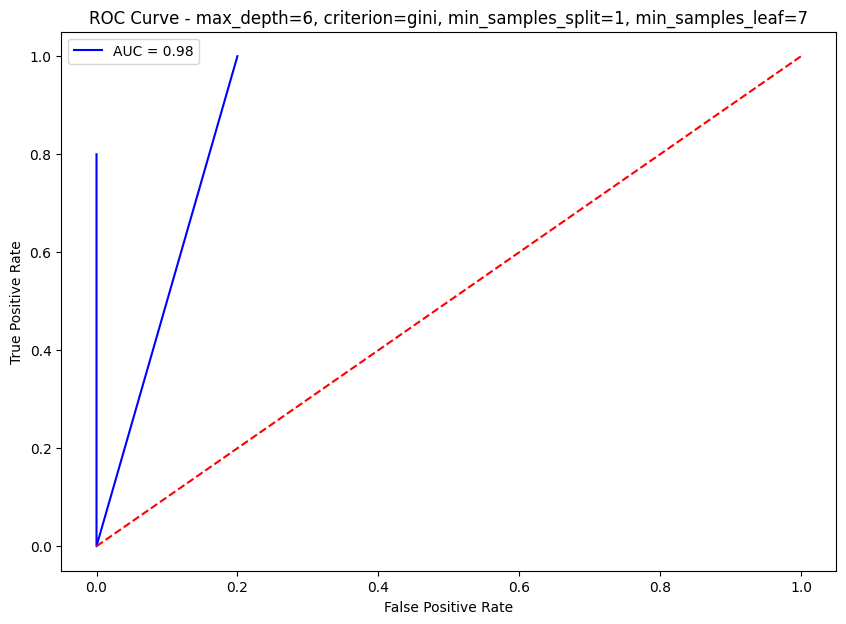

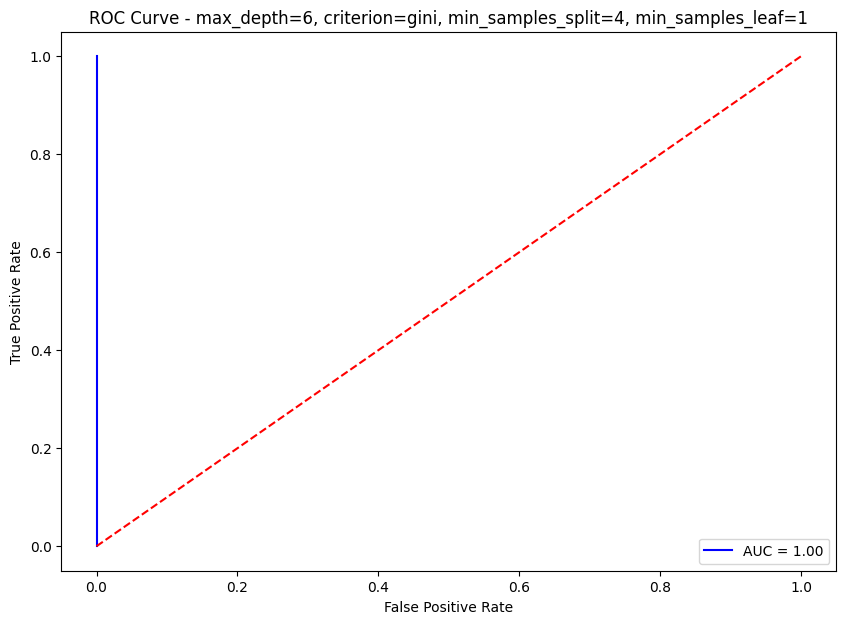

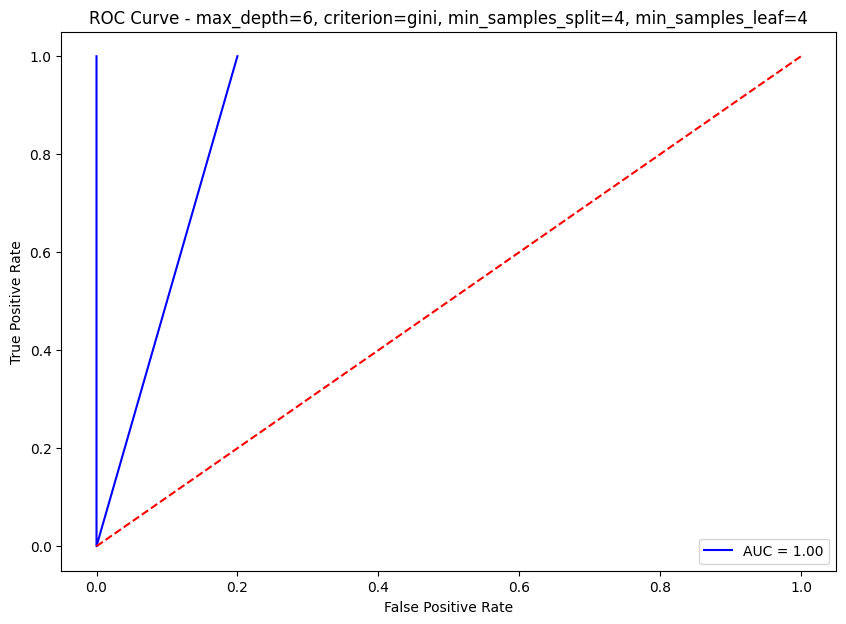

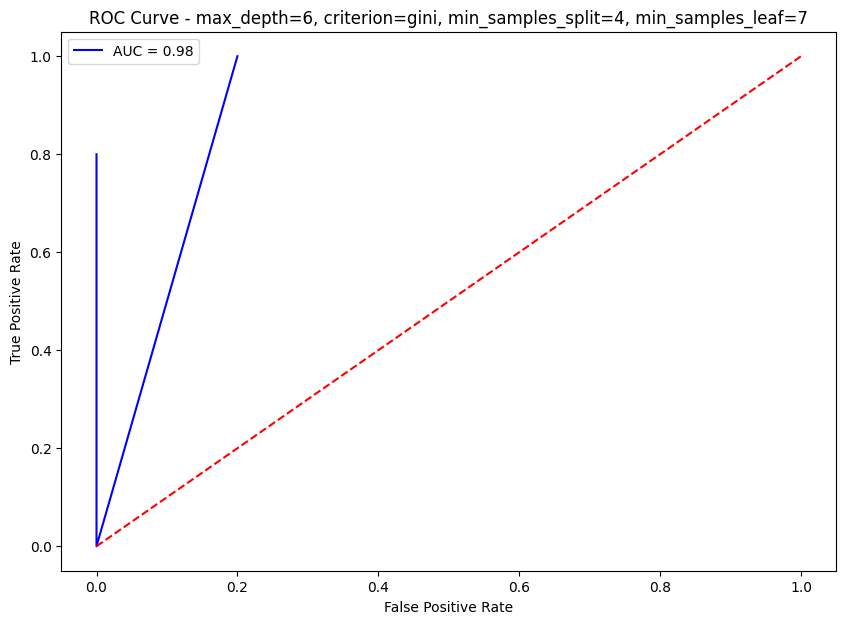

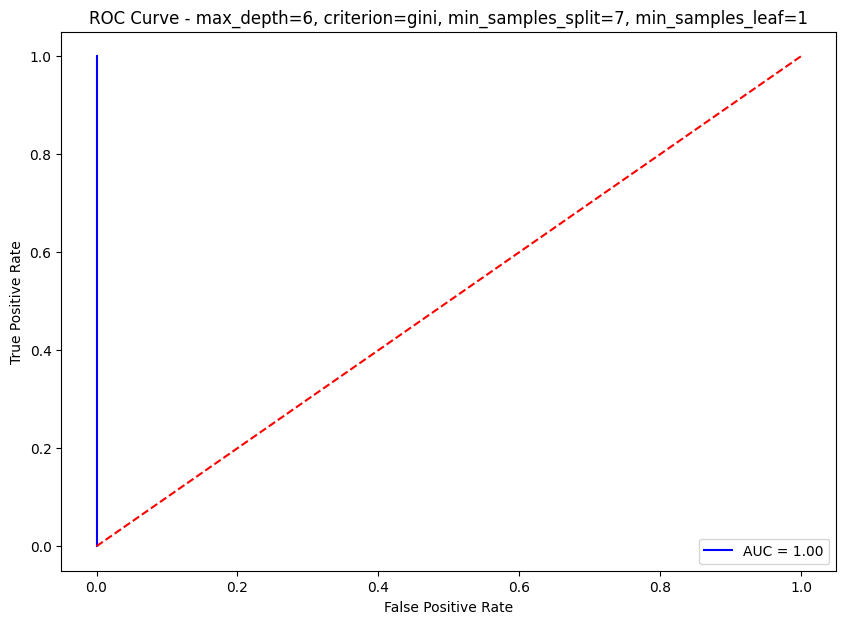

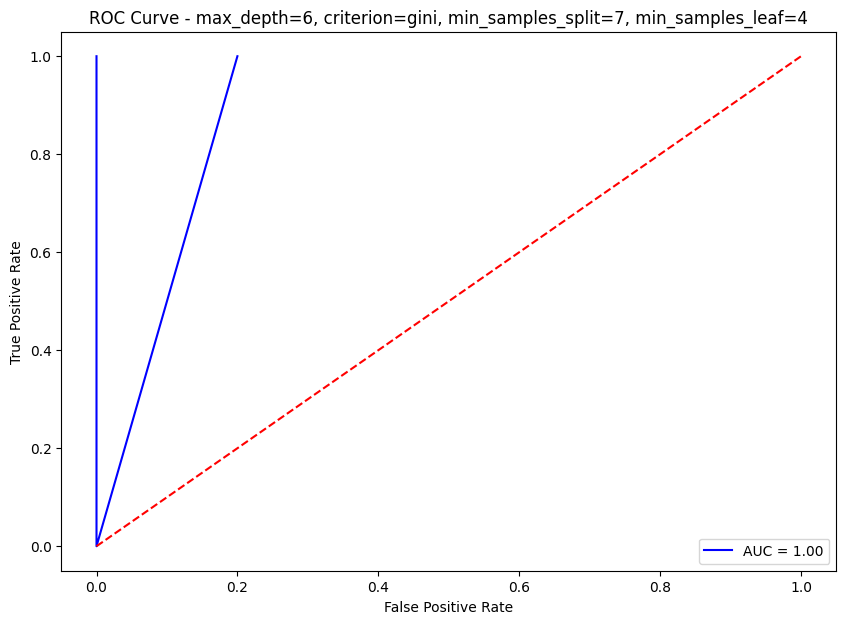

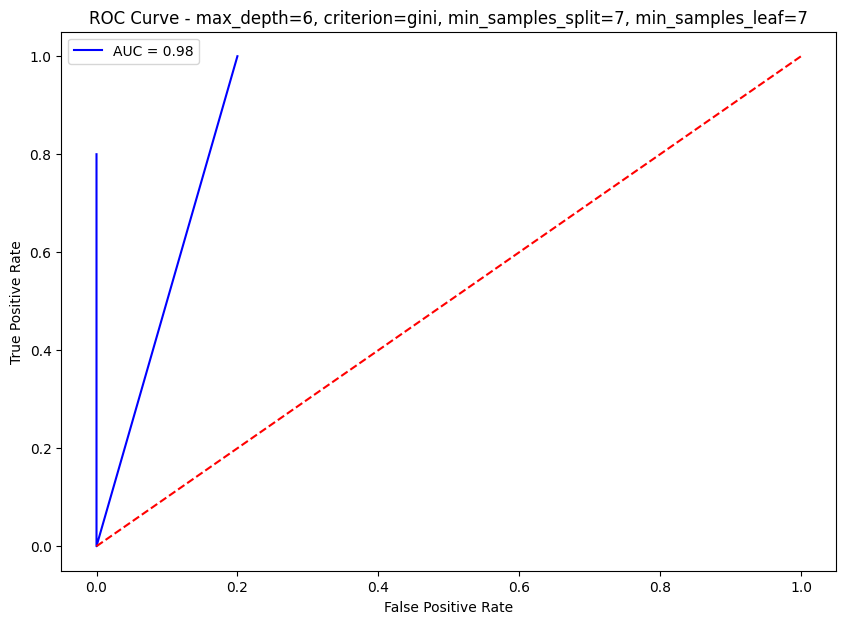

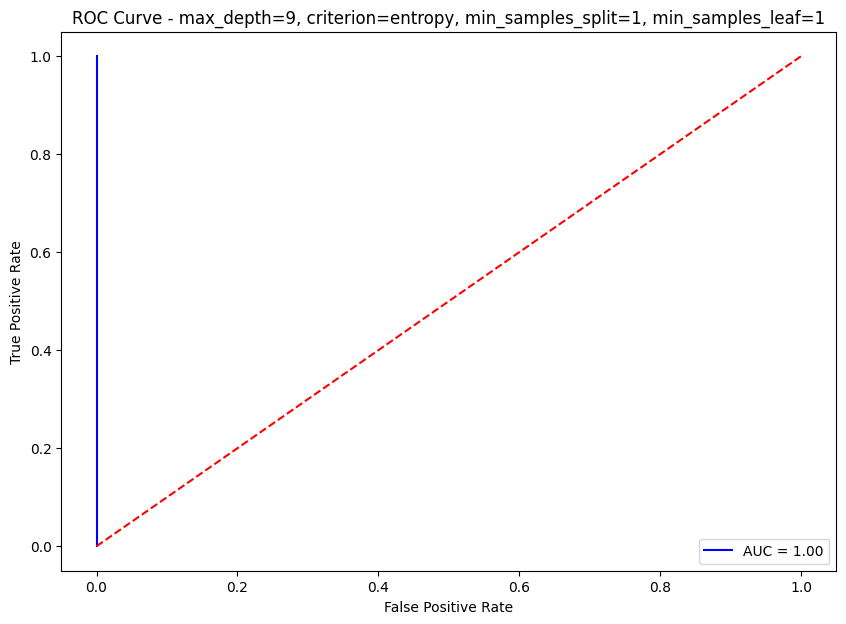

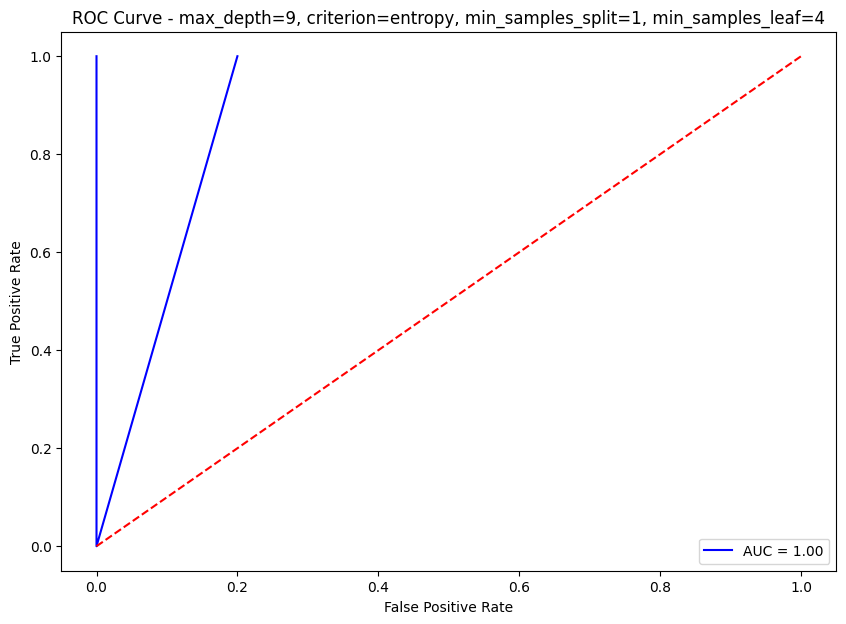

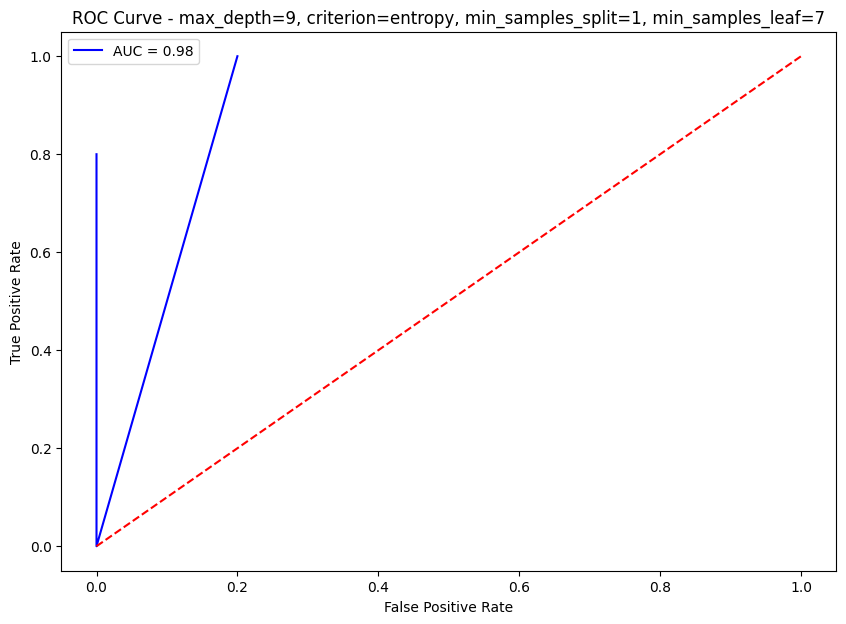

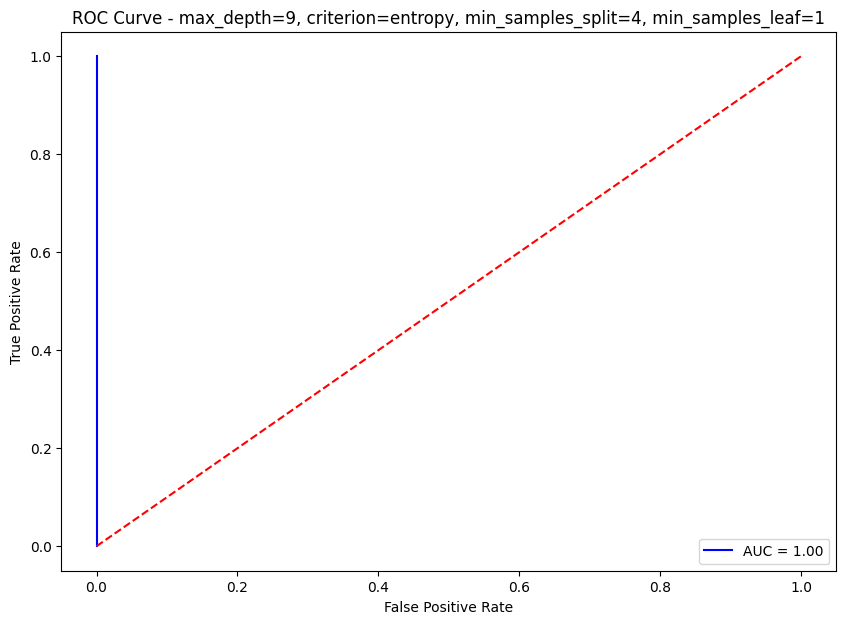

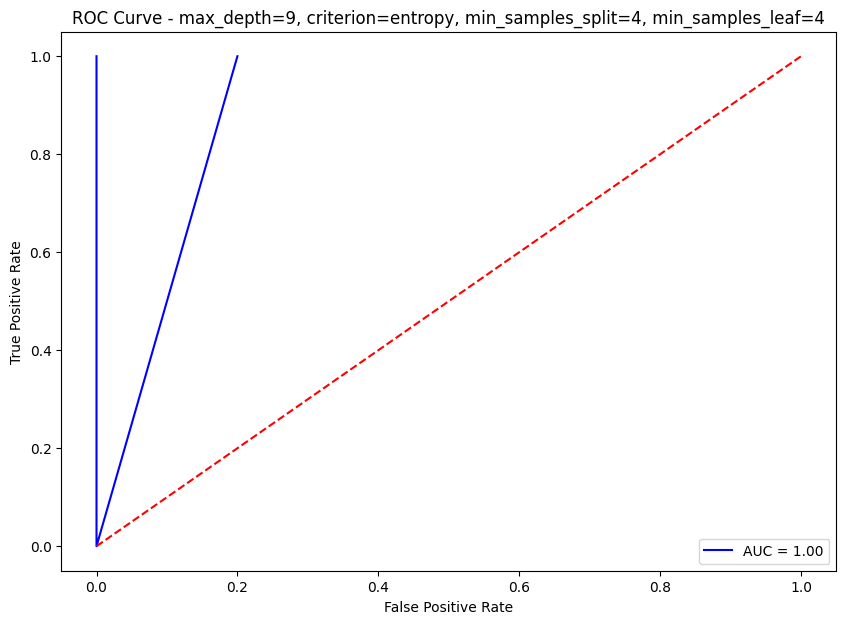

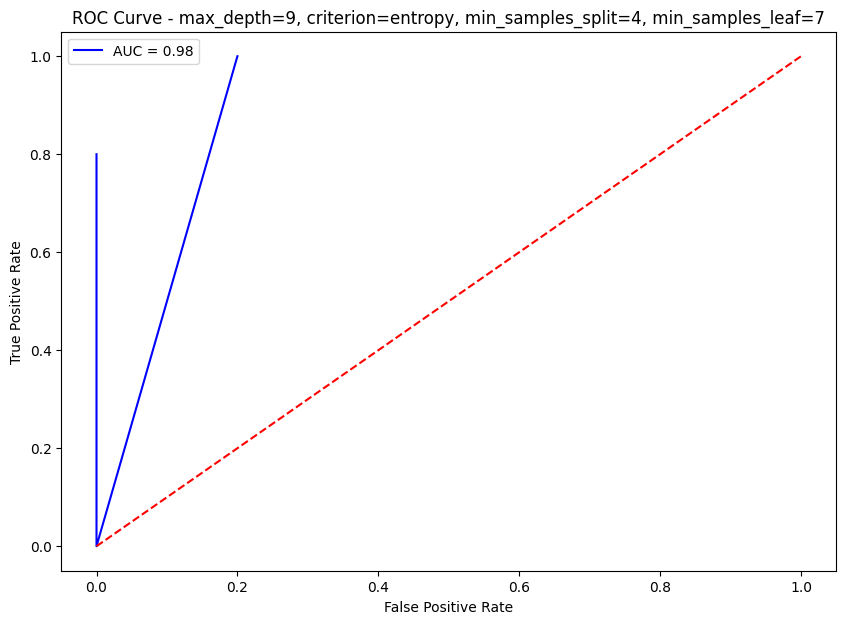

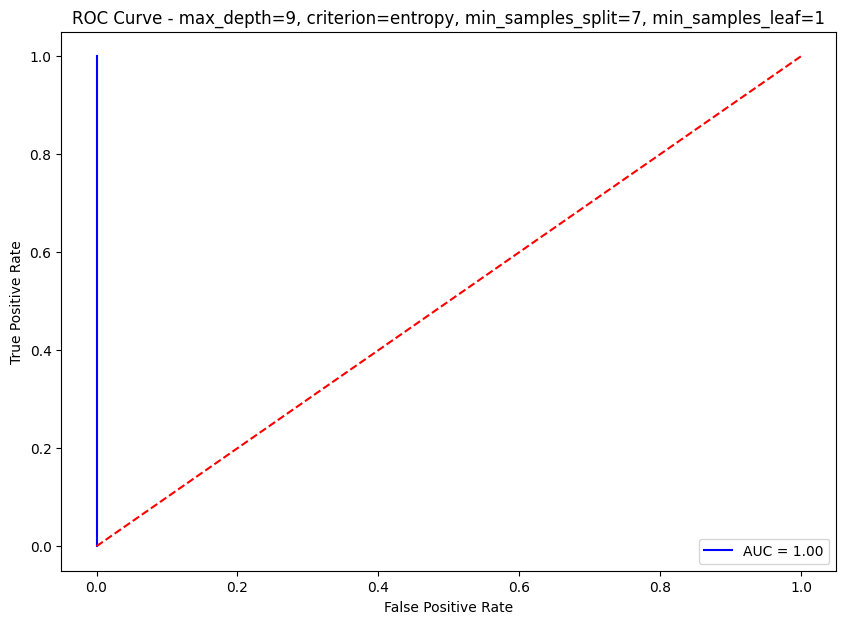

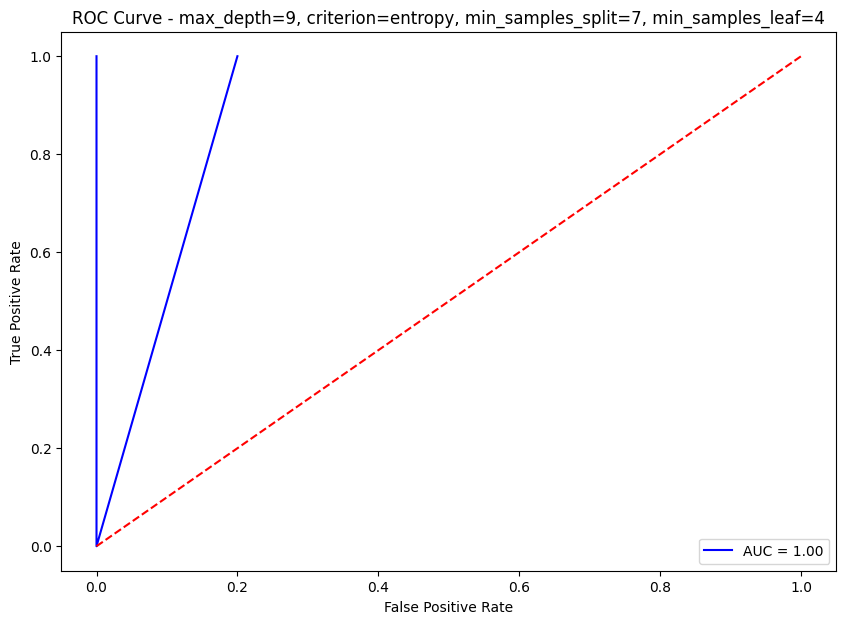

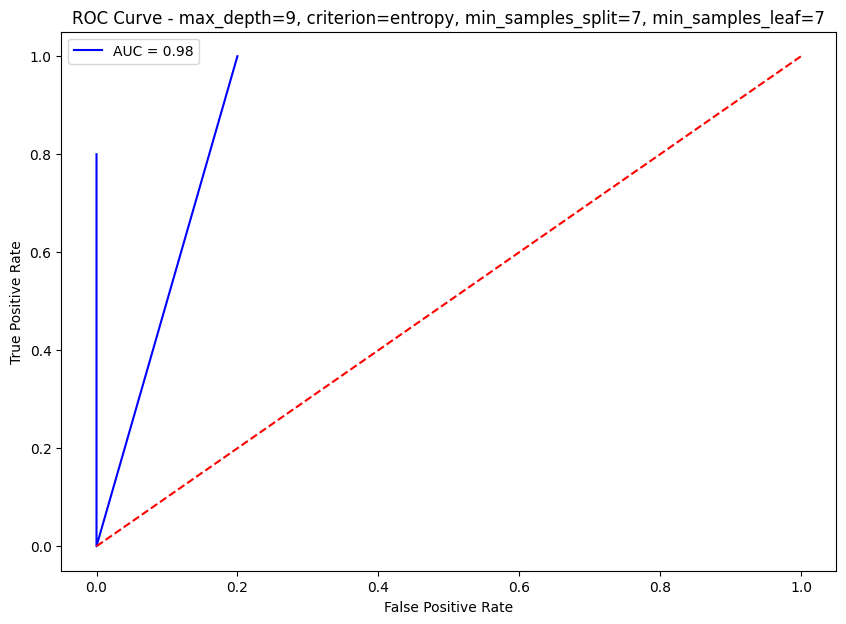

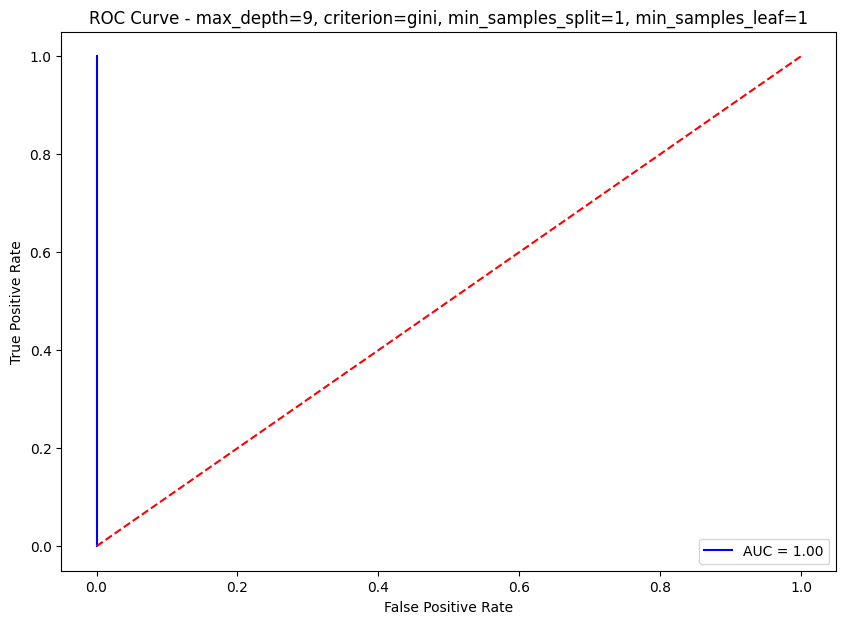

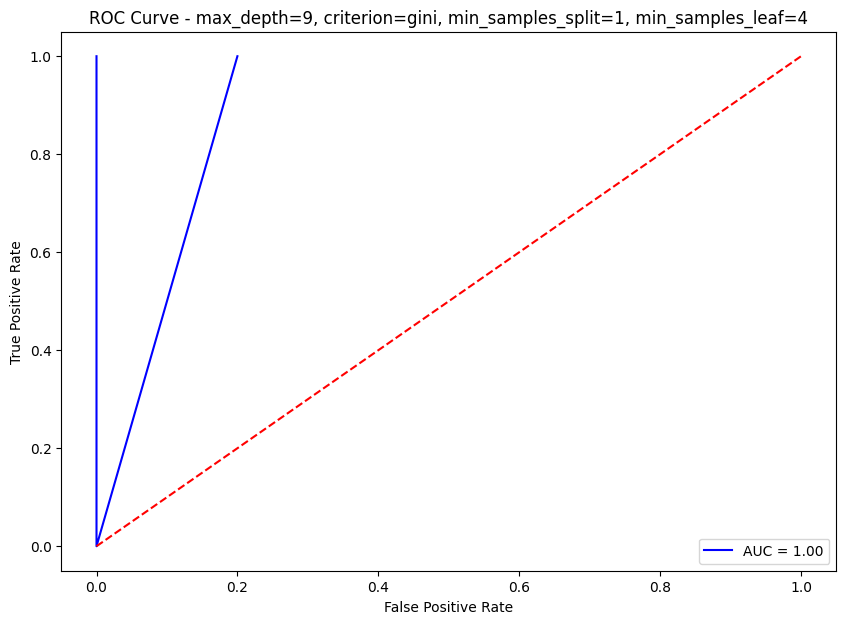

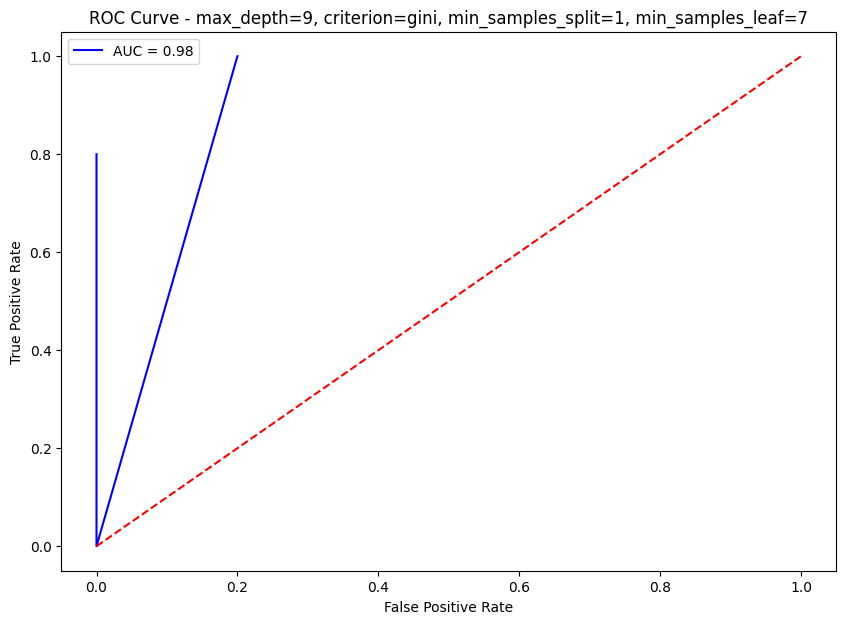

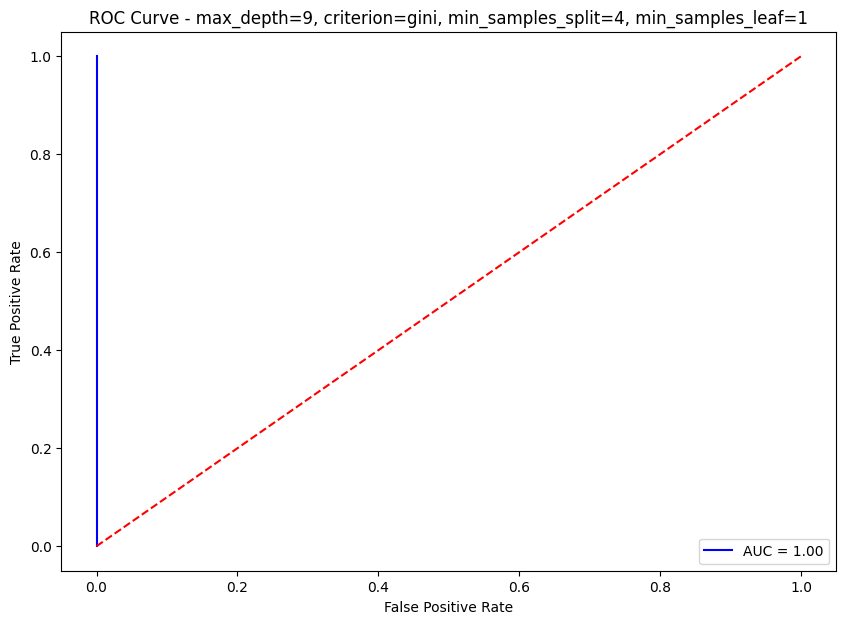

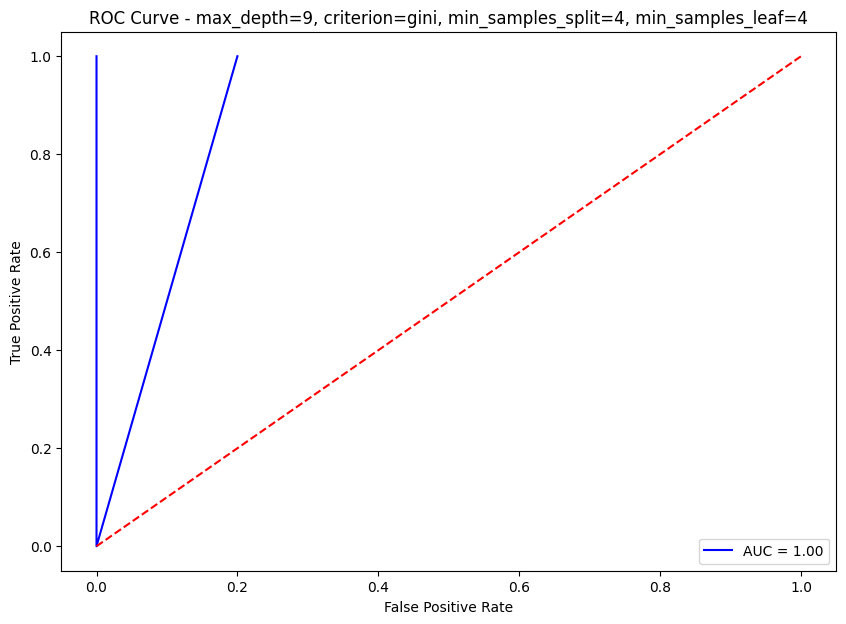

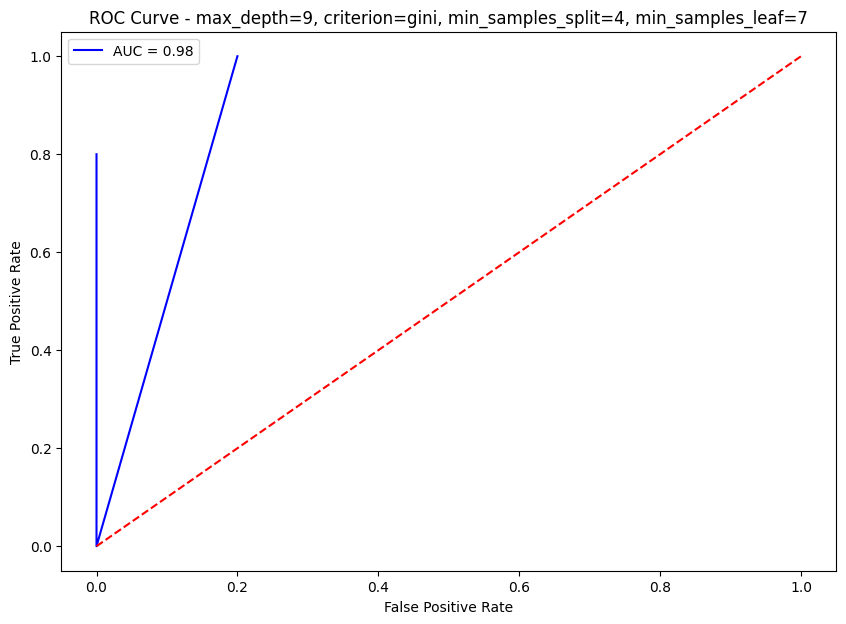

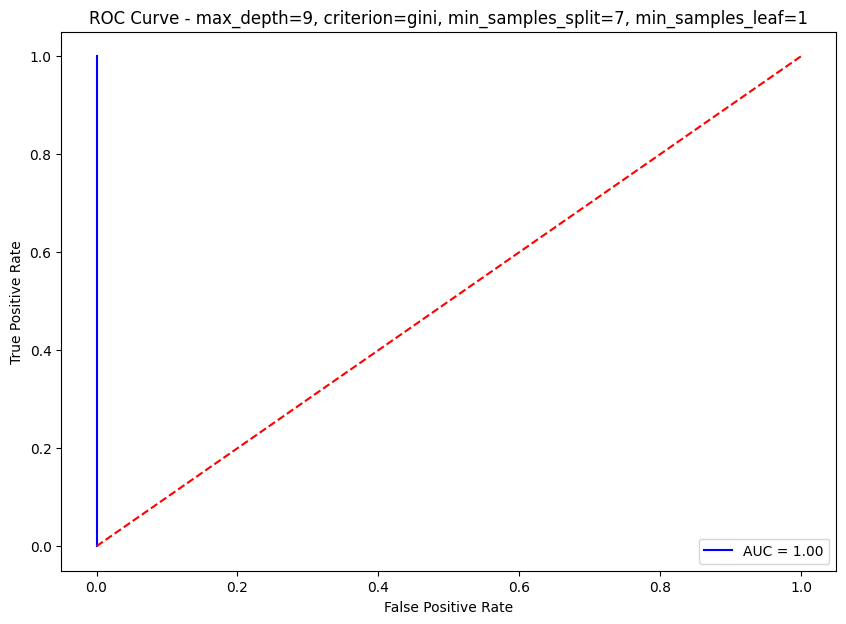

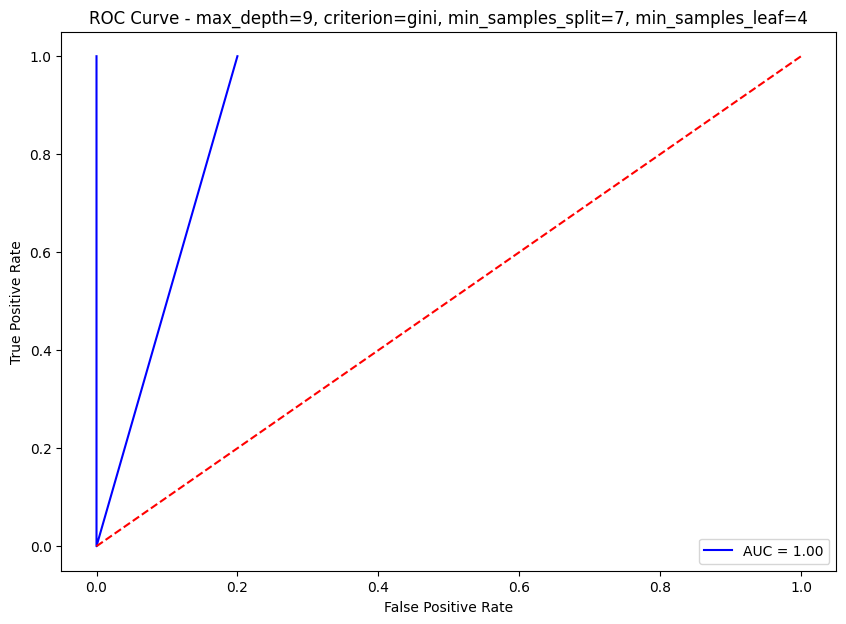

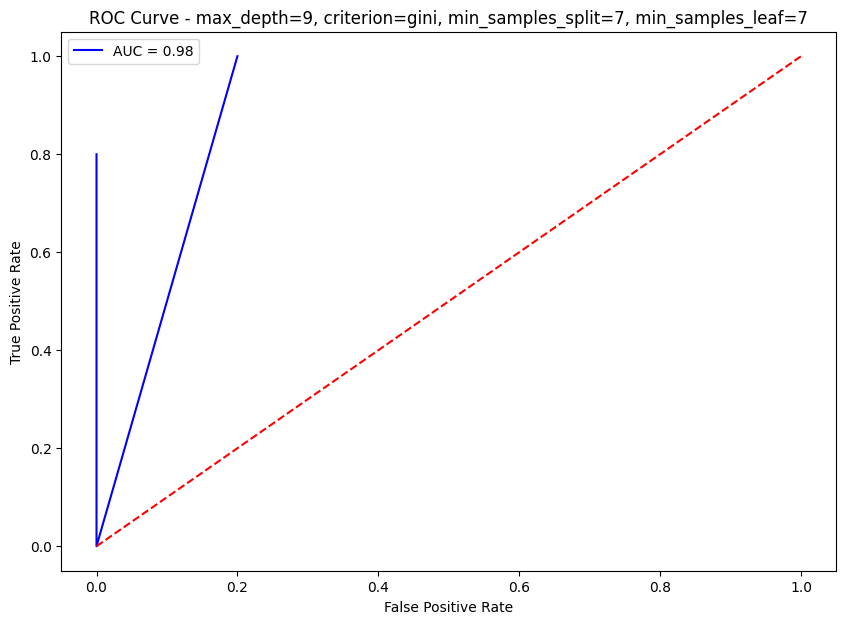

{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 1, 'min_samples_leaf': 1, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'fpr': 0.0, 'balanced_accuracy': 1.0, 'roc_auc': 1.0}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 1, 'min_samples_leaf': 4, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'fpr': 0.0, 'balanced_accuracy': 1.0, 'roc_auc': 1.0}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 1, 'min_samples_leaf': 7, 'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0, 'fpr': 0.2, 'balanced_accuracy': 0.9, 'roc_auc': 0.9800000000000001}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 1, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'fpr': 0.0, 'balanced_accuracy': 1.0, 'roc_auc': 1.0}
{'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 4, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'fpr': 0.0, 'balanced_accuracy': 1.0, 'roc_auc': 1.0}
{'max_dept

In [ ]:
y_train_haar_arboles = y_train_haar.astype(int)
y_val_haar_arboles = y_val_haar.astype(int)

# Parámetros para probar
max_depths = [3, 6, 9]
criterions = ["entropy", "gini"]
min_samples_splits = [1, 4, 7]
min_samples_leaves = [1, 4, 7]

# Invocamos la función
results = evaluate_tree_hyperparameters(X_train_haar, y_train_haar_arboles, X_val_haar, y_val_haar_arboles, max_depths, criterions, min_samples_splits, min_samples_leaves)
for res in results:
    print(res)

En resumen, vemos que el rendimiento se mantiene de muy buena forma sin importar la variación de los valores de los distintos hiperparámetros.

| **max_depth** | **criterion** | **min_samples_split** | **min_samples_leaf** | **Accuracy** | **Precision** | **Recall** | **FPR** | **Balanced Accuracy** | **ROC AUC** |
|---------------|---------------|-----------------------|----------------------|--------------|---------------|------------|---------|-----------------------|-------------|
| {3, 6, 9}           | {entropy, gini}      | {1, 4, 7}                    | {1, 4}                    | 1.0          | 1.0          | 1.0        | 0.0     | 0.9                   | 0.98         |

Observamos que para los casos con min_samples_leaf = 7, descienden en general todas las métricas.

### Árbol de decisión usando la técnica K-Cross-Validation

In [ ]:
def evaluate_tree_with_cross_validation(X, y, max_depth, criterion, min_samples_split, min_samples_leaf):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Creamos el árbol con la configuración óptima hallada anteriormente
        tree = build_tree(X_train_fold, y_train_fold, depth=0, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion=criterion)

        # Evaluamos el árbol en el fold
        y_pred_fold = predict(tree, X_test_fold)
        y_scores_fold = predict_proba(tree, X_test_fold)

        # Calculamos métricas
        accuracy_fold = accuracy_fun(y_test_fold, y_pred_fold)
        precision_fold = precision(y_test_fold, y_pred_fold)
        recall_fold = recall(y_test_fold, y_pred_fold)
        fpr_fold = fpr(y_test_fold, y_pred_fold)
        fprs, tprs, _  = roc_auc(y_test_fold, y_scores_fold)
        auc_fold = roc_auc_score(y_test_fold, y_scores_fold)
        balanced_accuracy_fold = balanced_accuracy(y_test_fold, y_pred_fold)

        # Imprimimos métricas del fold para llevar registro de las variaciones que puedan surgir
        print(f"Fold {fold}:")
        print(f"Accuracy: {accuracy_fold:.4f}")
        print(f"Precision: {precision_fold:.4f}")
        print(f"Recall: {recall_fold:.4f}")
        print(f"FPR: {fpr_fold:.4f}")
        print(f"Balanced Accuracy: {balanced_accuracy_fold:.4f}")
        print(f"ROC AUC: {auc_fold:.4f}")

        # Dibujamos la curva ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fprs, tprs, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_fold:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend(loc='lower right')
        plt.show()

Fold 1:
Accuracy: 0.8000
Precision: 0.8333
Recall: 0.7500
FPR: 0.1500
Balanced Accuracy: 0.8000
ROC AUC: 0.8533


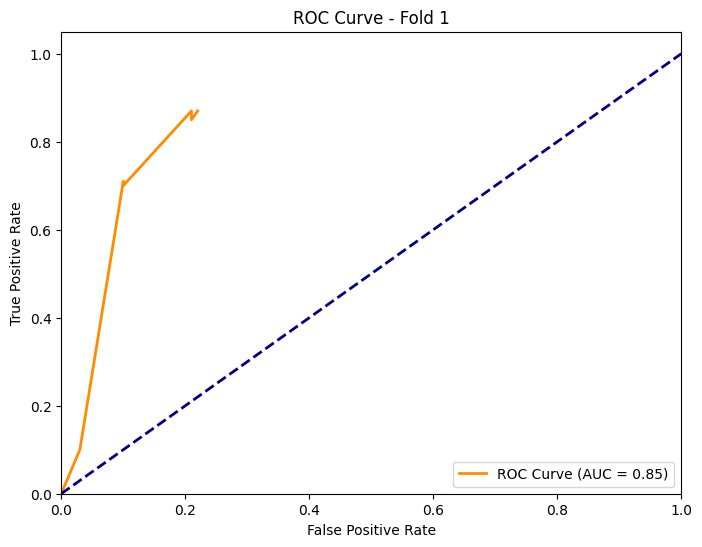

Fold 2:
Accuracy: 0.8350
Precision: 0.8131
Recall: 0.8700
FPR: 0.2000
Balanced Accuracy: 0.8350
ROC AUC: 0.8958


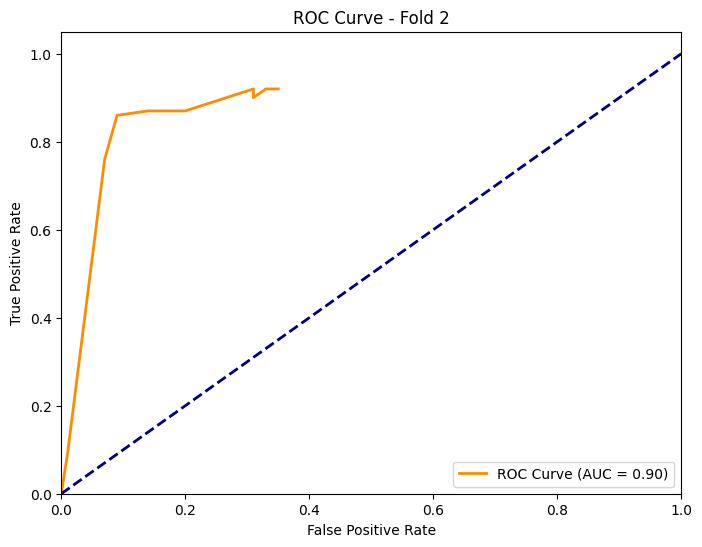

Fold 3:
Accuracy: 0.8050
Precision: 0.7850
Recall: 0.8400
FPR: 0.2300
Balanced Accuracy: 0.8050
ROC AUC: 0.8682


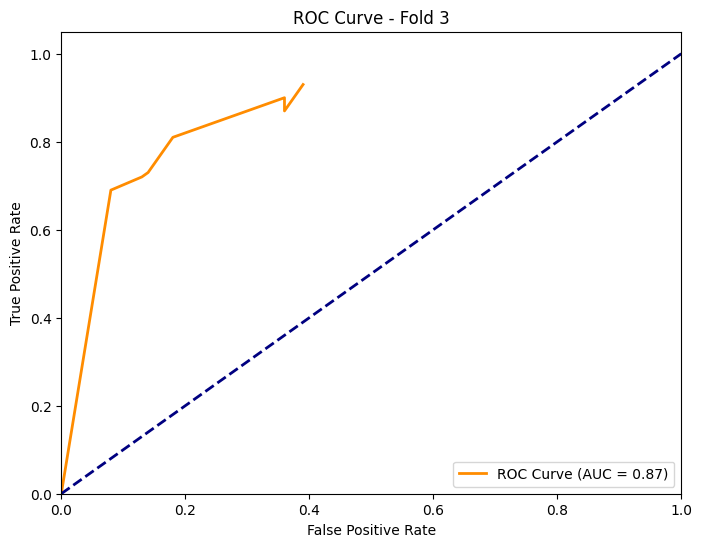

Fold 4:
Accuracy: 0.7700
Precision: 0.8068
Recall: 0.7100
FPR: 0.1700
Balanced Accuracy: 0.7700
ROC AUC: 0.8268


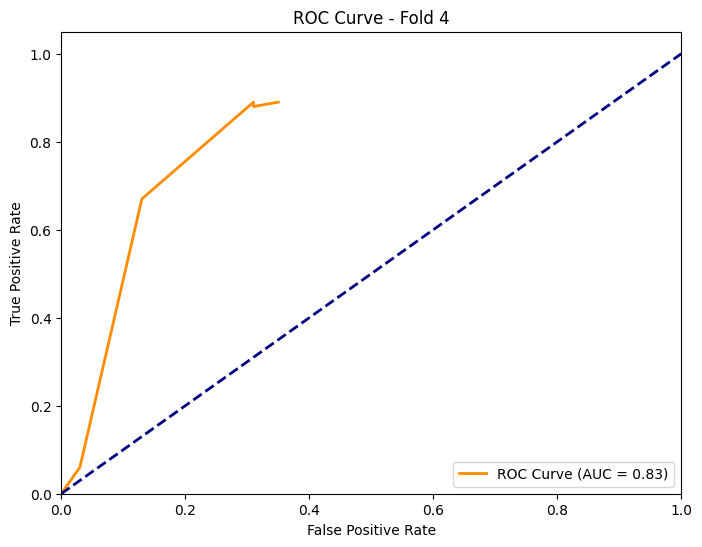

Fold 5:
Accuracy: 0.8250
Precision: 0.8155
Recall: 0.8400
FPR: 0.1900
Balanced Accuracy: 0.8250
ROC AUC: 0.8981


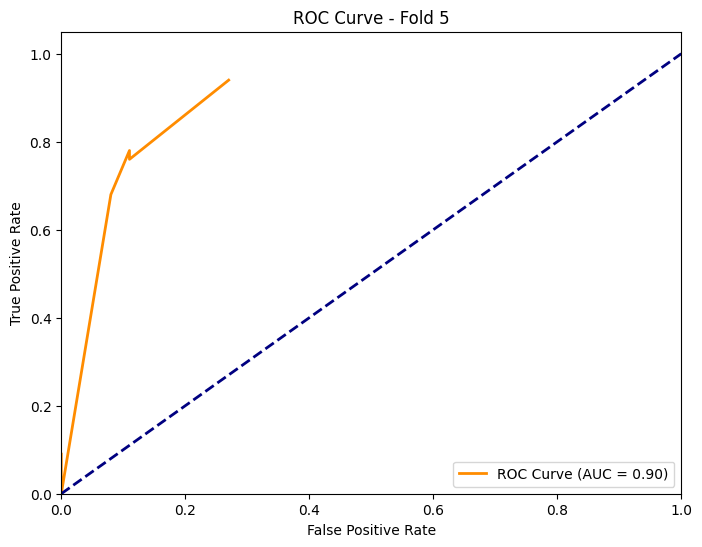

In [ ]:
evaluate_tree_with_cross_validation(X_train_hog_reducido, y_train_hog_arboles, 6, 'gini', 7, 7)

| Fold    | Accuracy | Precision | Recall | FPR   | Balanced Accuracy | ROC AUC |
|---------|----------|-----------|--------|-------|-------------------|---------|
| 1       | 0.8000   | 0.8333    | 0.7500 | 0.1500 | 0.8000          | 0.8533  |
| 2       | 0.8350   | 0.8131    | 0.8700 | 0.2000 | 0.8350          | 0.8958  |
| 3       | 0.8050   | 0.7850    | 0.8400 | 0.2300 | 0.8050          | 0.8682  |
| 4       | 0.7700   | 0.8068    | 0.7100 | 0.1700 | 0.7700          | 0.8268  |
| 5       | 0.8250   | 0.8155    | 0.8400 | 0.1900 | 0.8250          | 0.8981  |
| Promedio| 0.8070   | 0.8107    | 0.8020 | 0.1880 | 0.8070          | 0.8684  |


## Regresión Logística

In [ ]:
# Definimos los hiperparámetros que deseas explorar
def entrenar_evaular_reg_log(X_train,y_train,X_val,y_val,penalties,Cs,solvers):
  set_seed(2023)
  for penalty in penalties:
      for C in Cs:
          for solver in solvers:
              logreg = LogisticRegression(penalty=penalty, C=C, solver=solver,max_iter=int(1e6))
              logreg.fit(X_train, y_train)
              y_pred = logreg.predict(X_val)
              accuracy = accuracy_score(y_val, y_pred)
              print(f"Penalización: {penalty}, C: {C}, Solver: {solver} --> accuracy: {accuracy}")

def entrenar_evaluar_reg_log_haar(X_train,y_train,X_val,y_val,penalties,Cs,solvers):
  set_seed(2023)
  for penalty in penalties:
      for C in Cs:
          for solver in solvers:
              logreg = LogisticRegression(penalty=penalty, C=C, solver=solver,max_iter=int(1e6))
              logreg.fit(X_train, y_train)
              y_pred = logreg.predict(X_val)
              accuracy = accuracy_score(y_val, y_pred)
              print(f"Penalización: {penalty}, C: {C}, Solver: {solver}")
              imprimir_resultados_sin_graficar(y_val,y_pred)

from sklearn.model_selection import cross_val_score

In [ ]:
penalties = ['l1', 'l2']
Cs = [0.01, 0.1, 1, 10, 100]
solvers = ['liblinear', 'saga']

### HOG

Exploración de Hiperparámetros:

In [ ]:
entrenar_evaular_reg_log(X_train_hog_pca,y_train,X_val_hog_pca,y_val,penalties,Cs,solvers)

Penalización: l1, C: 0.01, Solver: liblinear --> accuracy: 0.904420098224405
Penalización: l1, C: 0.01, Solver: saga --> accuracy: 0.904797884397431
Penalización: l1, C: 0.1, Solver: liblinear --> accuracy: 0.9346429920664904
Penalización: l1, C: 0.1, Solver: saga --> accuracy: 0.9346429920664904
Penalización: l1, C: 1, Solver: liblinear --> accuracy: 0.9410653570079335
Penalización: l1, C: 1, Solver: saga --> accuracy: 0.9410653570079335
Penalización: l1, C: 10, Solver: liblinear --> accuracy: 0.9403097846618814
Penalización: l1, C: 10, Solver: saga --> accuracy: 0.9403097846618814
Penalización: l1, C: 100, Solver: liblinear --> accuracy: 0.9395542123158293
Penalización: l1, C: 100, Solver: saga --> accuracy: 0.9395542123158293
Penalización: l2, C: 0.01, Solver: liblinear --> accuracy: 0.9191537589724216
Penalización: l2, C: 0.01, Solver: saga --> accuracy: 0.9191537589724216
Penalización: l2, C: 0.1, Solver: liblinear --> accuracy: 0.9365319229316207
Penalización: l2, C: 0.1, Solver:

### Haar Features PCA

In [ ]:
entrenar_evaluar_reg_log_haar(X_train_haar,y_train_haar,X_val_haar,y_val_haar,penalties,Cs,solvers)

Penalización: l1, C: 0.01, Solver: liblinear
Accuracy: 0.9000
Precision: 0.8333
Recall: 1.0000
False Positive Rate: 0.2000
Balanced Accuracy: 0.9000
Penalización: l1, C: 0.01, Solver: saga
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
False Positive Rate: 0.4000
Balanced Accuracy: 0.8000
Penalización: l1, C: 0.1, Solver: liblinear
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
False Positive Rate: 0.4000
Balanced Accuracy: 0.8000
Penalización: l1, C: 0.1, Solver: saga
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
False Positive Rate: 0.4000
Balanced Accuracy: 0.8000
Penalización: l1, C: 1, Solver: liblinear
Accuracy: 0.6000
Precision: 0.5556
Recall: 1.0000
False Positive Rate: 0.8000
Balanced Accuracy: 0.6000
Penalización: l1, C: 1, Solver: saga
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
False Positive Rate: 0.4000
Balanced Accuracy: 0.8000
Penalización: l1, C: 10, Solver: liblinear
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
False Positive Rate: 0.4000
Balanced

| Penalización | C     | Solver      | Accuracy | Precision | Recall  | False Positive Rate | Balanced Accuracy |
|--------------|-------|-------------|----------|-----------|---------|----------------------|-------------------|
| l1           | 0.01  | liblinear   | 0.9000   | 0.8333    | 1.0000  | 0.2000               | 0.9000            |
| l1           | 0.01  | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 0.1   | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 0.1   | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 1     | liblinear   | 0.6000   | 0.5556    | 1.0000  | 0.8000               | 0.6000            |
| l1           | 1     | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 10    | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 10    | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 100   | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l1           | 100   | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 0.01  | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 0.01  | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 0.1   | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 0.1   | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 1     | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 1     | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 10    | liblinear   | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 10    | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |
| l2           | 100   | liblinear   | 0.7000   | 0.6250    | 1.0000  | 0.6000               | 0.7000            |
| l2           | 100   | saga        | 0.8000   | 0.7143    | 1.0000  | 0.4000               | 0.8000            |


### K-fold CrossValidation

In [ ]:
def entrenar_evaluar_reg_log_KCross(cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=2023)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Nos aseguramos que los datos tengan la forma correcta
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        logreg = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=int(1e6))
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)

        # Calculamos métricas
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(f"Precision: {precision_score(y_test, y_pred):.2f}")
        print(f"Recall (TPR): {recall_score(y_test, y_pred):.2f}")

        # Para ROC y AUC
        y_scores = logreg.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        print(f"AUC: {roc_auc:.2f}")

        # Curva ROC:
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()


Accuracy: 0.97
Precision: 0.94
Recall (TPR): 1.00
AUC: 0.98


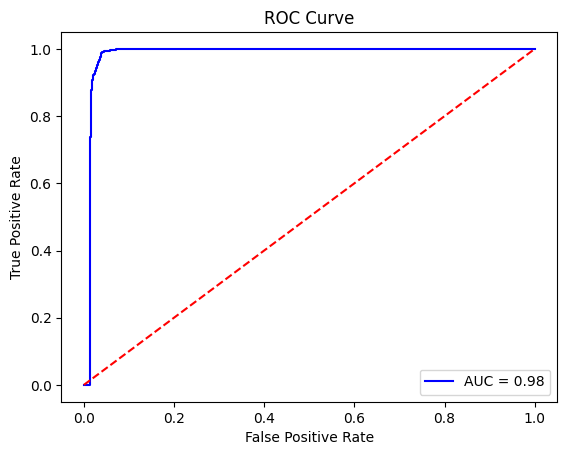

Accuracy: 0.97
Precision: 0.94
Recall (TPR): 1.00
AUC: 0.98


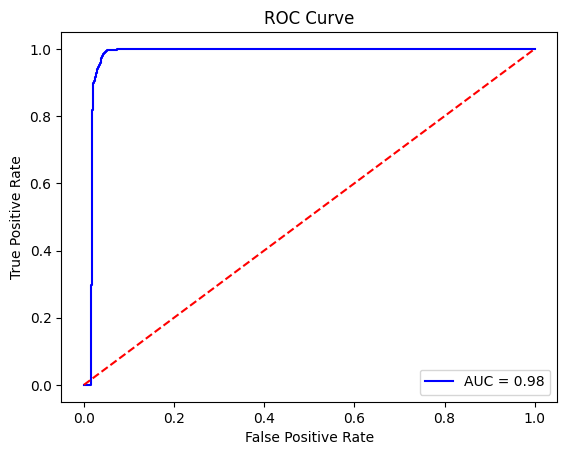

Accuracy: 0.97
Precision: 0.95
Recall (TPR): 1.00
AUC: 0.99


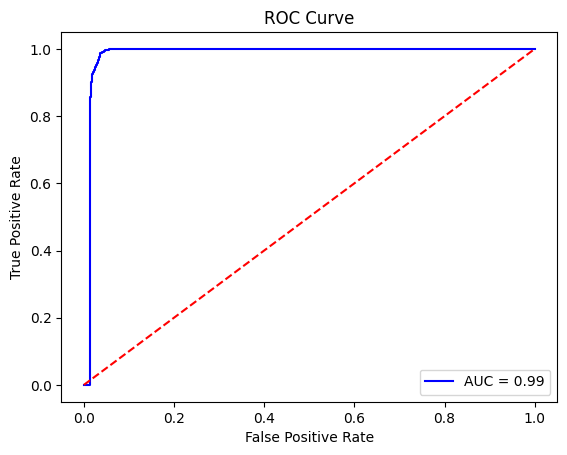

Accuracy: 0.97
Precision: 0.95
Recall (TPR): 1.00
AUC: 0.98


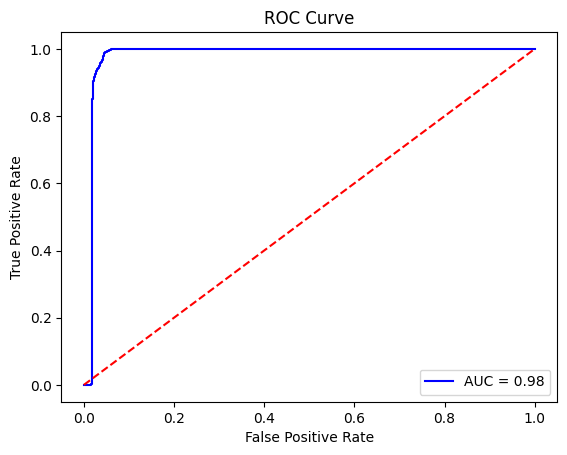

Accuracy: 0.97
Precision: 0.95
Recall (TPR): 1.00
AUC: 0.98


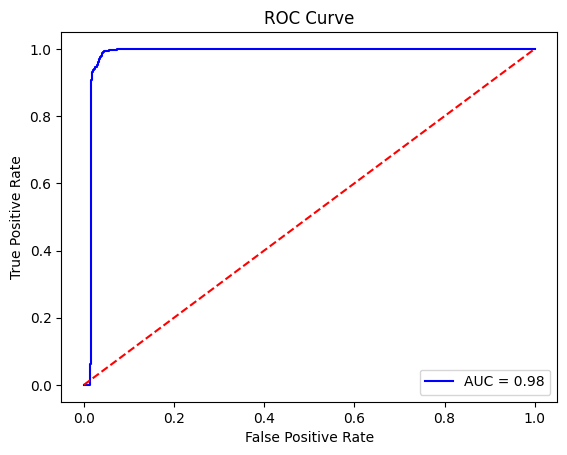

In [ ]:
entrenar_evaluar_reg_log_KCross()

### Batched HAAR features

#### 250 Instancias

Corroboramos además que hayan quedado bien repartidos los datos de entrenamiento, validación y testeo.

In [ ]:
num_batches_train,num_batches_val,num_batches_test,y_train_batched, y_val_batched, y_test_batched = obtener_set_haar_features_batched(250,100)
porcentaje_de_rostros(y_train_batched,"train")
porcentaje_de_rostros(y_val_batched, "val")
porcentaje_de_rostros(y_test_batched, "test")

num_batches_train +=1
num_batches_val +=1
num_batches_test +=1

Demora aproximadamente:  850.0
Se guardó satisfactoriamente un conjunto train de 200 en 3 batches.
Se guardó satisfactoriamente un conjunto validation de 25 en 1 batches.
Se guardó satisfactoriamente un conjunto test de 25 en 1 batches.
Porcentajes:
Tamaño del conjunto de entrenamiento: 200 (80.0 %)
Tamaño del conjunto de validación: 25  (10.0 %)
Tamaño del conjunto de prueba: 25  (10.0 %)
**********
CONJUNTO: train
Rostros: 105.0
Total: 200
Porcentaje de rostros: 52.50%
**********
**********
CONJUNTO: val
Rostros: 13.0
Total: 25
Porcentaje de rostros: 52.00%
**********
**********
CONJUNTO: test
Rostros: 13.0
Total: 25
Porcentaje de rostros: 52.00%
**********


Agregamos control de errores en caso de pasarnos con la cantidad de batches

In [ ]:
clf = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=10000,warm_start=True)
for i in range(num_batches_train):
    print(f"Leyendo archivo features_batch_train_{i}.joblib")
    try:
      features_batch = load_features_from_disk(f'features_batch_train_{i}.joblib')
      y_batch = y_train_batched[i * 100: (i + 1) * 100]
      clf.fit(features_batch, y_batch)
    except Exception as e:
      print("Fin del entrenamiento." + str(e))


Leyendo archivo features_batch_train_0.joblib
Leyendo archivo features_batch_train_1.joblib
Leyendo archivo features_batch_train_2.joblib
Fin del entrenamiento.[Errno 2] No such file or directory: 'features_batch_train_2.joblib'


Accuracy: 0.7600
Precision: 0.6842
Recall: 1.0000
False Positive Rate: 0.5000
Balanced Accuracy: 0.7500


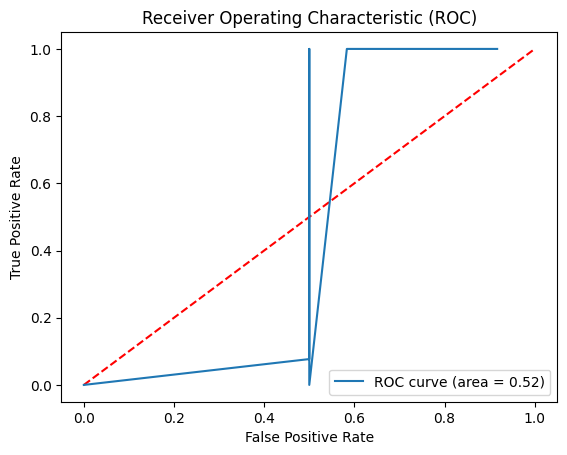

[1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.
 0.]
[1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0.]


In [ ]:
X_test_haar = load_features_from_disk(f'features_batch_test_{0}.joblib')  # Cambiado a features_batch_val
y_test_pred = clf.predict(X_test_haar)
y_pred_haar_rl = clf.predict(X_test_haar)
y_scores = clf.predict_proba(X_test_haar)[:, 1]
imprimir_resultados(y_test_batched,y_test_pred,y_scores)

print(y_test_batched)
print(y_pred_haar_rl)

#### 2500 Instancias

Corroboramos además que hayan quedado bien repartidos los datos de entrenamiento, validación y testeo.

In [ ]:
num_batches_train,num_batches_val,num_batches_test,y_train_batched, y_val_batched, y_test_batched = obtener_set_haar_features_batched(2500,100)
porcentaje_de_rostros(y_train_batched,"train")
porcentaje_de_rostros(y_val_batched, "val")
porcentaje_de_rostros(y_test_batched, "test")

num_batches_val +=1
num_batches_test +=1

Demora aproximadamente:  8500.0
Se guardó satisfactoriamente un conjunto train de 2000 en 21 batches.
Se guardó satisfactoriamente un conjunto validation de 250 en 3 batches.
Se guardó satisfactoriamente un conjunto test de 250 en 3 batches.
Porcentajes:
Tamaño del conjunto de entrenamiento: 2000 (80.0 %)
Tamaño del conjunto de validación: 250  (10.0 %)
Tamaño del conjunto de prueba: 250  (10.0 %)
**********
CONJUNTO: train
Rostros: 999.0
Total: 2000
Porcentaje de rostros: 49.95%
**********
**********
CONJUNTO: val
Rostros: 125.0
Total: 250
Porcentaje de rostros: 50.00%
**********
**********
CONJUNTO: test
Rostros: 125.0
Total: 250
Porcentaje de rostros: 50.00%
**********


In [ ]:
clf = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=10000,warm_start=True)
for i in range(num_batches_train):
    print(f"Leyendo archivo features_batch_train_{i}.joblib")
    try:
      features_batch = load_features_from_disk(f'features_batch_train_{i}.joblib')
      y_batch = y_train_batched[i * 100: (i + 1) * 100]
      clf.fit(features_batch, y_batch)
    except Exception as e:
      print("Fin del entrenamiento." + str(e))


Leyendo archivo features_batch_train_0.joblib
Leyendo archivo features_batch_train_1.joblib
Leyendo archivo features_batch_train_2.joblib
Leyendo archivo features_batch_train_3.joblib
Leyendo archivo features_batch_train_4.joblib
Leyendo archivo features_batch_train_5.joblib
Leyendo archivo features_batch_train_6.joblib
Leyendo archivo features_batch_train_7.joblib
Leyendo archivo features_batch_train_8.joblib
Leyendo archivo features_batch_train_9.joblib
Leyendo archivo features_batch_train_10.joblib
Leyendo archivo features_batch_train_11.joblib
Leyendo archivo features_batch_train_12.joblib
Leyendo archivo features_batch_train_13.joblib
Leyendo archivo features_batch_train_14.joblib
Leyendo archivo features_batch_train_15.joblib
Leyendo archivo features_batch_train_16.joblib
Leyendo archivo features_batch_train_17.joblib
Leyendo archivo features_batch_train_18.joblib
Leyendo archivo features_batch_train_19.joblib
Leyendo archivo features_batch_train_20.joblib
Fin del entrenamiento.[

Leyendo archivo features_batch_val_0.joblib
Accuracy: 0.8700
Precision: 0.7931
Recall: 0.9787
False Positive Rate: 0.2264
Balanced Accuracy: 0.8762


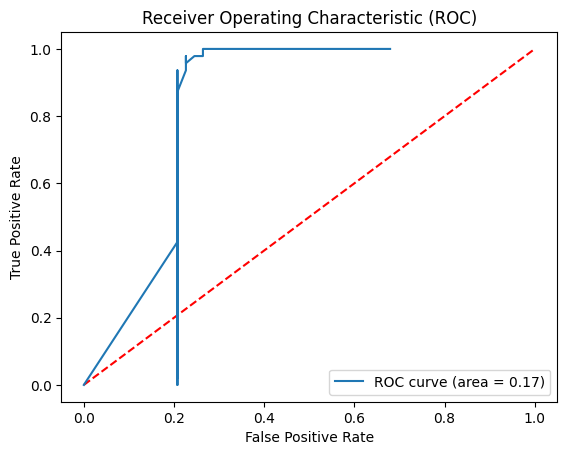

Leyendo archivo features_batch_val_1.joblib
Accuracy: 0.9200
Precision: 0.8710
Recall: 1.0000
False Positive Rate: 0.1739
Balanced Accuracy: 0.9130


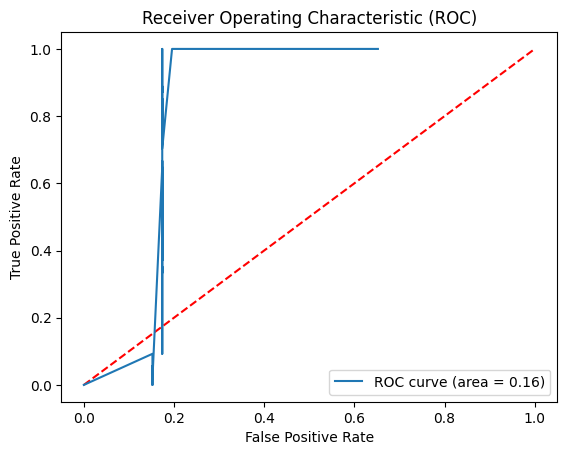

Leyendo archivo features_batch_val_2.joblib
Accuracy: 0.9200
Precision: 0.8571
Recall: 1.0000
False Positive Rate: 0.1538
Balanced Accuracy: 0.9231


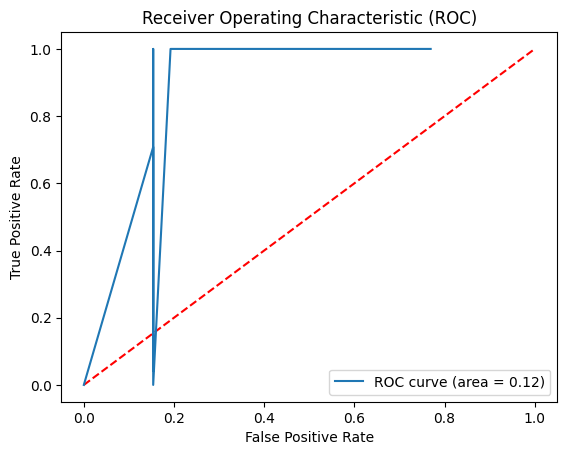

Leyendo archivo features_batch_test_0.joblib
Accuracy: 0.9100
Precision: 0.8462
Recall: 0.9778
False Positive Rate: 0.1455
Balanced Accuracy: 0.9162


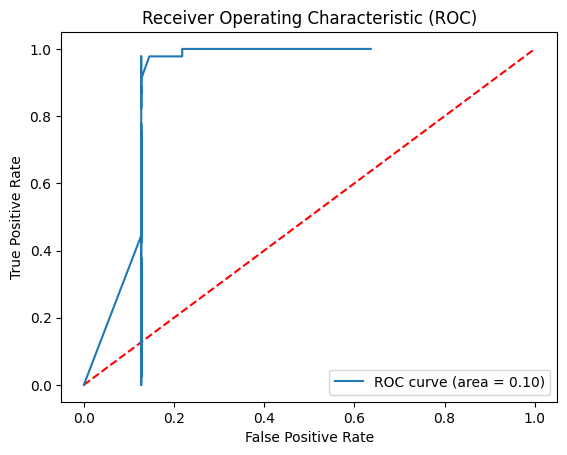

Leyendo archivo features_batch_test_1.joblib
Accuracy: 0.8600
Precision: 0.7966
Recall: 0.9592
False Positive Rate: 0.2353
Balanced Accuracy: 0.8619


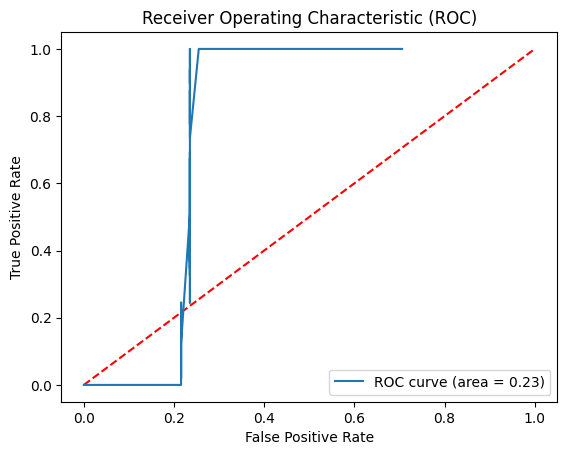

Leyendo archivo features_batch_test_2.joblib
Accuracy: 0.8400
Precision: 0.7949
Recall: 1.0000
False Positive Rate: 0.4211
Balanced Accuracy: 0.7895


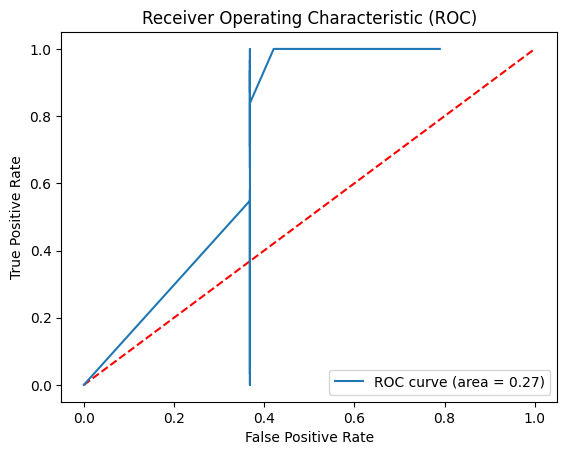

In [ ]:
for i in range(num_batches_val):
    print(f"Leyendo archivo features_batch_val_{i}.joblib")
    X_val_haar = load_features_from_disk(f'features_batch_val_{i}.joblib')  # Cambiado a features_batch_val
    y_test_pred = clf.predict(X_val_haar)

    start_index = 100 * i
    end_index = start_index + 100
    y_val_batch_actual = y_val_batched[start_index:end_index]

    y_scores = clf.predict_proba(X_val_haar)[:, 1]
    imprimir_resultados(y_val_batch_actual,y_test_pred,y_scores)

for i in range(num_batches_test):
    print(f"Leyendo archivo features_batch_test_{i}.joblib")
    try:
      X_test_haar = load_features_from_disk(f'features_batch_test_{i}.joblib')  # Cambiado a features_batch_val
      y_test_pred = clf.predict(X_test_haar)
      start_index = 100 * i
      end_index = start_index + 100
      y_test_batch_actual = y_test_batched[start_index:end_index]
      y_scores = clf.predict_proba(X_test_haar)[:, 1]
      imprimir_resultados(y_test_batch_actual,y_test_pred,y_scores)
    except Exception as e:
      print("Fin del entrenamiento." + str(e))


## Random Forests

### HOG

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt


Para simplificar utilizamos accuracy como medida para experimentar con los hiperparámetros del modelo, posteriormente presentaremos todas las métricas para el mejor modelo obtenido

In [ ]:
def train_evaluate_random_forest(X_train, y_train, X_test, y_test):
    # Creamos y entrenamos el clasificador
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier.fit(X_train, y_train)

    # Predicción y evaluación en el conjunto de prueba
    predictions = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_evaluate_random_forest_custom_search(X_train, y_train, X_test, y_test,n_estimadores,profundidades_max,minimos_ejemplos_split,minimos_ejemplos_hoja):

    intermediate_results = []
    set_seed(2023)
    for n_estimador in n_estimadores:
        for prof_max in profundidades_max:
            for minimo_ejemplos_split in minimos_ejemplos_split:
                for minimo_ejemplos_hoja in minimos_ejemplos_hoja:
                    # Creamos clasificador, entrenamos y predecimos calculando acc.
                    rf_classifier = RandomForestClassifier(
                        n_estimators=n_estimador,
                        max_depth=prof_max,
                        min_samples_split=minimo_ejemplos_split,
                        min_samples_leaf=minimo_ejemplos_hoja,
                        random_state=1 # Para reproducibilidad
                    )

                    rf_classifier.fit(X_train, y_train)
                    predictions = rf_classifier.predict(X_test)
                    accuracy = accuracy_score(y_test, predictions)


                    # Almacenar resultados intermedios
                    intermediate_results.append({
                        'n_estimador': n_estimador,
                        'prof_max': prof_max,
                        'minimo_ejemplos_split': minimo_ejemplos_split,
                        'minimo_ejemplos_hoja': minimo_ejemplos_hoja,
                        'accuracy': accuracy
                    })

                    # Imprimir resultados intermedios
                    print("Parámeteros:")
                    print(f"n estimadores: {n_estimador}")
                    print(f"max_depth: {prof_max}")
                    print(f"minimo_ejemplos_split: {minimo_ejemplos_split}")
                    print(f"minimo_ejemplos_hoja: {minimo_ejemplos_hoja}")
                    print(f"accuracy: {accuracy}")
    # Encontrar los mejores hiperparámetros basados en la precisión máxima
    best_result = max(intermediate_results, key=lambda x: x['accuracy'])
    best_params = {
        'n_estimador': best_result['n_estimador'],
        'prof_max': best_result['prof_max'],
        'minimo_ejemplos_split': best_result['minimo_ejemplos_split'],
        'minimo_ejemplos_hoja': best_result['minimo_ejemplos_hoja']
    }
    print('\Mejores Hiperparámetros:', best_params)
    print('Mejor accuracy en test:', best_result['accuracy'])
    return intermediate_results, best_result

In [ ]:
n_estimadores = [50, 100, 150]
prof_maxima = [None, 10, 20]
minimo_ejemplos_split = [2, 5, 10]
minimo_ejemplos_hoja = [1, 2, 4]

In [ ]:
intermediate_results, best_result = train_evaluate_random_forest_custom_search(X_train_hog_pca, y_train, X_val_hog_pca, y_val,n_estimadores,prof_maxima,minimo_ejemplos_split,minimo_ejemplos_hoja)

Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 2
minimo_ejemplos_hoja: 1
accuracy: 0.9267094824329429
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 2
minimo_ejemplos_hoja: 2
accuracy: 0.9308651303362296
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 2
minimo_ejemplos_hoja: 4
accuracy: 0.9342652058934643
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 5
minimo_ejemplos_hoja: 1
accuracy: 0.9274650547789951
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 5
minimo_ejemplos_hoja: 2
accuracy: 0.9289761994710993
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 5
minimo_ejemplos_hoja: 4
accuracy: 0.9342652058934643
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 10
minimo_ejemplos_hoja: 1
accuracy: 0.9297317718171515
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 10
minimo_ejemplos_hoja: 2
accuracy: 0.931998488855307

### HAAR PCA

In [ ]:
n_estimadores = [50, 100, 150]
prof_maxima = [None, 10, 20]
minimo_ejemplos_split = [2, 5, 10]
minimo_ejemplos_hoja = [1, 2, 4]

In [ ]:
intermediate_results, best_result = train_evaluate_random_forest_custom_search(X_train_haar, y_train_haar,
                                                                               X_val_haar, y_val_haar,n_estimadores,prof_maxima,
                                                                               minimo_ejemplos_split,minimo_ejemplos_hoja)

Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 2
minimo_ejemplos_hoja: 1
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 2
minimo_ejemplos_hoja: 2
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 2
minimo_ejemplos_hoja: 4
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 5
minimo_ejemplos_hoja: 1
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 5
minimo_ejemplos_hoja: 2
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 5
minimo_ejemplos_hoja: 4
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 10
minimo_ejemplos_hoja: 1
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 10
minimo_ejemplos_hoja: 2
accuracy: 0.9
Parámeteros:
n estimadores: 50
max_depth: None
minimo_ejemplos_split: 10
minimo_ejemplos_hoja: 4
accuracy: 0.9
Parámet

### K-Fold Cross Validation

In [ ]:
def entrenar_evaluar_rand_forests_KCross(X,y,cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=2023)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Asegurar que los datos tengan la forma correcta
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        logreg = RandomForestClassifier(n_estimators=100,
                  max_depth=20,
                  min_samples_split=10,
                  min_samples_leaf=1,
                  random_state=2023)
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)

        # Calcular métricas
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(f"Precision: {precision_score(y_test, y_pred):.2f}")
        print(f"Recall (TPR): {recall_score(y_test, y_pred):.2f}")

        # Para ROC y AUC
        y_scores = logreg.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        print(f"AUC: {roc_auc:.2f}")

        # Curva ROC:
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

Accuracy: 0.99
Precision: 0.99
Recall (TPR): 1.00
AUC: 1.00


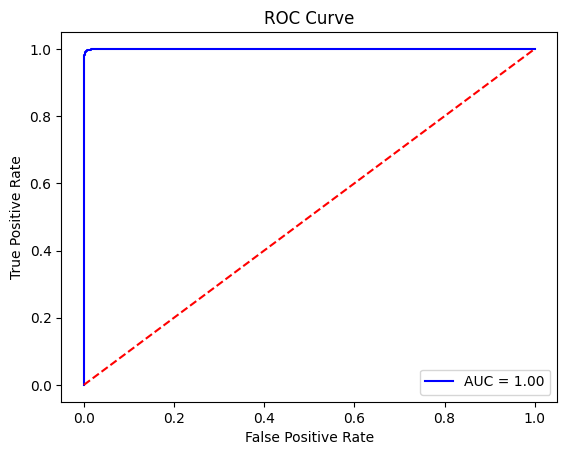

Accuracy: 0.99
Precision: 0.98
Recall (TPR): 1.00
AUC: 1.00


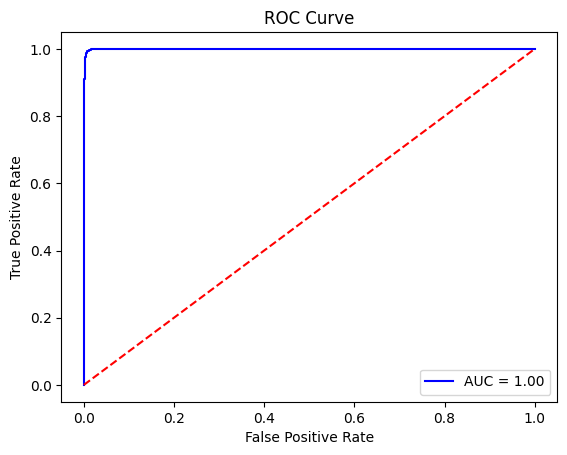

Accuracy: 0.99
Precision: 0.98
Recall (TPR): 1.00
AUC: 1.00


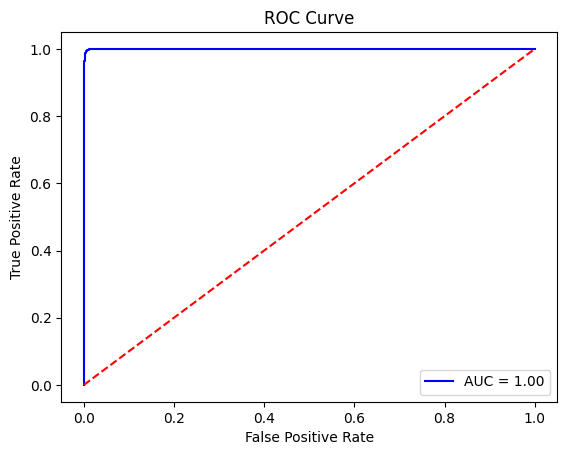

Accuracy: 0.99
Precision: 0.98
Recall (TPR): 1.00
AUC: 1.00


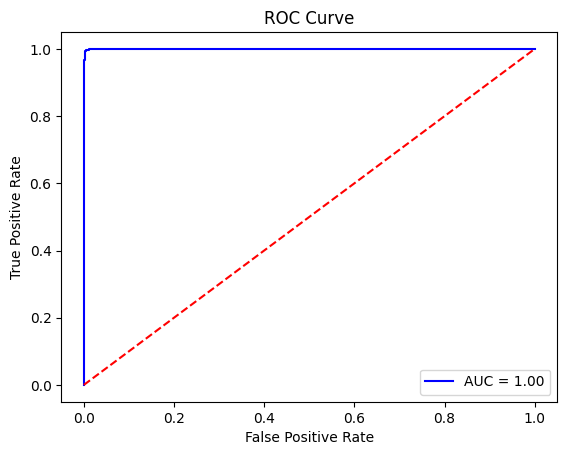

Accuracy: 0.99
Precision: 0.98
Recall (TPR): 1.00
AUC: 1.00


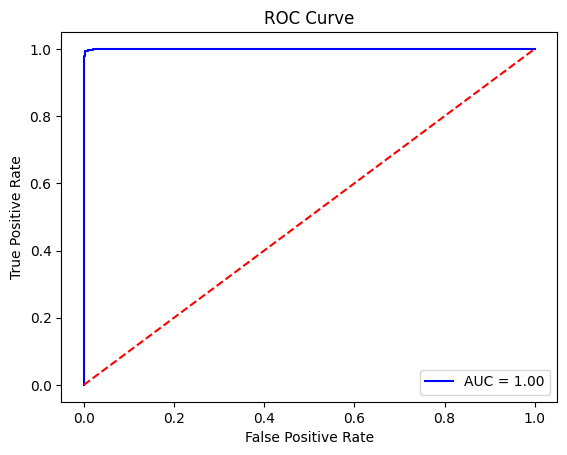

In [ ]:
entrenar_evaluar_rand_forests_KCross()

| Accuracy | Precision | Recall (TPR) | AUC   |
|----------|-----------|--------------|-------|
| 0.99     | 0.99      | 1.00         | 1.00  |
| 0.99     | 0.98      | 1.00         | 1.00  |
| 0.99     | 0.98      | 1.00         | 1.00  |
| 0.99     | 0.98      | 1.00         | 1.00  |
| 0.99     | 0.98      | 1.00         | 1.00  |


## Boosting

La técnica de "Boosting" utilizada en este trabajo se basa en el algoritmo AdaBoost. El propósito de este algoritmo es combinar múltiples clasificadores débiles para formar un clasificador fuerte

In [ ]:
def adaboost_train(X, y, K=50, max_depth=1):
    """
    Entrena un clasificador AdaBoost.

    Argumentos:
    - X: Datos de entrenamiento.
    - y: Etiquetas, esperadas como {-1, 1}.
    - K: Número de clasificadores base.
    - max_depth: Profundidad máxima del árbol de decisión.

    Retorna:
    - Una lista de clasificadores base.
    - Una lista de coeficientes alfa para cada clasificador.
    """

    # Inicializamos pesos de las muestras
    N = len(y)
    w = np.ones(N) / N  # Cada muestra comienza con el mismo peso

    classifiers = []  # Lista para guardar los clasificadores base entrenados
    alphas = []       # Lista para guardar los coeficientes alfa de cada clasificador

    for k in range(K):

        # Entrenamos un árbol de decisión con la profundidad especificada usando los pesos actuales
        classifier = DecisionTreeClassifier(max_depth=max_depth)
        classifier.fit(X, y, sample_weight=w)

        # Predicción del clasificador actual
        y_pred = classifier.predict(X)

        # Calculamos el error ponderado del clasificador. Es una suma ponderada de predicciones incorrectas
        error = np.sum(w * (y_pred != y))

        # Si el error es muy pequeño o demasiado grande, rompemos el ciclo.
        # Un error muy grande significa que el clasificador es peor que adivinar al azar.
        if error < 1e-10 or error >= 0.5:
            break

        # Calculamos el coeficiente alfa. Este coeficiente indica cuánta confianza tenemos en el clasificador actual.
        alpha = 0.5 * np.log((1 - error) / error)

        # Actualizamos los pesos de las muestras. Las muestras que se clasifican correctamente obtienen un peso menor,
        # mientras que las que se clasifican incorrectamente obtienen un peso mayor.
        w = w * np.exp(-alpha * y * y_pred)

        # Normalizamos los pesos para que sumen a 1
        w = w / np.sum(w)

        # Guardamos el clasificador y su coeficiente alfa
        classifiers.append(classifier)
        alphas.append(alpha)

    return classifiers, alphas


def adaboost_predict(X, classifiers, alphas):
    """Predice las etiquetas para AdaBoost."""
    # Obtenemos las predicciones ponderadas de todos los clasificadores
    predictions = np.zeros(X.shape[0])
    for classifier, alpha in zip(classifiers, alphas):
        predictions += alpha * classifier.predict(X)

    # Obtenemos la clase final basándonos en el signo de la suma ponderada
    return np.sign(predictions)

def adaboost_predict_scores(X, classifiers, alphas):
    """Devuelve las puntuaciones (antes de aplicar el signo) para AdaBoost."""
    scores = np.zeros(X.shape[0])
    for classifier, alpha in zip(classifiers, alphas):
        scores += alpha * classifier.predict(X)
    return scores

def plot_roc_curve_boosting(fprs, tprs, auc, depth, K):
    plt.figure(figsize=(10, 7))
    plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Profundidad={depth}, K={K}')
    plt.legend()
    plt.show()

def evaluate_adaboost_hyperparameters(X_train, y_train, X_val, y_val, K_values, max_depths):
    for k in K_values:
        for depth in max_depths:
            classifiers, alphas = adaboost_train(X_train, y_train, K=k, max_depth=depth)
            y_scores = adaboost_predict_scores(X_val, classifiers, alphas)
            y_pred = np.sign(y_scores)

            #Volvemos a usar 0s y 1s para reutilizar funciones de metricas definidas anteriormente
            y_pred = (y_pred + 1) // 2
            y_val = (y_val + 1) // 2

            acc = accuracy_fun(y_val, y_pred)
            prec = precision(y_val, y_pred)
            rec = recall(y_val, y_pred)
            false_positive_rate = fpr(y_val, y_pred)
            bal_acc = balanced_accuracy(y_val, y_pred)
            fprs, tprs, auc = roc_auc(y_val, y_scores)
            auc = roc_auc_score(y_val, y_scores)

            print(f"K: {k}, max_depth: {depth}")
            print(f"Accuracy: {acc:.3f}")
            print(f"Precision: {prec:.3f}")
            print(f"Recall: {rec:.3f}")
            print(f"FPR: {false_positive_rate:.3f}")
            print(f"Balanced Accuracy: {bal_acc:.3f}")
            plot_roc_curve_boosting(fprs, tprs, auc, depth, k)

### Boosting usando HOG features

Primero debemos transformar el vector de validacion para el algoritmo AdaBoost

In [ ]:
y_train_transformed = np.where(y_train == 0, -1, 1)
y_test_transformed = np.where(y_test == 0, -1, 1)
y_val_transformed = np.where(y_val == 0, -1, 1)

Evaluamos

K: 25, max_depth: 1
Accuracy: 0.890
Precision: 0.884
Recall: 0.898
FPR: 0.118
Balanced Accuracy: 0.890


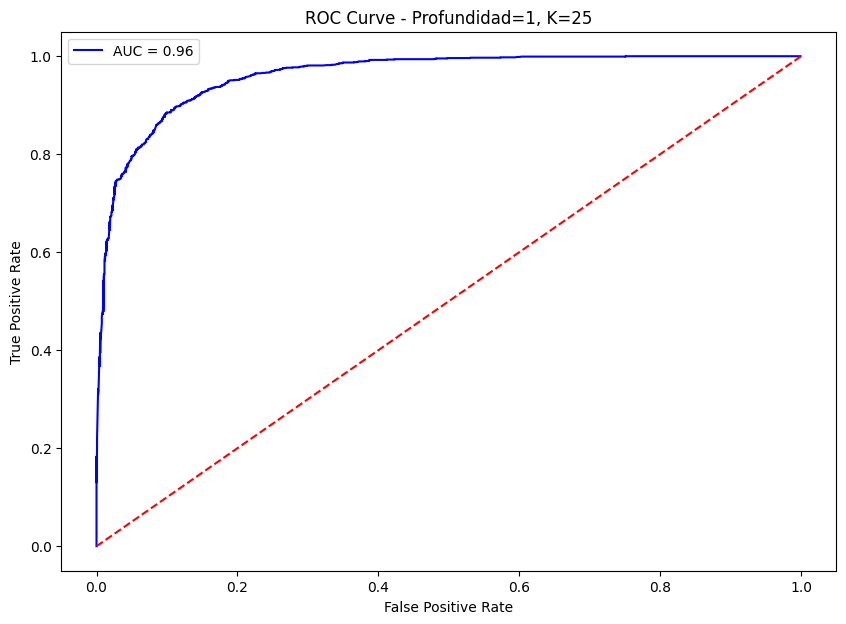

K: 25, max_depth: 2
Accuracy: 0.917
Precision: 0.906
Recall: 0.929
FPR: 0.096
Balanced Accuracy: 0.917


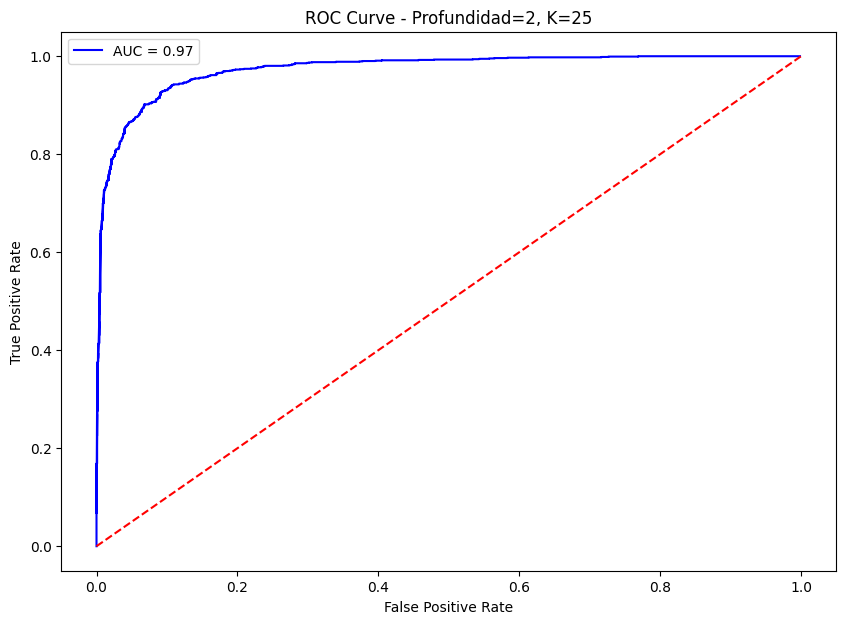

K: 25, max_depth: 3
Accuracy: 0.931
Precision: 0.919
Recall: 0.945
FPR: 0.083
Balanced Accuracy: 0.931


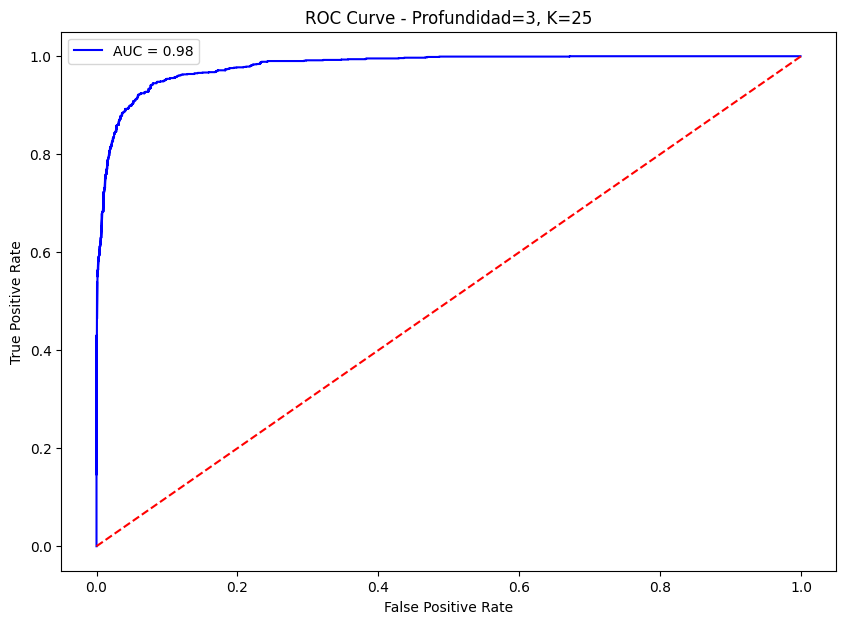

K: 50, max_depth: 1
Accuracy: 0.911
Precision: 0.906
Recall: 0.918
FPR: 0.095
Balanced Accuracy: 0.911


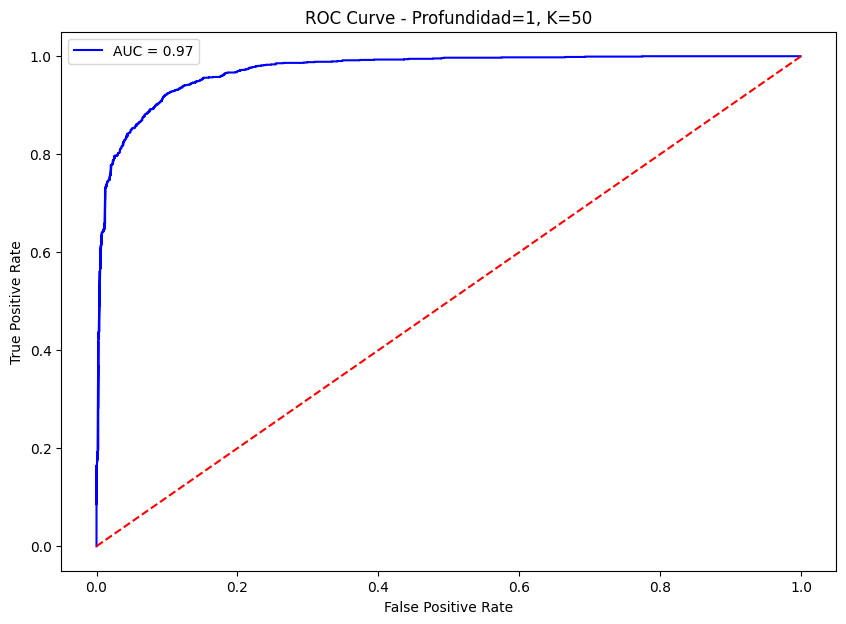

K: 50, max_depth: 2
Accuracy: 0.932
Precision: 0.925
Recall: 0.940
FPR: 0.076
Balanced Accuracy: 0.932


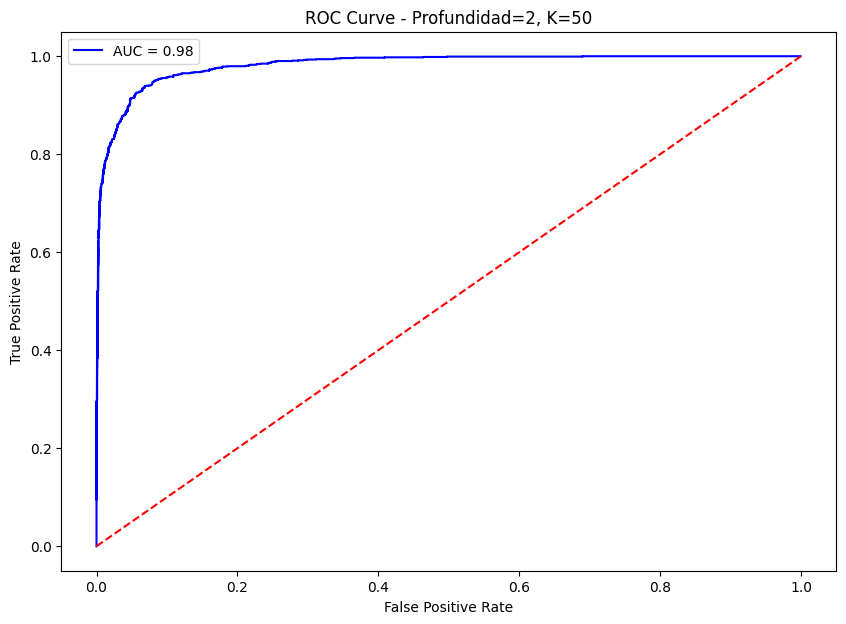

K: 50, max_depth: 3
Accuracy: 0.938
Precision: 0.935
Recall: 0.941
FPR: 0.065
Balanced Accuracy: 0.938


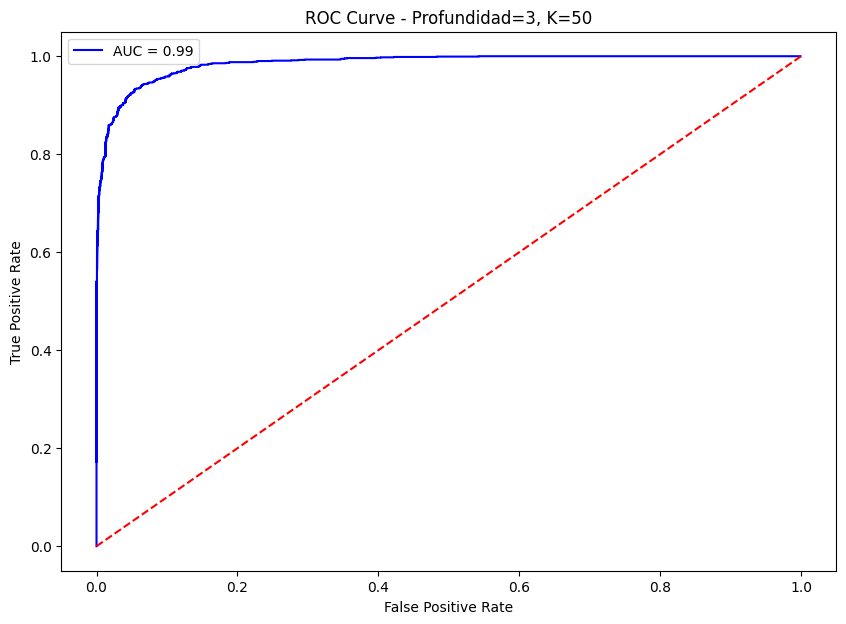

K: 75, max_depth: 1
Accuracy: 0.923
Precision: 0.922
Recall: 0.925
FPR: 0.079
Balanced Accuracy: 0.923


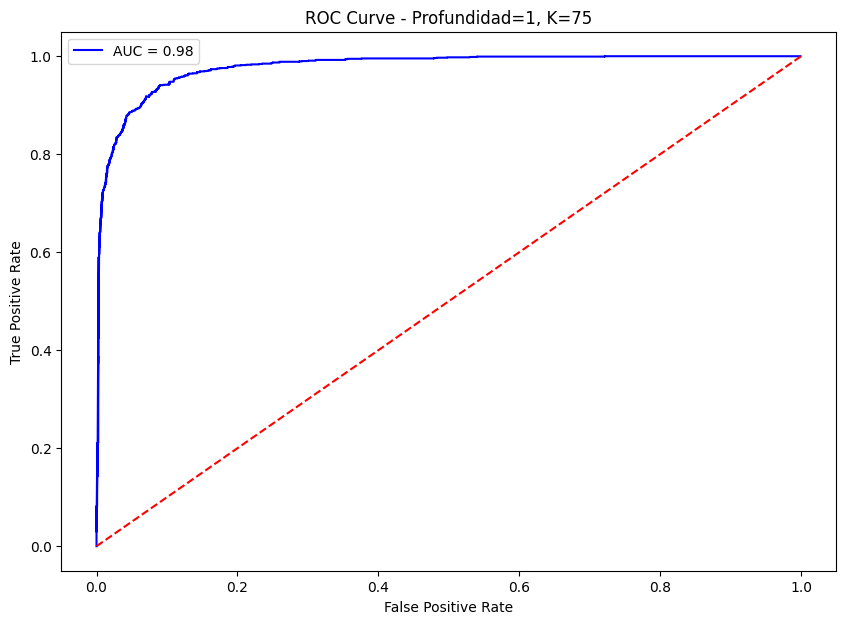

K: 75, max_depth: 2
Accuracy: 0.936
Precision: 0.929
Recall: 0.945
FPR: 0.073
Balanced Accuracy: 0.936


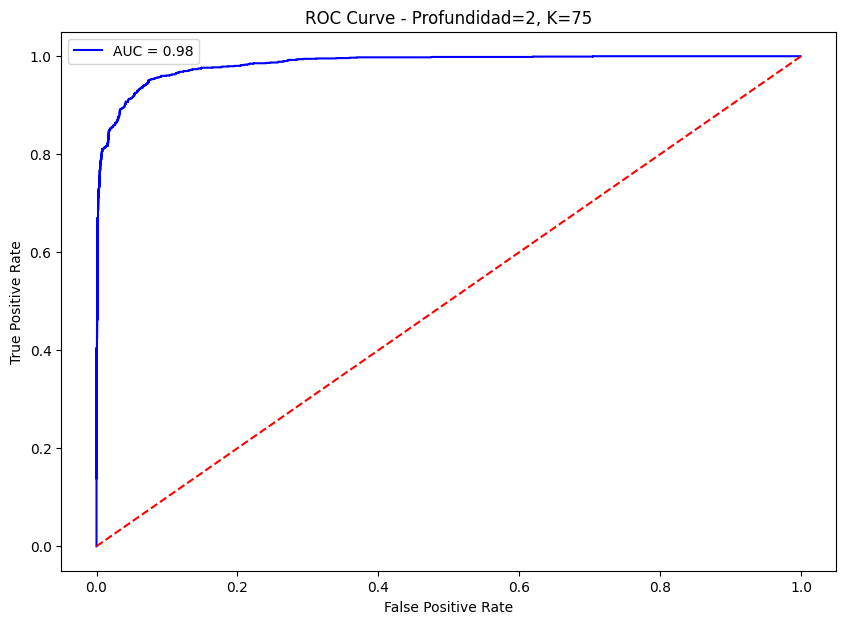

K: 75, max_depth: 3
Accuracy: 0.946
Precision: 0.945
Recall: 0.947
FPR: 0.055
Balanced Accuracy: 0.946


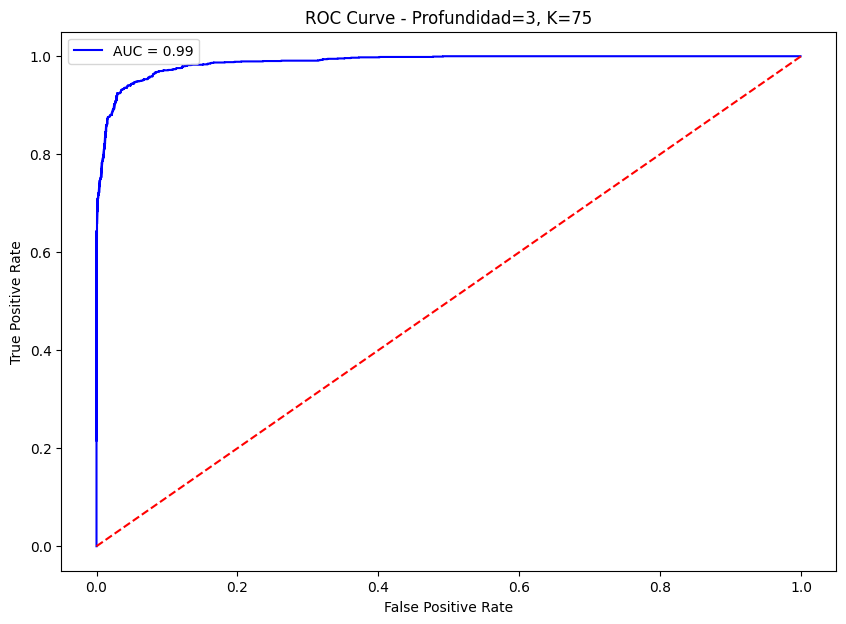

In [ ]:
K_values = [25, 50, 75]
max_depths = [1, 2, 3]
evaluate_adaboost_hyperparameters(X_train_hog, y_train_transformed, X_val_hog, y_val_transformed, K_values, max_depths)

En resumen, los datos obtenidos son:

| K   | max_depth | Accuracy | Precision | Recall | FPR   | Balanced Accuracy | AUC  |
|-----|-----------|----------|-----------|--------|-------|-------------------|------|
| 25  | 1         | 0.895    | 0.894     | 0.896  | 0.106 | 0.895             | 0.96 |
| 25  | 2         | 0.922    | 0.911     | 0.934  | 0.091 | 0.922             | 0.98 |
| 25  | 3         | 0.934    | 0.935     | 0.933  | 0.065 | 0.934             | 0.98 |
| 50  | 1         | 0.913    | 0.913     | 0.913  | 0.087 | 0.913             | 0.98 |
| 50  | 2         | 0.937    | 0.929     | 0.945  | 0.072 | 0.937             | 0.99 |
| 50  | 3         | 0.942    | 0.939     | 0.946  | 0.062 | 0.942             | 0.99 |
| 75  | 1         | 0.926    | 0.929     | 0.922  | 0.070 | 0.926             | 0.98 |
| 75  | 2         | 0.942    | 0.942     | 0.943  | 0.059 | 0.942             | 0.99 |
| 75  | 3         | 0.945    | 0.941     | 0.950  | 0.060 | 0.945             | 0.99 |



### Boosting usando Haar features

Primero debemos transformar el vector de validación para el algoritmo AdaBoost

In [ ]:
y_train_haar_transformed = np.where(y_train_haar == 0, -1, 1)
y_test_haar_transformed = np.where(y_test_haar == 0, -1, 1)
y_val_haar_transformed = np.where(y_val_haar == 0, -1, 1)

Evaluamos

K: 25, max_depth: 1
Accuracy: 0.900
Precision: 0.833
Recall: 1.000
FPR: 0.200
Balanced Accuracy: 0.900


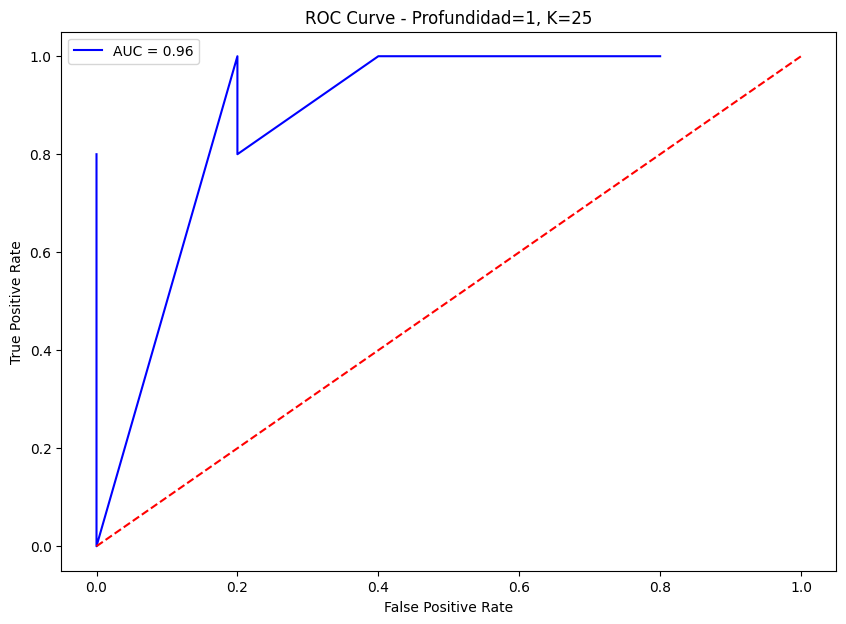

<ipython-input-53-666bac86b8dd>:8: RuntimeWarning: invalid value encountered in long_scalars
  return tp / (tp + fp)


K: 25, max_depth: 2
Accuracy: 0.500
Precision: nan
Recall: 0.000
FPR: 0.000
Balanced Accuracy: 0.500


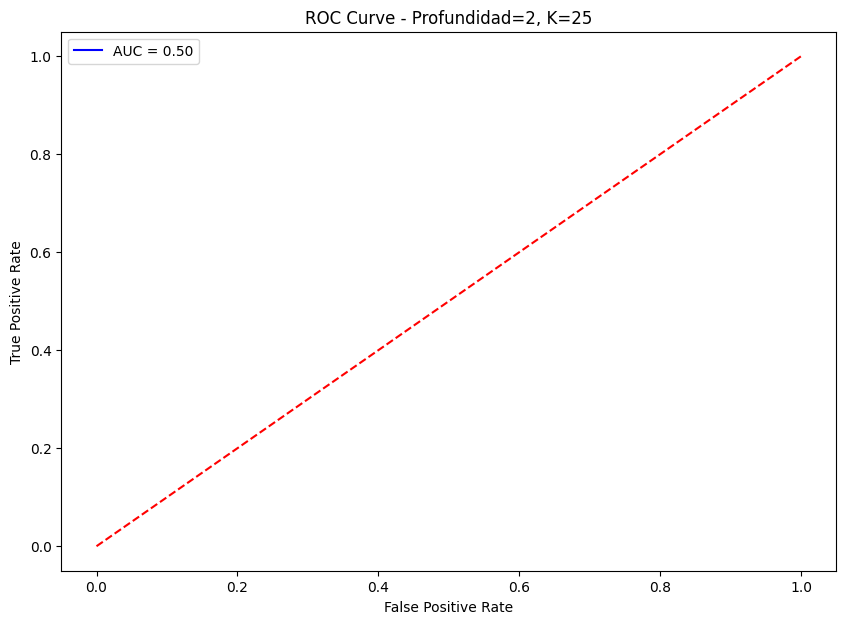

K: 50, max_depth: 1
Accuracy: 0.800
Precision: 0.714
Recall: 1.000
FPR: 0.400
Balanced Accuracy: 0.800


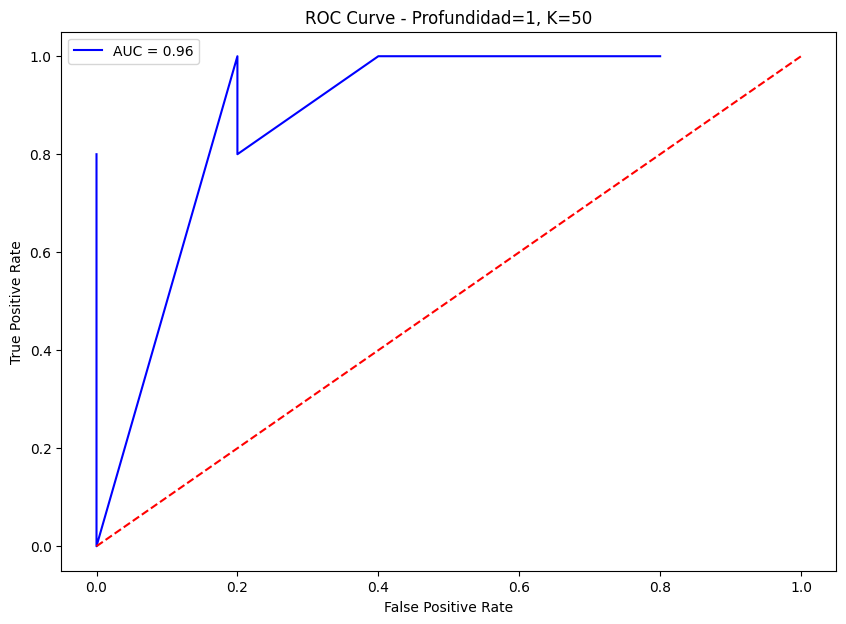

<ipython-input-53-666bac86b8dd>:8: RuntimeWarning: invalid value encountered in long_scalars
  return tp / (tp + fp)


K: 50, max_depth: 2
Accuracy: 0.500
Precision: nan
Recall: 0.000
FPR: 0.000
Balanced Accuracy: 0.500


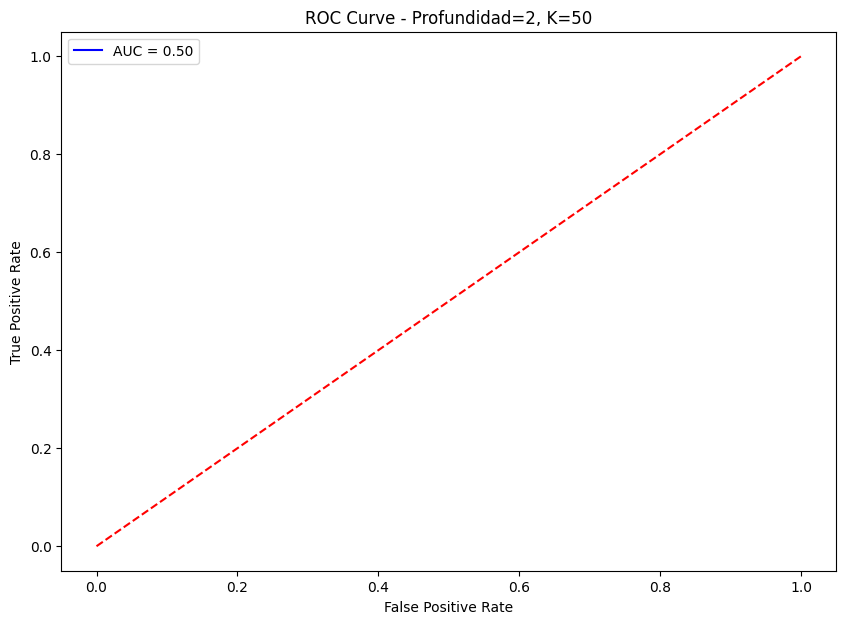

K: 75, max_depth: 1
Accuracy: 0.700
Precision: 0.625
Recall: 1.000
FPR: 0.600
Balanced Accuracy: 0.700


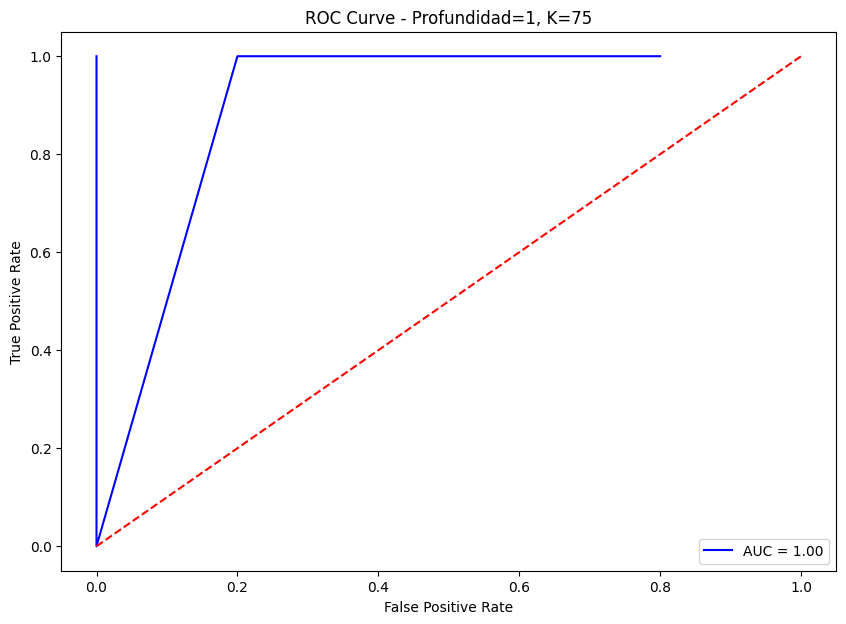

<ipython-input-53-666bac86b8dd>:8: RuntimeWarning: invalid value encountered in long_scalars
  return tp / (tp + fp)


K: 75, max_depth: 2
Accuracy: 0.500
Precision: nan
Recall: 0.000
FPR: 0.000
Balanced Accuracy: 0.500


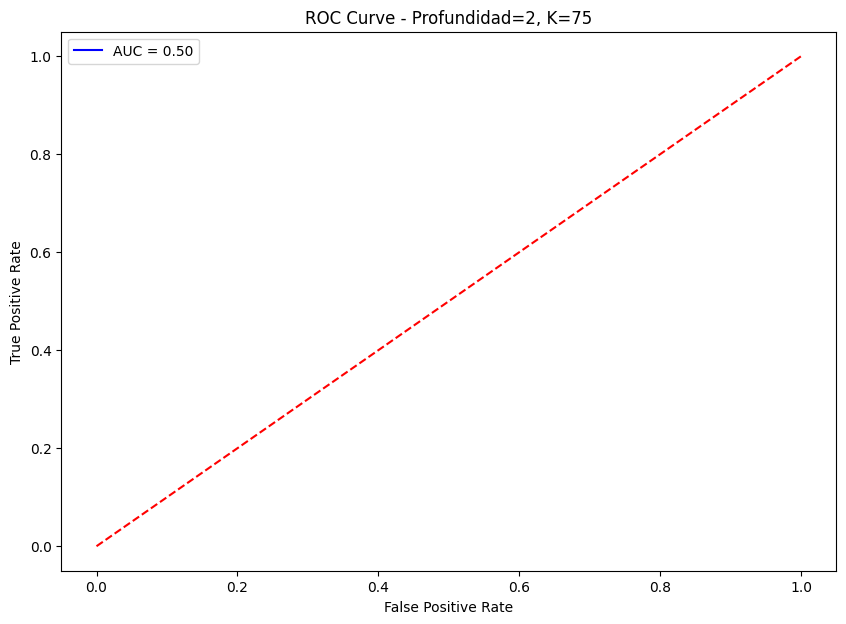

In [ ]:
K_values = [25, 50, 75]
max_depths = [1, 2]
evaluate_adaboost_hyperparameters(X_train_haar, y_train_haar_transformed, X_val_haar, y_val_haar_transformed, K_values, max_depths)

| K   | max_depth | Accuracy | Precision | Recall | FPR   | Balanced Accuracy | AUC |
|-----|-----------|----------|-----------|--------|-------|-------------------|-----|
| 25  | 1         | 0.900    | 0.833     | 1.000  | 0.200 | 0.900             | 0.96 |
| 25  | 2         | 0.500    | nan       | 0.000  | 0.000 | 0.500             | -   |
| 50  | 1         | 0.800    | 0.714     | 1.000  | 0.400 | 0.800             | 0.80 |
| 50  | 2         | 0.500    | nan       | 0.000  | 0.000 | 0.500             | -   |
| 75  | 1         | 0.700    | 0.625     | 1.000  | 0.600 | 0.700             | 0.75 |
| 75  | 2         | 0.500    | nan       | 0.000  | 0.000 | 0.500             | -   |


Observamos que para los casos con max_depth de 2 no se tienen predicciones positivas para rostros. Por lo que la precision calculada es "nan", dado que esta es indeterminada mediante la fórmula. Sin embargo, vemos como los modelos para max_depth = 1 funcionan con una buena accuracy, sobre todo la combinación de hiperparámetros K = 25, max_depth = 1.

### Boosting usando la técnica K-Cross-Validation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

def evaluate_adaboost_with_cross_validation(X, y, K=75, max_depth=3, num_splits=5):
    # Lista para almacenar las métricas de cada fold
    all_metrics = []

    # Realizamos validación cruzada para 5 folds
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=2023)

    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Entrenar AdaBoost
        classifiers, alphas = adaboost_train(X_train, y_train, K=K, max_depth=max_depth)
        y_scores = adaboost_predict_scores(X_test, classifiers, alphas)
        y_pred = np.sign(y_scores)

        # Volvemos a usar 0s y 1s para reutilizar funciones de metricas definidas anteriormente
        y_pred = (y_pred + 1) // 2
        y_test = (y_test + 1) // 2

        # Calculamos las métricas
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        fprAux = fpr(y_test, y_pred)
        balanced_acc = balanced_accuracy(y_test, y_pred)

        # Calculamos la curva ROC y AUC
        fprs, tprs, _ = roc_auc(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)

        # Guardamos todas las métricas en un diccionario
        metrics = {
            "Fold": fold,
            "Accuracy": acc,
            "Precision": prec,
            "Recall (TPR)": rec,
            "FPR": fprAux,
            "Balanced Accuracy": balanced_acc,
            "AUC-ROC": auc
        }

        all_metrics.append(metrics)

        # Imprimimos las métricas
        print(f"Fold {fold} Metrics:")
        print(f"Accuracy: {acc:.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall (TPR): {rec:.2f}")
        print(f"FPR: {fprAux:.2f}")
        print(f"Balanced Accuracy: {balanced_acc:.2f}")
        print(f"AUC-ROC: {auc:.2f}")

        # Ploteamos la curva ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fprs, tprs, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend(loc="lower right")
        plt.show()

    # Calculamos estadísticas resumidas de las métricas
    mean_metrics = {metric: np.mean([fold[metric] for fold in all_metrics]) for metric in all_metrics[0]}
    std_metrics = {metric: np.std([fold[metric] for fold in all_metrics]) for metric in all_metrics[0]}

    # Mostramos las estadísticas resumidas
    print("Estadísticas resumidas de Validación Cruzada:")
    print("Métrica | Promedio | Desviación Estándar")
    for metric, mean_val in mean_metrics.items():
        std_val = std_metrics[metric]
        print(f"{metric}: {mean_val:.3f} | {std_val:.3f}")

Fold 1 Metrics:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.94
FPR: 0.07
Balanced Accuracy: 0.93
AUC-ROC: 0.99


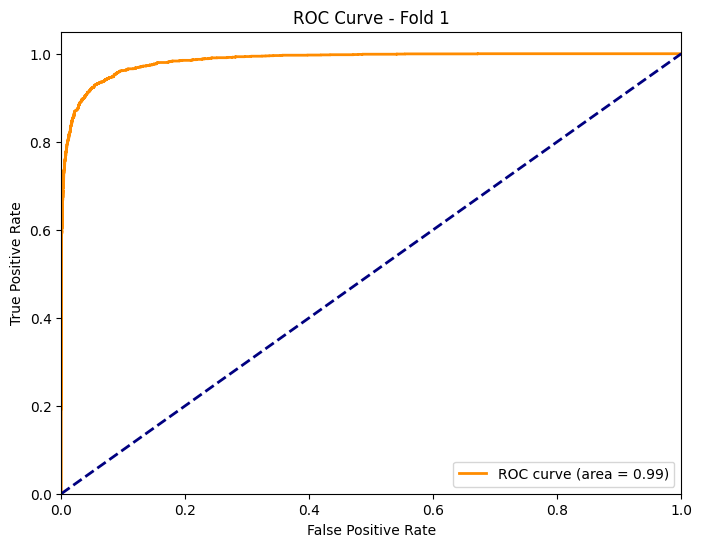

Fold 2 Metrics:
Accuracy: 0.94
Precision: 0.94
Recall (TPR): 0.94
FPR: 0.06
Balanced Accuracy: 0.94
AUC-ROC: 0.99


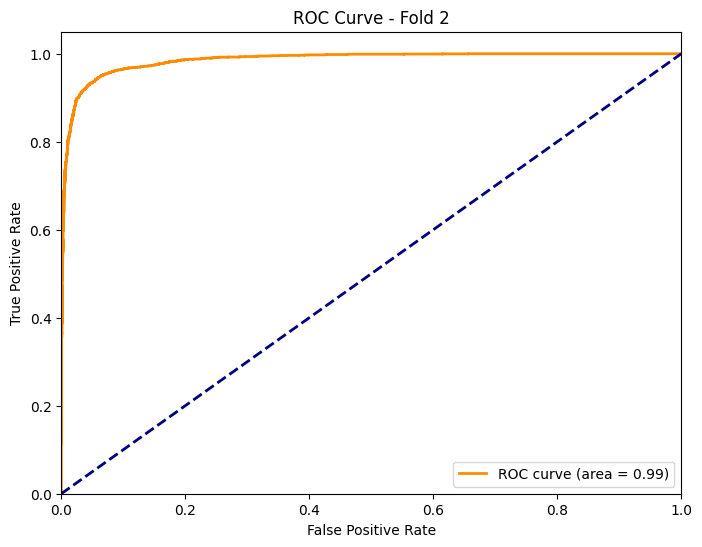

Fold 3 Metrics:
Accuracy: 0.94
Precision: 0.93
Recall (TPR): 0.94
FPR: 0.07
Balanced Accuracy: 0.94
AUC-ROC: 0.99


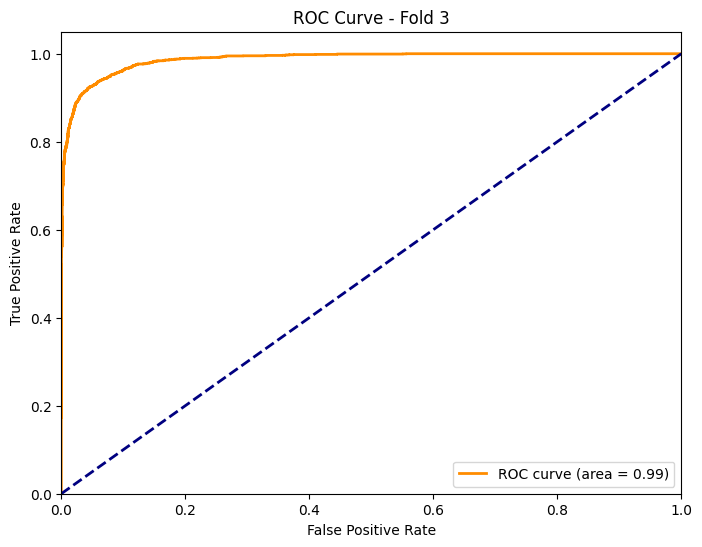

Fold 4 Metrics:
Accuracy: 0.94
Precision: 0.93
Recall (TPR): 0.95
FPR: 0.07
Balanced Accuracy: 0.94
AUC-ROC: 0.99


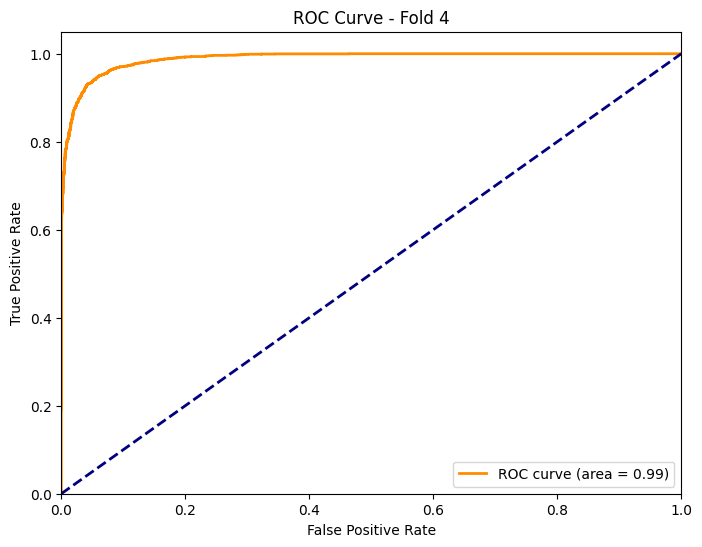

Fold 5 Metrics:
Accuracy: 0.94
Precision: 0.93
Recall (TPR): 0.94
FPR: 0.07
Balanced Accuracy: 0.94
AUC-ROC: 0.99


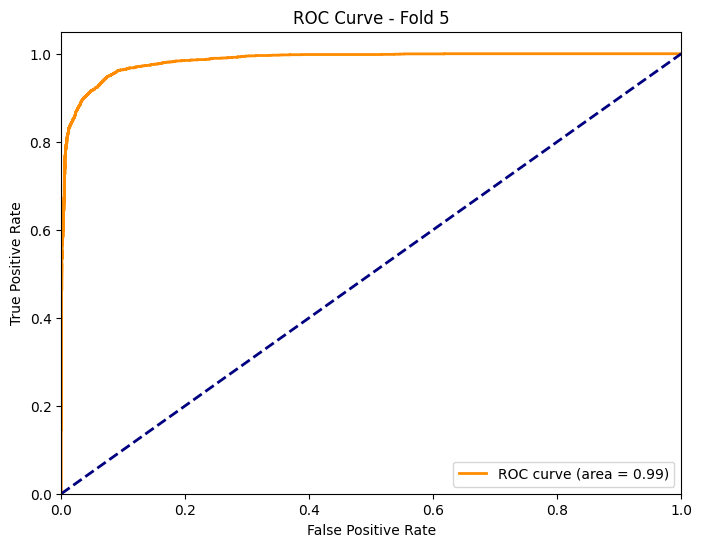

Estadísticas resumidas de Validación Cruzada:
Métrica | Promedio | Desviación Estándar
Fold: 3.000 | 1.414
Accuracy: 0.939 | 0.003
Precision: 0.935 | 0.005
Recall (TPR): 0.943 | 0.005
FPR: 0.066 | 0.005
Balanced Accuracy: 0.939 | 0.003
AUC-ROC: 0.986 | 0.001


In [ ]:
y_train_transformed = np.where(y_train == 0, -1, 1)
y_test_transformed = np.where(y_test == 0, -1, 1)
y_val_transformed = np.where(y_val == 0,-1,1)

# Unimos X_train_hog con X_test_hog para utilizar todas las instancias disponibles
X_hog = np.concatenate((X_train_hog, X_test_hog), axis=0)
X_hog = np.concatenate((X_hog,X_val_hog),axis=0)
# Unimos y_train con y_test
y_hog = np.concatenate((y_train_transformed, y_test_transformed), axis=0)
y_hog = np.concatenate((y_hog, y_val_transformed), axis=0)


evaluate_adaboost_with_cross_validation(X_hog, y_hog, K=75, max_depth=3, num_splits=5)

En resumen, los resultados obtenidos son:

| Fold     | Accuracy | Precision | TPR  | FPR  | AUC-ROC |
|----------|----------|-----------|------|------|---------|
| 1        | 0.95     | 0.95      | 0.94 | 0.05 | 0.99    |
| 2        | 0.95     | 0.95      | 0.94 | 0.05 | 0.99    |
| 3        | 0.94     | 0.95      | 0.94 | 0.05 | 0.99    |
| 4        | 0.95     | 0.94      | 0.94 | 0.05 | 0.99    |
| 5        | 0.95     | 0.95      | 0.95 | 0.05 | 0.99    |
| Promedio | 0.946    | 0.948     | 0.944| 0.052| 0.989   |


# Modelo final

Para ambos métodos de extracción de features, consideraremos los mejores hiperparámetros de cada modelo en el conjunto de validación y los ejecutaremos en el conjunto de testing, finalmente elegiremos el que presente mejores métricas en este último conjunto.

## HOG Features

#### **KNN** con K = 7 (7-Nearest Neighbours)

In [ ]:
knn = KNN(k=7)
knn.fit(X_train_hog, y_train)
y_pred = knn.predict(X_test_hog)
imprimir_resultados_sin_graficar(y_test,y_pred)


y_scores = knn_predict_proba(knn, X_test_hog)
fprs, tprs, auc = roc_auc(y_val, y_scores)
auc = roc_auc_score(y_val, y_scores)
print(f"AUC: {auc:.2f}")

Accuracy: 0.9195
Precision: 0.8999
Recall: 0.9441
False Positive Rate: 0.1051
Balanced Accuracy: 0.9195
AUC: 0.48


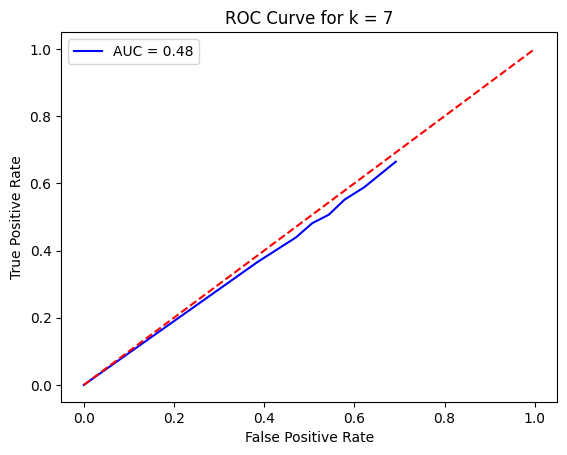

In [ ]:
# Curva ROC:
import matplotlib.pyplot as plt
plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for k = {7}')
plt.legend()
plt.show()

#### **Árboles de decisión** 6 de profundidad máxima, gini, criterio de partición por mínimo de 10 muestras en un nodo y hojas con al menos 1 muestra

In [ ]:
tree = build_tree(X_train_hog_reducido, y_train_hog_arboles, depth=0, max_depth=6, min_samples_split=1, min_samples_leaf=1, criterion='gini')

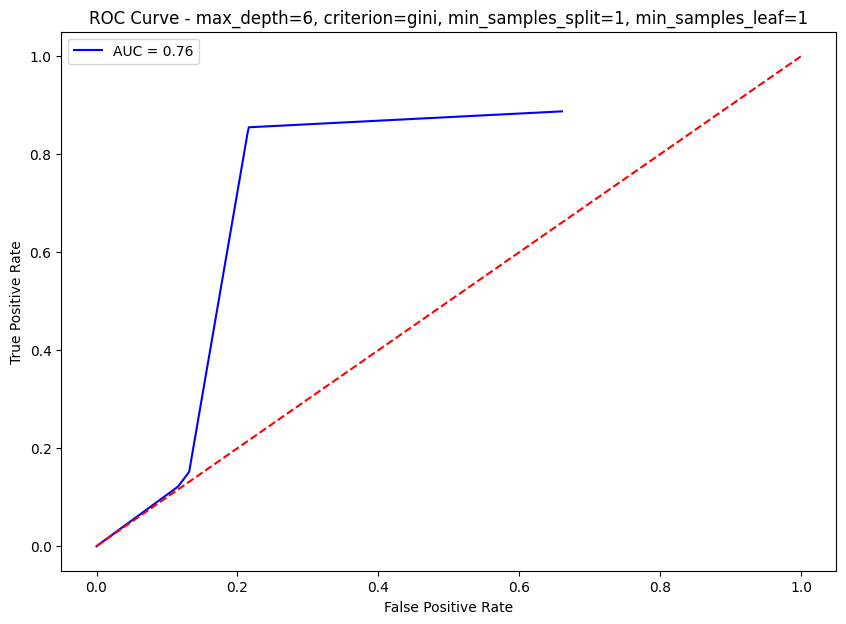

Accuracy: 0.8172
Precision: 0.8004
Recall: 0.8452
False Positive Rate: 0.2109
Balanced Accuracy: 0.8171


In [ ]:
y_pred = predict(tree, X_test_hog)
y_scores = predict_proba(tree, X_test_hog)
fprs, tprs, auc = roc_auc(y_test_hog_arboles, y_scores)
auc = roc_auc_score(y_test_hog_arboles, y_scores)
plot_roc_curve(fprs, tprs, auc, 6, 'gini', 1, 1)  # Mostramos la curva ROC
imprimir_resultados_sin_graficar(y_test_hog_arboles,y_pred)

#### **Regresión Logística** linear con regularización l1 de fuerza C=1, máximo 1 millón de iteraciones

In [ ]:
def logistic_regression_predict_proba(coefficients, X):
    # Añade un término de sesgo a X
    X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]

    # Calcula el log-odds (logit) para cada muestra
    log_odds = np.dot(X_with_bias, coefficients)

    # Calcula la probabilidad usando la función sigmoide
    probabilities = 1 / (1 + np.exp(-log_odds))

    return probabilities

In [ ]:
set_seed(2023)
classifier_rl = LogisticRegression(penalty='l1', C=1,solver='liblinear',max_iter=int(1e6))
classifier_rl.fit(X_train_hog, y_train)

LogisticRegression(C=1, max_iter=1000000, penalty='l1', solver='liblinear')

Accuracy: 0.9498
Precision: 0.9563
Recall: 0.9426
False Positive Rate: 0.0431
Balanced Accuracy: 0.9498


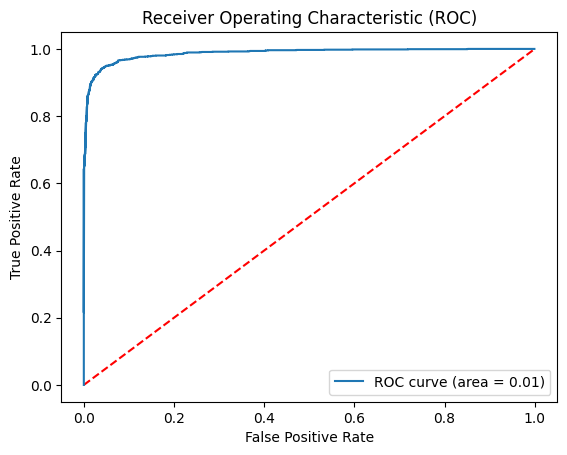

In [ ]:
set_seed(2023)
y_pred_hog_rl = classifier_rl.predict(X_test_hog)
y_scores = classifier_rl.predict_proba(X_test_hog)[:, 1]
imprimir_resultados(y_test,y_pred_hog_rl,y_scores)

Nota: El valor de AUC es realemente: 1 - area, con area el valor reportado en la imagen.

#### **Random Forests** con 100 árboles de máximo 20 de profundidad, criterio de partición por mínimo de 10 muestras en un nodo y hojas con al menos 1 muestra

Accuracy: 0.9362
Precision: 0.9425
Recall: 0.9290
False Positive Rate: 0.0567
Balanced Accuracy: 0.9362


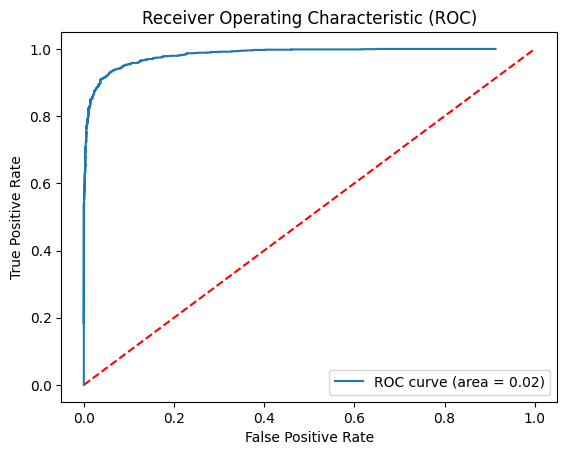

In [ ]:
# Definir y entrenar el clasificador
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=2023
)

rf_classifier.fit(X_train_hog, y_train)

# Obtener las probabilidades predichas para las clases positivas
y_probs = rf_classifier.predict_proba(X_test_hog)[:, 1]

# Puedes usar estas probabilidades junto con las etiquetas reales para calcular diferentes métricas
predictions = (y_probs > 0.5).astype(int)  # Convertir probabilidades a etiquetas usando un umbral (por ejemplo, 0.5)

# Imprimir resultados
imprimir_resultados(y_test, predictions, y_probs)

Nota: El valor de AUC es realemente: 1 - area, con area el valor reportado en la imagen.

#### **Boosting** con máximo de K=50 clasificadores y profundidades máximas max_depth=3

Accuracy: 0.9309
Precision: 0.9332
Recall: 0.9282
False Positive Rate: 0.0665
Balanced Accuracy: 0.9309


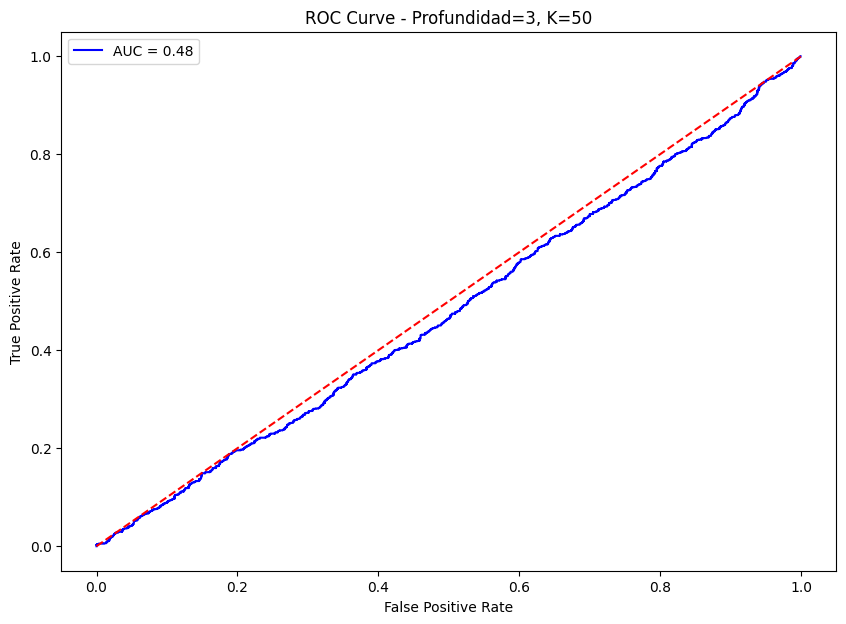

In [ ]:
classifiers, alphas = adaboost_train(X_train_hog, y_train_transformed, K=50, max_depth=3)
y_scores = adaboost_predict_scores(X_test_hog, classifiers, alphas)
y_pred = np.sign(y_scores)
y_test_boosting_hog = y_test_transformed.copy()
y_pred = (y_pred + 1) // 2
y_test_boosting_hog = (y_test_boosting_hog + 1) // 2
imprimir_resultados_sin_graficar(y_test_boosting_hog,y_pred)

fprs, tprs, auc = roc_auc(y_val, y_scores)
auc = roc_auc_score(y_val, y_scores)

plot_roc_curve_boosting(fprs, tprs, auc, 3, 50)

#### Resultados finales:

| Modelo               | Accuracy | Precision | Recall | False Positive Rate | Balanced Accuracy |
|----------------------|----------|-----------|--------|----------------------|-------------------|
| 7 NN                 | 0.9195   | 0.8999    | 0.9441 | 0.1051               | 0.9195            |
| Decision Trees       | 0.8172   | 0.8004    | 0.8452 | 0.2109               | 0.8171            |
| Regresion logistica  | 0.9498   | 0.9563    | 0.9426 | 0.0431               | 0.9498            |
| Random Forests       | 0.9362   | 0.9425    | 0.9290 | 0.0567               | 0.9362            |
| Boosting             | 0.9309   | 0.9332    | 0.9282 | 0.0665               | 0.9309            |





Por lo tanto, nuestro modelo elegido para HOG features será Regresión Logística.

## HAAR Features PCA

#### **KNN** con K = 13 (13-Nearest Neighbours)

In [ ]:
knn = KNN(k=13)
knn.fit(X_train_haar, y_train_haar)
y_pred = knn.predict(X_test_haar)
imprimir_resultados_sin_graficar(y_test_haar,y_pred)


y_scores = knn_predict_proba(knn, X_test_haar)
fprs, tprs, auc = roc_auc(y_test_haar, y_scores)
auc = roc_auc_score(y_test_haar, y_scores)
print(f"AUC: {auc:.2f}")

Accuracy: 0.8000
Precision: 0.7500
Recall: 1.0000
False Positive Rate: 0.5000
Balanced Accuracy: 0.7500
AUC: 0.88


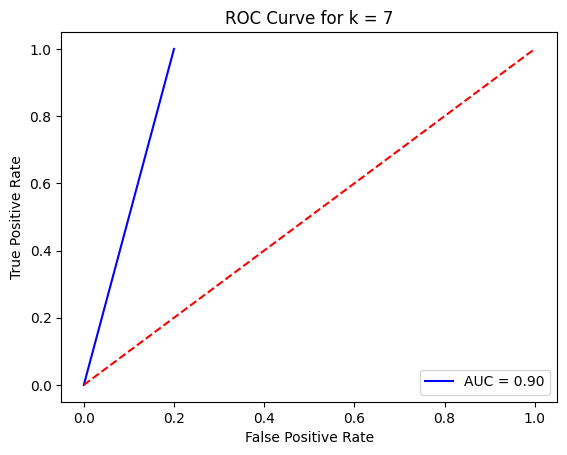

In [ ]:
# Curva ROC:
import matplotlib.pyplot as plt
plt.plot(fprs, tprs, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for k = {7}')
plt.legend()
plt.show()

#### **Árboles de decisión** de 6 de profundidad máxima, gini, criterio de partición por mínimo de 6 muestras en un nodo y hojas con al menos 1 muestra

In [ ]:
y_train_haar_arboles = y_train_haar.astype(int)
y_val_haar_arboles = y_val_haar.astype(int)
y_test_haar_arboles = y_test_haar.astype(int)
tree = build_tree(X_train_haar, y_train_haar_arboles, depth=0, max_depth=6, min_samples_split=4, min_samples_leaf=1, criterion='gini')

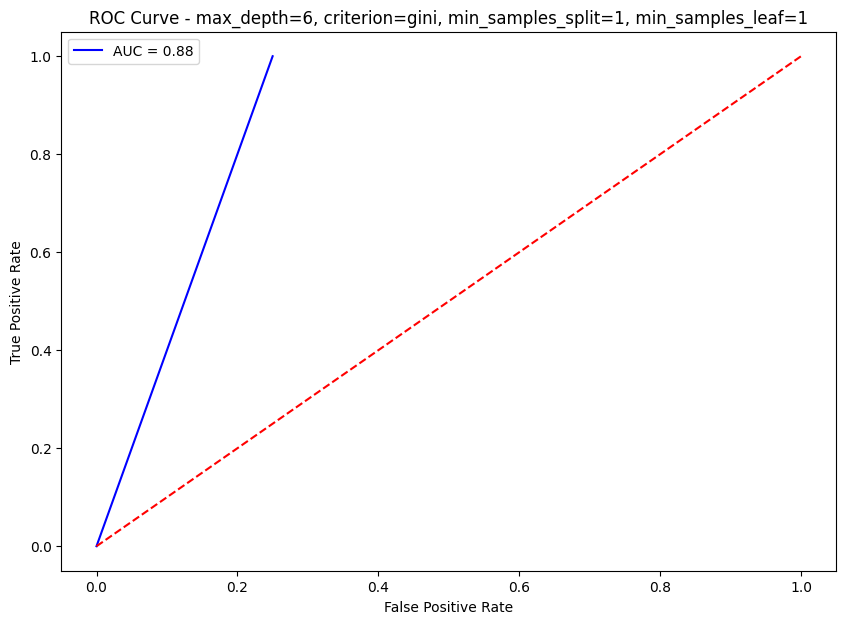

Accuracy: 0.9000
Precision: 0.8571
Recall: 1.0000
False Positive Rate: 0.2500
Balanced Accuracy: 0.8750


In [ ]:
y_pred = predict(tree, X_test_haar)
y_scores = predict_proba(tree, X_test_haar)
fprs, tprs, auc = roc_auc(y_test_haar_arboles, y_scores)
auc = roc_auc_score(y_test_haar_arboles, y_scores)
plot_roc_curve(fprs, tprs, auc, 6, 'gini', 1, 1)  # Mostramos la curva ROC
imprimir_resultados_sin_graficar(y_test_haar_arboles,y_pred)

#### **Regresión Logística** linear con regularización l1 de fuerza C=1, máximo 1 millón de iteraciones

In [ ]:
def logistic_regression_predict_proba(coefficients, X):
    # Añade un término de sesgo a X
    X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]

    # Calcula el log-odds (logit) para cada muestra
    log_odds = np.dot(X_with_bias, coefficients)

    # Calcula la probabilidad usando la función sigmoide
    probabilities = 1 / (1 + np.exp(-log_odds))

    return probabilities

In [ ]:
set_seed(2023)
classifier_rl = LogisticRegression(penalty='l1', C=1,solver='liblinear',max_iter=int(1e6))
classifier_rl.fit(X_train_haar, y_train_haar)

LogisticRegression(C=1, max_iter=1000000, penalty='l1', solver='liblinear')

Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
False Positive Rate: 0.4000
Balanced Accuracy: 0.8000


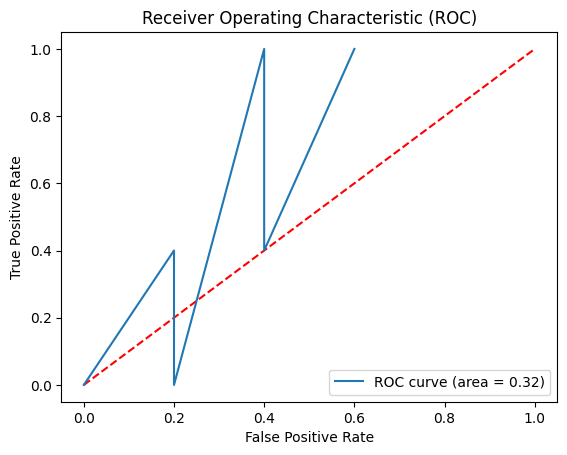

[1. 1. 0. 0. 1. 0. 0. 1. 1. 0.]
[1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [ ]:
set_seed(2023)
y_pred_haar_rl = classifier_rl.predict(X_test_haar)
y_scores = classifier_rl.predict_proba(X_test_haar)[:, 1]
imprimir_resultados(y_test_haar,y_pred_haar_rl,y_scores)

print(y_test_haar)
print(y_pred_haar_rl)

#### **Random Forests** con 100 árboles de máximo 20 de profundidad, criterio de partición por mínimo de 10 muestras en un nodo y hojas con al menos 1 muestra

Accuracy: 0.9000
Precision: 0.8333
Recall: 1.0000
False Positive Rate: 0.2000
Balanced Accuracy: 0.9000


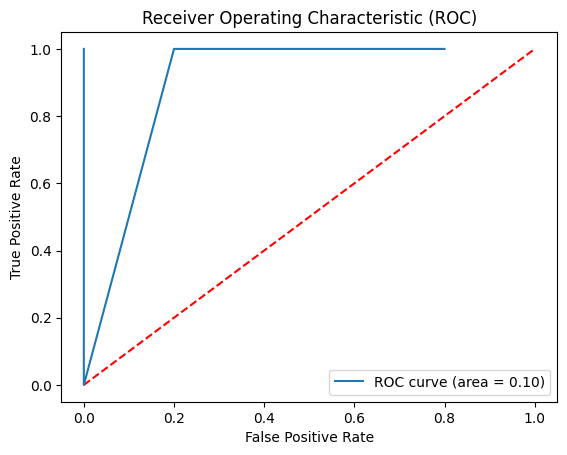

In [ ]:
# Definir y entrenar el clasificador
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=2023
)

rf_classifier.fit(X_train_haar, y_train_haar)

# Obtener las probabilidades predichas para las clases positivas
y_probs = rf_classifier.predict_proba(X_test_haar)[:, 1]

# Puedes usar estas probabilidades junto con las etiquetas reales para calcular diferentes métricas
predictions = (y_probs > 0.5).astype(int)  # Convertir probabilidades a etiquetas usando un umbral (por ejemplo, 0.5)

# Imprimir resultados
imprimir_resultados(y_test_haar, predictions, y_probs)

Nota: El valor de AUC es realemente: 1 - area, con area el valor reportado en la imagen.

#### **Boosting** con máximo de K=25 clasificadores y profundidad máxima max_depth=1

In [ ]:
y_train_haar_transformed = np.where(y_train_haar == 0, -1, 1)
y_test_haar_transformed = np.where(y_test_haar == 0, -1, 1)

Accuracy: 0.7000
Precision: 1.0000
Recall: 0.6667
False Positive Rate: 0.0000
Balanced Accuracy: 0.8333


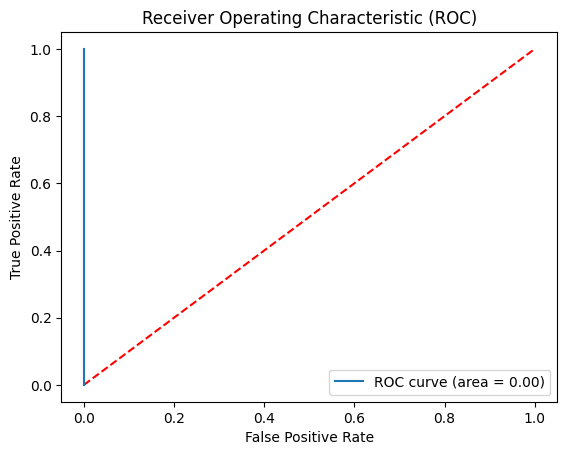

In [ ]:
classifiers, alphas = adaboost_train(X_train_haar, y_train_haar_transformed, K=25, max_depth=1)
y_scores = adaboost_predict_scores(X_test_haar, classifiers, alphas)
y_pred = np.sign(y_scores)
#Volvemos a usar 0s y 1s para reutilizar funciones de metricas definidas anteriormente
y_pred = (y_pred + 1) // 2
y_val = (y_test_haar_transformed + 1) // 2
imprimir_resultados(y_pred,y_val,y_scores)

#### Resultados finales:

| Modelo               | Accuracy | Precision | Recall | False Positive Rate | Balanced Accuracy |
|----------------------|----------|-----------|--------|----------------------|-------------------|
| 13 - NN                  | 0.8000   | 0.7500    | 1.0000 | 0.5000               | 0.7500            |
| Decision Trees       | 1.0000 | 1.0000    | 1.0000 | 0.0000               | 1.0000            |
| Regresion Logistica  | 0.8000   | 0.7143    | 1.0000 | 0.4000               | 0.8000            |
| Random Forests       | 0.9000   | 0.8333    | 1.0000 | 0.2000               | 0.9000            |
| Boosting             | 0.7000   | 1.0000    | 0.6667 | 0.0000               | 0.8333            |




Para esta clase de features, obtenemos que el mejor clasificador es Decision Trees.

